In [1]:
import random
import torch
import json
import tifffile
import numpy as np
import pandas as pd
from tqdm import tqdm
import io
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from datasets import Dataset
from PIL import Image
from IPython.display import display
from patchify import patchify

d:\GIT-CS370-IntroductionToAI\cs370-tn268-introduction-to-ai-assignments\finalproj-segment-anything-model\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Checkpoint

In [7]:
from datasets import load_dataset
train = load_dataset("back2classroom/sidewalks", split='train', streaming=False)
val   = load_dataset("back2classroom/sidewalks", split='val', streaming=False)
train, val

(Dataset({
     features: ['filename', 'tfw', 'tif', 'label_tif', 'label_tfw'],
     num_rows: 180000
 }),
 Dataset({
     features: ['filename', 'tfw', 'tif', 'label_tif', 'label_tfw'],
     num_rows: 19999
 }))

In [8]:
image_arr = []
label_arr = []
tif_bytes = []
lbl_bytes = []
fname = []

def byte_string_to_binary(label, normalize=False):
    """
    Convert a byte string to a binary black and white numpy array.

    Args:
    - label: A byte string representing an image.
    - normalize: Boolean indicating whether to normalize the image array (default is False).

    Returns:
    - image_object: PIL Image object.
    - binary_img_arr: A binary black and white numpy array.
    """
    # Convert byte string to PIL Image object
    image_object = io.BytesIO(label)
    image_array = np.array(Image.open(image_object))

    # Thresholding to convert to binary black and white
    if normalize:
        binary_img_arr = (image_array).astype(np.uint8) / 255.0
    else:
        binary_img_arr = (image_array).astype(np.uint8)

    return image_object, binary_img_arr

TOTAL_ITER = 10000
progress_bar = tqdm(total=TOTAL_ITER, desc='Processing')

for idx, item in enumerate(train):
    image_object, image_array = byte_string_to_binary(item['tif'], normalize=False)
    label_object, label_array = byte_string_to_binary(item['label_tif'])
    # Check if the mask is not full black to filter out no-sidewalks img
    if not np.all(label_array[0] == 0):
        fname.append(item['filename'])
        tif_bytes.append(image_object)
        lbl_bytes.append(label_object)
        image_arr.append(image_array)
        label_arr.append(label_array)
    
    # Update the progress bar
    progress_bar.update(1)

    if idx == TOTAL_ITER:
        break

Processing: 10001it [00:19, 511.57it/s]                           
Processing: 100%|█████████▉| 9988/10000 [00:06<00:00, 1510.82it/s]

In [27]:
# Check data
test_image_arr = []
test_label_arr = []
for idx, item in enumerate(train):
    test_image_arr.append(item['tif'])
    test_label_arr.append(item['label_tif'])
    if idx == 6:
        break

label_object = io.BytesIO(test_label_arr[5])
label_array = np.array(Image.open(label_object))

# Thresholding to convert to binary black and white
binary_lbl_arr = (label_array).astype(np.uint8)
print(binary_lbl_arr[0])

image_object = io.BytesIO(test_image_arr[5])
image_array = np.array(Image.open(image_object))

# Thresholding to convert to binary black and white
binary_img_arr = (image_array).astype(np.uint8)  /255
print(binary_img_arr[0])

[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0.47843137 0.51764706 0.5254902 ]
 [0.75686275 0.85882353 0.85490196]
 [0.70980392 0.95294118 0.90980392]
 [0.60784314 0.96470588 0.89803922]
 [0.59607843 1.         0.94901961]
 [0.57647059 1.         0.94117647]
 [0.56862745 0.92156863 0.88235294]
 [0.51764706 0.72941176 0.7372549 ]
 [0.4745098  0.49803922 0.56078431]
 [0.20784314 0.09019608 0.19215686]
 [0.41568627 0.2        0.31372549]
 [0.42352941 0.21176471 0.30588235]
 [0.44313725 0.31764706 0.36078431]
 [0.47843137

In [9]:
# Create a DataFrame
df = pd.DataFrame({
    'image': tif_bytes,
    'label': lbl_bytes,
    'imgarr': image_arr,
    'lblarr': label_arr
})

# Export the DataFrame to a CSV file
df.to_pickle('dataset.pkl')

# Print the dimensions of the DataFrame
print("DataFrame Dimensions:", df.shape)

DataFrame Dimensions: (2820, 4)


## Train

#### Load stored dataset

In [2]:
data = pd.read_pickle('dataset.pkl')
print(data.head())

                                        image  \
0  <_io.BytesIO object at 0x0000022FA0994CC0>   
1  <_io.BytesIO object at 0x0000022FA0994D10>   
2  <_io.BytesIO object at 0x0000022FA0994D60>   
3  <_io.BytesIO object at 0x0000022FA0994DB0>   
4  <_io.BytesIO object at 0x0000022FA0994E00>   

                                        label  \
0  <_io.BytesIO object at 0x0000022FA3998180>   
1  <_io.BytesIO object at 0x0000022FA39981D0>   
2  <_io.BytesIO object at 0x0000022FA3998220>   
3  <_io.BytesIO object at 0x0000022FA3998270>   
4  <_io.BytesIO object at 0x0000022FA39982C0>   

                                              imgarr  \
0  [[[122, 132, 134], [193, 219, 218], [181, 243,...   
1  [[[126, 64, 77], [124, 64, 72], [124, 68, 69],...   
2  [[[52, 36, 39], [59, 50, 51], [62, 68, 66], [5...   
3  [[[50, 102, 80], [104, 151, 131], [97, 131, 11...   
4  [[[108, 76, 89], [110, 78, 91], [112, 80, 93],...   

                                              lblarr  
0  [[1, 1, 1, 1, 1

In [3]:
from datasets import Dataset
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in data['imgarr']],
    "label": [Image.fromarray(mask) for mask in data['lblarr']],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2820
})

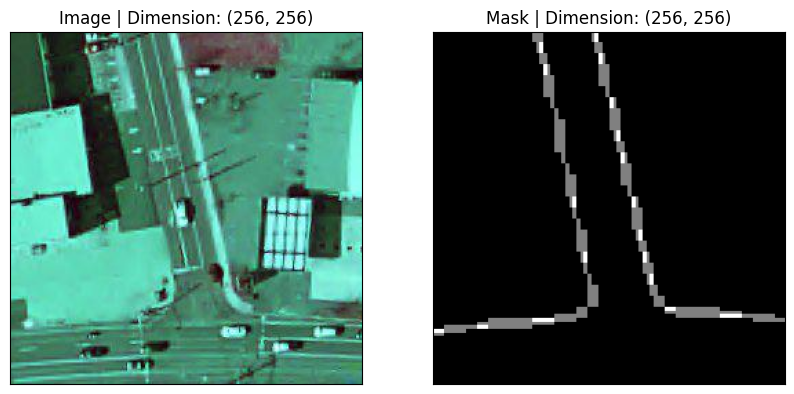

In [4]:
# Display training data
img_num = random.randint(0, dataset.shape[0])
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.array(example_image), cmap='gray')  
axes[0].set_title(f'Image | Dimension: {example_image.size}')

axes[1].imshow(example_mask, cmap='gray')
axes[1].set_title(f'Mask | Dimension: {example_image.size}')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

#### Test Bounding Box

In [193]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

[16, 0, 231, 255]


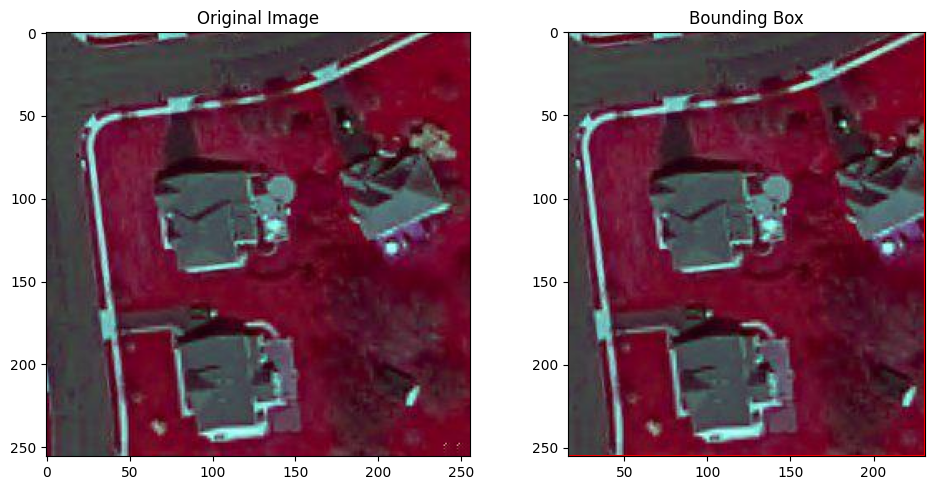

In [202]:
idx = random.randint(0, len(dataset))
image = dataset[idx]["image"]
ground_truth_mask = np.array(dataset[idx]["label"]) # turn image object to array
prompt = get_bounding_box(ground_truth_mask)
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt")
print(prompt)

# Convert image to numpy array
image_np = np.array(image)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image with bounding box
axs[0].imshow(image_np)
axs[0].set_title('Original Image')

# Plot just the bounding box
axs[1].imshow(image_np)
x_min, y_min, x_max, y_max = prompt
axs[1].plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color='red')
axs[1].set_xlim(x_min, x_max)  # Adjust xlim to zoom in around the bounding box
axs[1].set_ylim(y_max, y_min)  # Adjust ylim to zoom in around the bounding box
axs[1].set_title('Bounding Box')

# Show the plot
plt.tight_layout()
plt.show()

#### Train

In [5]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [6]:
from transformers import SamProcessor

# Load the modified configuration from the JSON file
with open("sam-config.json", "r") as f:
    modified_config_dict = json.load(f)

# Initialize the processor with the modified configuration
processor = SamProcessor.from_pretrained("facebook/sam-vit-base", 
                                         **modified_config_dict)

# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

example = train_dataset[0]
for k, v in example.items():
    print(k, v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [7]:
# Get the minimum and maximum pixel values
min_pix = torch.min(example['pixel_values']).item()
max_pix = torch.max(example['pixel_values']).item()

# Check for negative pixel values
has_negative = torch.any(example['pixel_values'] < 0).item()

# Print the results
print("Minimum pixel value:", min_pix)
print("Maximum pixel value:", max_pix)
print("Check for negative pixel:", has_negative)
print(example['pixel_values'])

Minimum pixel value: 0.0
Maximum pixel value: 1.0
Check for negative pixel: False
tensor([[[0.4784, 0.4784, 0.5137,  ..., 0.5059, 0.4980, 0.4980],
         [0.4784, 0.4784, 0.5137,  ..., 0.5059, 0.4980, 0.4980],
         [0.4706, 0.4706, 0.5059,  ..., 0.5137, 0.5059, 0.5059],
         ...,
         [0.3608, 0.3608, 0.3608,  ..., 0.2863, 0.2902, 0.2902],
         [0.3647, 0.3647, 0.3647,  ..., 0.2667, 0.2706, 0.2706],
         [0.3647, 0.3647, 0.3647,  ..., 0.2667, 0.2706, 0.2706]],

        [[0.5176, 0.5176, 0.5608,  ..., 0.1843, 0.1725, 0.1725],
         [0.5176, 0.5176, 0.5608,  ..., 0.1843, 0.1725, 0.1725],
         [0.5059, 0.5059, 0.5451,  ..., 0.1922, 0.1843, 0.1843],
         ...,
         [0.1176, 0.1176, 0.1176,  ..., 0.4902, 0.4902, 0.4902],
         [0.1176, 0.1176, 0.1176,  ..., 0.4863, 0.4902, 0.4902],
         [0.1176, 0.1176, 0.1176,  ..., 0.4863, 0.4902, 0.4902]],

        [[0.5255, 0.5255, 0.5686,  ..., 0.2510, 0.2431, 0.2431],
         [0.5255, 0.5255, 0.5686,  ..., 0

In [8]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
# train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

from torch.utils.data import random_split

# Assuming train_dataset is your full dataset
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # Remaining 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader instances for training and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, drop_last=False)


batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

print()
batch["ground_truth_mask"].shape

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])



torch.Size([2, 256, 256])

In [9]:
# Load the model
import monai.losses
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

from torch.optim import Adam
import monai
from monai.metrics import DiceMetric
from monai.metrics import compute_iou

# Initialize the optimizer and the loss function
optimizer = Adam(
    model.mask_decoder.parameters(),
    lr=0.001,  # Initial learning rate
    weight_decay=0.01,
    betas=(0.9, 0.999),  # Momentum coefficients
    eps=1e-08,  
    amsgrad=True
)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
# seg_loss = monai.losses.DiceCELoss(sigmoid=True)
# seg_loss = monai.losses.FocalLoss(use_softmax=True, reduction='mean')
seg_loss = monai.losses.FocalLoss(reduction='mean')

DiceCELoss: Compute both Dice loss and Cross Entropy Loss, and return the weighted sum of these two losses.

In [ ]:
# Split the dataset
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # Remaining 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader instances for training and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, drop_last=False)


In [10]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from transformers import get_scheduler
import csv

# Define the CSV file path
csv_path = "training_metrics.csv"

# Open the CSV file in append mode
with open(csv_path, mode='a', newline='') as file:
    writer = csv.writer(file)

    # Write the headers if the file is empty
    if file.tell() == 0:
        writer.writerow(["Epoch", "Batch", "Loss", "IoU"])

    #Training loop
    num_epochs = 1
    # """
    # num_training_steps = num_epochs * len(train_dataloader)
    # lr_scheduler = get_scheduler(
    #     name="linear", optimizer=optimizer, num_warmup_steps=0,
    #     num_training_steps=num_training_steps
    # )
    # """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    model.train()

    epoch_losses = []
    epoch_ious = []

    for epoch in range(num_epochs):
        print(f'EPOCH: {epoch}')

        # save losses in every batch
        batch_losses = []
        # save IoU in every batch
        batch_ious = []

        for i, batch in enumerate(tqdm(train_dataloader)):

            # forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            # process the output: from sigmoid to class

            predicted_masks = outputs.pred_masks.squeeze(1) 
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)

            sam_masks_prob = torch.sigmoid(predicted_masks)
            sam_masks_prob = sam_masks_prob.squeeze()
            sam_masks = (sam_masks_prob > 0.5)

            # compute loss
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            batch_losses.append(loss.item())

            # compute IoU: return 2 values: 1 for each batch
            ious = compute_iou(sam_masks.unsqueeze(1),
                                ground_truth_masks.unsqueeze(1), ignore_empty=False)
            batch_ious.append(ious.mean())

            print("batch:", i, "loss:", loss.item(), "   batch_ious: ", ious.mean().item())

            # write the metrics to the csv file
            writer.writerow([epoch, i, loss.item(), ious.mean().item()])

            # backward pass (compute gradients of parameters w.r.t. loss)
            optimizer.zero_grad()
            loss.backward()

            # optimize
            optimizer.step()

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # compute mean loss for an epoch
        mean_loss = mean(batch_losses)
        epoch_losses.append(mean_loss)
        print(f'Mean loss: {mean_loss}')

        # compute mean IoU for an epoch
        mean_iou = mean([t.cpu().item() for t in batch_ious])
        epoch_ious.append(mean_iou)
        print(f'Mean IoU: {mean_iou}')

EPOCH: 0


  0%|          | 0/1128 [00:00<?, ?it/s]

batch: 0 loss: 1.0154573917388916    batch_ious:  0.39304858446121216


  0%|          | 2/1128 [00:03<31:17,  1.67s/it]

batch: 1 loss: 0.6202531456947327    batch_ious:  0.0


  0%|          | 3/1128 [00:05<31:18,  1.67s/it]

batch: 2 loss: 6.811069965362549    batch_ious:  0.02398681640625


  0%|          | 4/1128 [00:06<30:30,  1.63s/it]

batch: 3 loss: 0.04378324747085571    batch_ious:  0.0


  0%|          | 5/1128 [00:08<29:36,  1.58s/it]

batch: 4 loss: 0.03077702969312668    batch_ious:  0.0


  1%|          | 6/1128 [00:09<30:10,  1.61s/it]

batch: 5 loss: 0.02794972062110901    batch_ious:  0.0


  1%|          | 7/1128 [00:11<29:41,  1.59s/it]

batch: 6 loss: 0.19901666045188904    batch_ious:  0.0


  1%|          | 8/1128 [00:12<28:17,  1.52s/it]

batch: 7 loss: 0.03233112022280693    batch_ious:  0.0


  1%|          | 9/1128 [00:14<28:17,  1.52s/it]

batch: 8 loss: 0.054092925041913986    batch_ious:  0.0


  1%|          | 10/1128 [00:15<27:59,  1.50s/it]

batch: 9 loss: 0.05036269128322601    batch_ious:  0.0


  1%|          | 11/1128 [00:17<27:14,  1.46s/it]

batch: 10 loss: 0.3082037568092346    batch_ious:  0.0


  1%|          | 12/1128 [00:18<27:06,  1.46s/it]

batch: 11 loss: 0.13504144549369812    batch_ious:  0.11544102430343628


  1%|          | 13/1128 [00:20<27:02,  1.45s/it]

batch: 12 loss: 0.04502962529659271    batch_ious:  0.0


  1%|          | 14/1128 [00:21<26:34,  1.43s/it]

batch: 13 loss: 0.06055210158228874    batch_ious:  0.0


  1%|▏         | 15/1128 [00:23<27:00,  1.46s/it]

batch: 14 loss: 0.14228254556655884    batch_ious:  0.0


  1%|▏         | 16/1128 [00:24<26:49,  1.45s/it]

batch: 15 loss: 0.17335526645183563    batch_ious:  0.0


  2%|▏         | 17/1128 [00:25<26:34,  1.44s/it]

batch: 16 loss: 0.05426306277513504    batch_ious:  0.0


  2%|▏         | 18/1128 [00:27<27:23,  1.48s/it]

batch: 17 loss: 0.0333845317363739    batch_ious:  0.0


  2%|▏         | 19/1128 [00:28<27:46,  1.50s/it]

batch: 18 loss: 0.07668669521808624    batch_ious:  0.0


  2%|▏         | 20/1128 [00:30<28:08,  1.52s/it]

batch: 19 loss: 0.06050489842891693    batch_ious:  0.0


  2%|▏         | 21/1128 [00:32<28:27,  1.54s/it]

batch: 20 loss: 0.06814882159233093    batch_ious:  0.0


  2%|▏         | 22/1128 [00:33<28:24,  1.54s/it]

batch: 21 loss: 0.052369147539138794    batch_ious:  0.0


  2%|▏         | 23/1128 [00:35<28:19,  1.54s/it]

batch: 22 loss: 0.06437484920024872    batch_ious:  0.0


  2%|▏         | 24/1128 [00:36<27:47,  1.51s/it]

batch: 23 loss: 0.06806101649999619    batch_ious:  0.0


  2%|▏         | 25/1128 [00:38<27:04,  1.47s/it]

batch: 24 loss: 0.04229855537414551    batch_ious:  0.0


  2%|▏         | 26/1128 [00:39<27:30,  1.50s/it]

batch: 25 loss: 0.0721510499715805    batch_ious:  0.0


  2%|▏         | 27/1128 [00:41<27:05,  1.48s/it]

batch: 26 loss: 0.051730677485466    batch_ious:  0.0


  2%|▏         | 28/1128 [00:42<27:43,  1.51s/it]

batch: 27 loss: 0.05182924494147301    batch_ious:  0.0


  3%|▎         | 29/1128 [00:44<27:53,  1.52s/it]

batch: 28 loss: 0.01862471178174019    batch_ious:  0.0


  3%|▎         | 30/1128 [00:45<27:34,  1.51s/it]

batch: 29 loss: 0.026391610503196716    batch_ious:  0.0


  3%|▎         | 31/1128 [00:47<26:49,  1.47s/it]

batch: 30 loss: 0.06259629130363464    batch_ious:  0.0


  3%|▎         | 32/1128 [00:48<26:16,  1.44s/it]

batch: 31 loss: 0.028427304700016975    batch_ious:  0.0


  3%|▎         | 33/1128 [00:49<26:27,  1.45s/it]

batch: 32 loss: 0.06695853173732758    batch_ious:  0.0


  3%|▎         | 34/1128 [00:51<26:31,  1.45s/it]

batch: 33 loss: 0.05582220107316971    batch_ious:  0.0


  3%|▎         | 35/1128 [00:52<26:14,  1.44s/it]

batch: 34 loss: 0.5938162207603455    batch_ious:  0.0


  3%|▎         | 36/1128 [00:54<26:06,  1.43s/it]

batch: 35 loss: 0.06664098799228668    batch_ious:  0.0


  3%|▎         | 37/1128 [00:55<26:18,  1.45s/it]

batch: 36 loss: 0.31725427508354187    batch_ious:  0.0


  3%|▎         | 38/1128 [00:57<26:19,  1.45s/it]

batch: 37 loss: 0.16009780764579773    batch_ious:  0.070949986577034


  3%|▎         | 39/1128 [00:58<26:28,  1.46s/it]

batch: 38 loss: 0.2054637223482132    batch_ious:  0.027885358780622482


  4%|▎         | 40/1128 [01:00<26:48,  1.48s/it]

batch: 39 loss: 0.2087203562259674    batch_ious:  0.032931048423051834


  4%|▎         | 41/1128 [01:01<26:58,  1.49s/it]

batch: 40 loss: 0.17444133758544922    batch_ious:  0.02862454019486904


  4%|▎         | 42/1128 [01:03<26:56,  1.49s/it]

batch: 41 loss: 0.13106998801231384    batch_ious:  0.0


  4%|▍         | 43/1128 [01:04<26:54,  1.49s/it]

batch: 42 loss: 0.12883421778678894    batch_ious:  0.0


  4%|▍         | 44/1128 [01:06<27:16,  1.51s/it]

batch: 43 loss: 0.08216272294521332    batch_ious:  0.0


  4%|▍         | 45/1128 [01:07<27:11,  1.51s/it]

batch: 44 loss: 0.05376344546675682    batch_ious:  0.0


  4%|▍         | 46/1128 [01:09<26:52,  1.49s/it]

batch: 45 loss: 0.07577735930681229    batch_ious:  0.0


  4%|▍         | 47/1128 [01:10<26:56,  1.50s/it]

batch: 46 loss: 0.029796801507472992    batch_ious:  0.0


  4%|▍         | 48/1128 [01:12<27:45,  1.54s/it]

batch: 47 loss: 0.02685716561973095    batch_ious:  0.0


  4%|▍         | 49/1128 [01:13<27:46,  1.54s/it]

batch: 48 loss: 0.054421938955783844    batch_ious:  0.0


  4%|▍         | 50/1128 [01:15<27:31,  1.53s/it]

batch: 49 loss: 0.09641485661268234    batch_ious:  0.0


  5%|▍         | 51/1128 [01:16<28:02,  1.56s/it]

batch: 50 loss: 0.049505721777677536    batch_ious:  0.0


  5%|▍         | 52/1128 [01:18<28:11,  1.57s/it]

batch: 51 loss: 0.06098184734582901    batch_ious:  0.0


  5%|▍         | 53/1128 [01:20<27:59,  1.56s/it]

batch: 52 loss: 0.03351019322872162    batch_ious:  0.0


  5%|▍         | 54/1128 [01:21<28:01,  1.57s/it]

batch: 53 loss: 0.07258601486682892    batch_ious:  0.0


  5%|▍         | 55/1128 [01:23<28:10,  1.58s/it]

batch: 54 loss: 0.05338364839553833    batch_ious:  0.0


  5%|▍         | 56/1128 [01:24<28:10,  1.58s/it]

batch: 55 loss: 0.042815983295440674    batch_ious:  0.0


  5%|▌         | 57/1128 [01:26<27:55,  1.56s/it]

batch: 56 loss: 0.04613656550645828    batch_ious:  0.0


  5%|▌         | 58/1128 [01:27<27:53,  1.56s/it]

batch: 57 loss: 0.039665915071964264    batch_ious:  0.0


  5%|▌         | 59/1128 [01:29<27:36,  1.55s/it]

batch: 58 loss: 0.0377197228372097    batch_ious:  0.0


  5%|▌         | 60/1128 [01:31<27:46,  1.56s/it]

batch: 59 loss: 0.04661409184336662    batch_ious:  0.0


  5%|▌         | 61/1128 [01:32<27:48,  1.56s/it]

batch: 60 loss: 0.0834561288356781    batch_ious:  0.0


  5%|▌         | 62/1128 [01:34<28:00,  1.58s/it]

batch: 61 loss: 0.07649378478527069    batch_ious:  0.0


  6%|▌         | 63/1128 [01:35<28:22,  1.60s/it]

batch: 62 loss: 0.042695507407188416    batch_ious:  0.0
batch: 63 loss: 0.03155304118990898    batch_ious:  0.0


  6%|▌         | 65/1128 [01:39<28:41,  1.62s/it]

batch: 64 loss: 0.04699288308620453    batch_ious:  0.0
batch: 65 loss: 0.03618868067860603    batch_ious:  0.0


  6%|▌         | 67/1128 [01:42<31:03,  1.76s/it]

batch: 66 loss: 0.026062097400426865    batch_ious:  0.0


  6%|▌         | 68/1128 [01:44<29:57,  1.70s/it]

batch: 67 loss: 0.06526105105876923    batch_ious:  0.0


  6%|▌         | 69/1128 [01:46<29:41,  1.68s/it]

batch: 68 loss: 0.039066918194293976    batch_ious:  0.0


  6%|▌         | 70/1128 [01:47<28:31,  1.62s/it]

batch: 69 loss: 0.07968927919864655    batch_ious:  0.0


  6%|▋         | 71/1128 [01:49<27:47,  1.58s/it]

batch: 70 loss: 0.035272855311632156    batch_ious:  0.0


  6%|▋         | 72/1128 [01:50<27:57,  1.59s/it]

batch: 71 loss: 0.8069477677345276    batch_ious:  0.0


  6%|▋         | 73/1128 [01:52<27:30,  1.56s/it]

batch: 72 loss: 0.07822003960609436    batch_ious:  0.0


  7%|▋         | 74/1128 [01:53<26:57,  1.53s/it]

batch: 73 loss: 0.1652161031961441    batch_ious:  0.05581427365541458


  7%|▋         | 75/1128 [01:55<27:38,  1.57s/it]

batch: 74 loss: 0.1867614984512329    batch_ious:  0.04629362374544144


  7%|▋         | 76/1128 [01:56<27:28,  1.57s/it]

batch: 75 loss: 0.13693904876708984    batch_ious:  0.009033639915287495


  7%|▋         | 77/1128 [01:58<28:50,  1.65s/it]

batch: 76 loss: 0.09251514822244644    batch_ious:  0.0


  7%|▋         | 78/1128 [02:00<29:17,  1.67s/it]

batch: 77 loss: 0.06667396426200867    batch_ious:  0.0


  7%|▋         | 79/1128 [02:02<28:33,  1.63s/it]

batch: 78 loss: 0.05300884693861008    batch_ious:  0.0


  7%|▋         | 80/1128 [02:03<28:37,  1.64s/it]

batch: 79 loss: 0.042904116213321686    batch_ious:  0.0


  7%|▋         | 81/1128 [02:05<28:10,  1.61s/it]

batch: 80 loss: 0.04395268112421036    batch_ious:  0.0


  7%|▋         | 82/1128 [02:06<28:28,  1.63s/it]

batch: 81 loss: 0.03387048840522766    batch_ious:  0.0


  7%|▋         | 83/1128 [02:08<28:08,  1.62s/it]

batch: 82 loss: 0.051932595670223236    batch_ious:  0.0


  7%|▋         | 84/1128 [02:10<28:03,  1.61s/it]

batch: 83 loss: 0.07193072140216827    batch_ious:  0.0


  8%|▊         | 85/1128 [02:11<28:39,  1.65s/it]

batch: 84 loss: 0.05923077091574669    batch_ious:  0.0
batch: 85 loss: 0.05045522749423981    batch_ious:  0.0


  8%|▊         | 87/1128 [02:16<33:29,  1.93s/it]

batch: 86 loss: 0.7761409878730774    batch_ious:  0.0


  8%|▊         | 88/1128 [02:18<34:01,  1.96s/it]

batch: 87 loss: 0.0601697713136673    batch_ious:  0.0


  8%|▊         | 89/1128 [02:20<34:40,  2.00s/it]

batch: 88 loss: 0.366831511259079    batch_ious:  0.0


  8%|▊         | 90/1128 [02:22<33:34,  1.94s/it]

batch: 89 loss: 0.056544091552495956    batch_ious:  0.0


  8%|▊         | 91/1128 [02:24<32:30,  1.88s/it]

batch: 90 loss: 0.07808589935302734    batch_ious:  0.0


  8%|▊         | 92/1128 [02:25<30:59,  1.80s/it]

batch: 91 loss: 0.07661133259534836    batch_ious:  0.0


  8%|▊         | 93/1128 [02:27<30:42,  1.78s/it]

batch: 92 loss: 0.07966913282871246    batch_ious:  0.0


  8%|▊         | 94/1128 [02:29<30:03,  1.74s/it]

batch: 93 loss: 0.08592075109481812    batch_ious:  0.0


  8%|▊         | 95/1128 [02:30<29:07,  1.69s/it]

batch: 94 loss: 0.08765651285648346    batch_ious:  0.0


  9%|▊         | 96/1128 [02:32<28:05,  1.63s/it]

batch: 95 loss: 0.08975322544574738    batch_ious:  0.0


  9%|▊         | 97/1128 [02:33<27:29,  1.60s/it]

batch: 96 loss: 0.09076585620641708    batch_ious:  0.0


  9%|▊         | 98/1128 [02:35<27:28,  1.60s/it]

batch: 97 loss: 0.08792620152235031    batch_ious:  0.0


  9%|▉         | 99/1128 [02:36<27:08,  1.58s/it]

batch: 98 loss: 0.08597377687692642    batch_ious:  0.0


  9%|▉         | 100/1128 [02:38<26:26,  1.54s/it]

batch: 99 loss: 0.07556812465190887    batch_ious:  0.0


  9%|▉         | 101/1128 [02:39<26:59,  1.58s/it]

batch: 100 loss: 0.08236509561538696    batch_ious:  0.0


  9%|▉         | 102/1128 [02:41<27:02,  1.58s/it]

batch: 101 loss: 0.06912339478731155    batch_ious:  0.0


  9%|▉         | 103/1128 [02:43<27:15,  1.60s/it]

batch: 102 loss: 0.12101440131664276    batch_ious:  0.0


  9%|▉         | 104/1128 [02:44<27:11,  1.59s/it]

batch: 103 loss: 0.055772989988327026    batch_ious:  0.0


  9%|▉         | 105/1128 [02:46<27:20,  1.60s/it]

batch: 104 loss: 0.06430807709693909    batch_ious:  0.0


  9%|▉         | 106/1128 [02:47<27:11,  1.60s/it]

batch: 105 loss: 0.06003725156188011    batch_ious:  0.0


  9%|▉         | 107/1128 [02:49<27:05,  1.59s/it]

batch: 106 loss: 0.06233982369303703    batch_ious:  0.0


 10%|▉         | 108/1128 [02:51<27:37,  1.63s/it]

batch: 107 loss: 0.06224169209599495    batch_ious:  0.0


 10%|▉         | 109/1128 [02:52<27:32,  1.62s/it]

batch: 108 loss: 0.048966847360134125    batch_ious:  0.0


 10%|▉         | 110/1128 [02:54<27:15,  1.61s/it]

batch: 109 loss: 0.10029469430446625    batch_ious:  0.0


 10%|▉         | 111/1128 [02:55<27:12,  1.60s/it]

batch: 110 loss: 0.04107476398348808    batch_ious:  0.0


 10%|▉         | 112/1128 [02:57<28:26,  1.68s/it]

batch: 111 loss: 0.05233636498451233    batch_ious:  0.0


 10%|█         | 113/1128 [02:59<28:28,  1.68s/it]

batch: 112 loss: 0.06331533193588257    batch_ious:  0.0


 10%|█         | 114/1128 [03:01<28:12,  1.67s/it]

batch: 113 loss: 0.713240385055542    batch_ious:  0.0


 10%|█         | 115/1128 [03:02<27:42,  1.64s/it]

batch: 114 loss: 0.06443516910076141    batch_ious:  0.0


 10%|█         | 116/1128 [03:04<26:55,  1.60s/it]

batch: 115 loss: 0.04884452372789383    batch_ious:  0.0


 10%|█         | 117/1128 [03:05<26:35,  1.58s/it]

batch: 116 loss: 0.03654363751411438    batch_ious:  0.0


 10%|█         | 118/1128 [03:07<27:05,  1.61s/it]

batch: 117 loss: 0.11911138892173767    batch_ious:  0.0


 11%|█         | 119/1128 [03:09<27:11,  1.62s/it]

batch: 118 loss: 0.06268797814846039    batch_ious:  0.0


 11%|█         | 120/1128 [03:10<26:52,  1.60s/it]

batch: 119 loss: 0.06429453939199448    batch_ious:  0.0


 11%|█         | 121/1128 [03:12<26:42,  1.59s/it]

batch: 120 loss: 0.06996182352304459    batch_ious:  0.0


 11%|█         | 122/1128 [03:13<26:34,  1.58s/it]

batch: 121 loss: 0.05542345345020294    batch_ious:  0.0


 11%|█         | 123/1128 [03:15<27:00,  1.61s/it]

batch: 122 loss: 0.07118652015924454    batch_ious:  0.0


 11%|█         | 124/1128 [03:17<27:01,  1.61s/it]

batch: 123 loss: 0.33308297395706177    batch_ious:  0.0


 11%|█         | 125/1128 [03:18<27:08,  1.62s/it]

batch: 124 loss: 0.055845409631729126    batch_ious:  0.0


 11%|█         | 126/1128 [03:20<27:02,  1.62s/it]

batch: 125 loss: 0.06291811168193817    batch_ious:  0.0


 11%|█▏        | 127/1128 [03:21<26:35,  1.59s/it]

batch: 126 loss: 0.06214630603790283    batch_ious:  0.0


 11%|█▏        | 128/1128 [03:23<26:17,  1.58s/it]

batch: 127 loss: 0.07136630266904831    batch_ious:  0.0


 11%|█▏        | 129/1128 [03:25<26:41,  1.60s/it]

batch: 128 loss: 0.07281087338924408    batch_ious:  0.0


 12%|█▏        | 130/1128 [03:26<27:35,  1.66s/it]

batch: 129 loss: 0.06198614090681076    batch_ious:  0.0


 12%|█▏        | 131/1128 [03:28<27:08,  1.63s/it]

batch: 130 loss: 0.07777705788612366    batch_ious:  0.0


 12%|█▏        | 132/1128 [03:30<28:08,  1.70s/it]

batch: 131 loss: 0.06047888100147247    batch_ious:  0.0


 12%|█▏        | 133/1128 [03:31<28:09,  1.70s/it]

batch: 132 loss: 0.06971830129623413    batch_ious:  0.0


 12%|█▏        | 134/1128 [03:33<27:26,  1.66s/it]

batch: 133 loss: 0.050273485481739044    batch_ious:  0.0


 12%|█▏        | 135/1128 [03:35<27:22,  1.65s/it]

batch: 134 loss: 0.3008944094181061    batch_ious:  0.0


 12%|█▏        | 136/1128 [03:36<28:03,  1.70s/it]

batch: 135 loss: 0.04249640926718712    batch_ious:  0.0


 12%|█▏        | 137/1128 [03:38<27:50,  1.69s/it]

batch: 136 loss: 0.06605398654937744    batch_ious:  0.0


 12%|█▏        | 138/1128 [03:40<27:41,  1.68s/it]

batch: 137 loss: 0.06279616057872772    batch_ious:  0.0


 12%|█▏        | 139/1128 [03:41<26:42,  1.62s/it]

batch: 138 loss: 0.3114843964576721    batch_ious:  0.0


 12%|█▏        | 140/1128 [03:43<26:20,  1.60s/it]

batch: 139 loss: 0.05804390460252762    batch_ious:  0.0


 12%|█▎        | 141/1128 [03:44<25:46,  1.57s/it]

batch: 140 loss: 0.06504321843385696    batch_ious:  0.0


 13%|█▎        | 142/1128 [03:46<25:34,  1.56s/it]

batch: 141 loss: 0.07123640179634094    batch_ious:  0.0


 13%|█▎        | 143/1128 [03:47<25:18,  1.54s/it]

batch: 142 loss: 0.0494258739054203    batch_ious:  0.0


 13%|█▎        | 144/1128 [03:49<25:53,  1.58s/it]

batch: 143 loss: 0.06280787289142609    batch_ious:  0.0


 13%|█▎        | 145/1128 [03:51<26:08,  1.60s/it]

batch: 144 loss: 0.05276193842291832    batch_ious:  0.0


 13%|█▎        | 146/1128 [03:52<26:33,  1.62s/it]

batch: 145 loss: 0.06985627114772797    batch_ious:  0.0


 13%|█▎        | 147/1128 [03:54<26:33,  1.62s/it]

batch: 146 loss: 0.05495390295982361    batch_ious:  0.0


 13%|█▎        | 148/1128 [03:56<26:14,  1.61s/it]

batch: 147 loss: 0.07317490875720978    batch_ious:  0.0


 13%|█▎        | 149/1128 [03:57<26:19,  1.61s/it]

batch: 148 loss: 0.06238869950175285    batch_ious:  0.0


 13%|█▎        | 150/1128 [03:59<26:33,  1.63s/it]

batch: 149 loss: 0.031423602253198624    batch_ious:  0.0


 13%|█▎        | 151/1128 [04:00<26:29,  1.63s/it]

batch: 150 loss: 0.04827488958835602    batch_ious:  0.0


 13%|█▎        | 152/1128 [04:02<26:42,  1.64s/it]

batch: 151 loss: 0.06003769487142563    batch_ious:  0.0


 14%|█▎        | 153/1128 [04:04<27:04,  1.67s/it]

batch: 152 loss: 0.03482475131750107    batch_ious:  0.0


 14%|█▎        | 154/1128 [04:05<26:40,  1.64s/it]

batch: 153 loss: 0.025871559977531433    batch_ious:  0.0


 14%|█▎        | 155/1128 [04:07<26:20,  1.62s/it]

batch: 154 loss: 0.06475608795881271    batch_ious:  0.0


 14%|█▍        | 156/1128 [04:09<25:38,  1.58s/it]

batch: 155 loss: 0.03234992176294327    batch_ious:  0.0


 14%|█▍        | 157/1128 [04:10<26:20,  1.63s/it]

batch: 156 loss: 0.058129407465457916    batch_ious:  0.0


 14%|█▍        | 158/1128 [04:12<26:45,  1.65s/it]

batch: 157 loss: 0.0742105171084404    batch_ious:  0.0


 14%|█▍        | 159/1128 [04:14<26:20,  1.63s/it]

batch: 158 loss: 0.059267014265060425    batch_ious:  0.0


 14%|█▍        | 160/1128 [04:15<26:07,  1.62s/it]

batch: 159 loss: 0.03429924696683884    batch_ious:  0.0


 14%|█▍        | 161/1128 [04:17<27:08,  1.68s/it]

batch: 160 loss: 0.03975127637386322    batch_ious:  0.0


 14%|█▍        | 162/1128 [04:19<27:01,  1.68s/it]

batch: 161 loss: 0.07851165533065796    batch_ious:  0.0


 14%|█▍        | 163/1128 [04:20<27:14,  1.69s/it]

batch: 162 loss: 0.050930511206388474    batch_ious:  0.0


 15%|█▍        | 164/1128 [04:22<28:15,  1.76s/it]

batch: 163 loss: 0.028444398194551468    batch_ious:  0.0


 15%|█▍        | 165/1128 [04:24<29:05,  1.81s/it]

batch: 164 loss: 0.0538252592086792    batch_ious:  0.0


 15%|█▍        | 166/1128 [04:26<28:41,  1.79s/it]

batch: 165 loss: 0.02121569775044918    batch_ious:  0.0


 15%|█▍        | 167/1128 [04:28<27:53,  1.74s/it]

batch: 166 loss: 0.050505638122558594    batch_ious:  0.0


 15%|█▍        | 168/1128 [04:29<27:02,  1.69s/it]

batch: 167 loss: 0.08465725928544998    batch_ious:  0.0


 15%|█▍        | 169/1128 [04:31<27:35,  1.73s/it]

batch: 168 loss: 0.6658180952072144    batch_ious:  0.0


 15%|█▌        | 170/1128 [04:33<28:14,  1.77s/it]

batch: 169 loss: 0.04662616550922394    batch_ious:  0.0


 15%|█▌        | 171/1128 [04:35<29:47,  1.87s/it]

batch: 170 loss: 0.053861647844314575    batch_ious:  0.0


 15%|█▌        | 172/1128 [04:37<30:44,  1.93s/it]

batch: 171 loss: 0.03833137825131416    batch_ious:  0.0


 15%|█▌        | 173/1128 [04:39<30:00,  1.89s/it]

batch: 172 loss: 0.052254095673561096    batch_ious:  0.0


 15%|█▌        | 174/1128 [04:41<29:15,  1.84s/it]

batch: 173 loss: 0.0581950880587101    batch_ious:  0.0


 16%|█▌        | 175/1128 [04:42<28:29,  1.79s/it]

batch: 174 loss: 0.06043175980448723    batch_ious:  0.0


 16%|█▌        | 176/1128 [04:44<27:37,  1.74s/it]

batch: 175 loss: 0.06502832472324371    batch_ious:  0.0


 16%|█▌        | 177/1128 [04:46<28:21,  1.79s/it]

batch: 176 loss: 0.0770779401063919    batch_ious:  0.0


 16%|█▌        | 178/1128 [04:47<28:03,  1.77s/it]

batch: 177 loss: 0.05152268707752228    batch_ious:  0.0


 16%|█▌        | 179/1128 [04:49<28:05,  1.78s/it]

batch: 178 loss: 0.06144951283931732    batch_ious:  0.0


 16%|█▌        | 180/1128 [04:51<29:04,  1.84s/it]

batch: 179 loss: 0.06816917657852173    batch_ious:  0.0


 16%|█▌        | 181/1128 [04:53<28:40,  1.82s/it]

batch: 180 loss: 0.06852653622627258    batch_ious:  0.0


 16%|█▌        | 182/1128 [04:55<28:42,  1.82s/it]

batch: 181 loss: 0.05297131836414337    batch_ious:  0.0


 16%|█▌        | 183/1128 [04:57<29:25,  1.87s/it]

batch: 182 loss: 0.06321738660335541    batch_ious:  0.0


 16%|█▋        | 184/1128 [04:59<30:15,  1.92s/it]

batch: 183 loss: 0.5860981941223145    batch_ious:  0.0


 16%|█▋        | 185/1128 [05:01<30:55,  1.97s/it]

batch: 184 loss: 0.06058882176876068    batch_ious:  0.0


 16%|█▋        | 186/1128 [05:03<31:32,  2.01s/it]

batch: 185 loss: 0.1212339773774147    batch_ious:  0.0


 17%|█▋        | 187/1128 [05:05<30:58,  1.97s/it]

batch: 186 loss: 0.05780026689171791    batch_ious:  0.0


 17%|█▋        | 188/1128 [05:07<30:43,  1.96s/it]

batch: 187 loss: 0.07356099784374237    batch_ious:  0.0


 17%|█▋        | 189/1128 [05:09<30:29,  1.95s/it]

batch: 188 loss: 0.055527083575725555    batch_ious:  0.0


 17%|█▋        | 190/1128 [05:10<29:25,  1.88s/it]

batch: 189 loss: 0.07280948013067245    batch_ious:  0.0


 17%|█▋        | 191/1128 [05:12<28:51,  1.85s/it]

batch: 190 loss: 0.06381192803382874    batch_ious:  0.0


 17%|█▋        | 192/1128 [05:14<29:14,  1.87s/it]

batch: 191 loss: 0.06911467760801315    batch_ious:  0.0


 17%|█▋        | 193/1128 [05:16<29:25,  1.89s/it]

batch: 192 loss: 0.06567259132862091    batch_ious:  0.0


 17%|█▋        | 194/1128 [05:18<28:33,  1.83s/it]

batch: 193 loss: 0.056923992931842804    batch_ious:  0.0


 17%|█▋        | 195/1128 [05:19<27:42,  1.78s/it]

batch: 194 loss: 0.06808095425367355    batch_ious:  0.0


 17%|█▋        | 196/1128 [05:21<27:52,  1.79s/it]

batch: 195 loss: 0.049222432076931    batch_ious:  0.0


 17%|█▋        | 197/1128 [05:23<27:22,  1.76s/it]

batch: 196 loss: 0.041757434606552124    batch_ious:  0.0


 18%|█▊        | 198/1128 [05:25<27:05,  1.75s/it]

batch: 197 loss: 0.04381445050239563    batch_ious:  0.0


 18%|█▊        | 199/1128 [05:27<28:20,  1.83s/it]

batch: 198 loss: 0.039250679314136505    batch_ious:  0.0


 18%|█▊        | 200/1128 [05:29<28:40,  1.85s/it]

batch: 199 loss: 0.05041055381298065    batch_ious:  0.0


 18%|█▊        | 201/1128 [05:31<28:39,  1.85s/it]

batch: 200 loss: 0.049884725362062454    batch_ious:  0.0


 18%|█▊        | 202/1128 [05:32<27:43,  1.80s/it]

batch: 201 loss: 0.07005657255649567    batch_ious:  0.0


 18%|█▊        | 203/1128 [05:34<28:40,  1.86s/it]

batch: 202 loss: 0.1036701649427414    batch_ious:  0.0


 18%|█▊        | 204/1128 [05:36<30:16,  1.97s/it]

batch: 203 loss: 0.04788823425769806    batch_ious:  0.0


 18%|█▊        | 205/1128 [05:38<30:11,  1.96s/it]

batch: 204 loss: 0.049776773899793625    batch_ious:  0.0


 18%|█▊        | 206/1128 [05:40<29:23,  1.91s/it]

batch: 205 loss: 0.46132466197013855    batch_ious:  0.0


 18%|█▊        | 207/1128 [05:42<28:06,  1.83s/it]

batch: 206 loss: 0.0370883084833622    batch_ious:  0.0


 18%|█▊        | 208/1128 [05:44<28:41,  1.87s/it]

batch: 207 loss: 0.3336256444454193    batch_ious:  0.0


 19%|█▊        | 209/1128 [05:46<28:29,  1.86s/it]

batch: 208 loss: 0.22377534210681915    batch_ious:  0.0


 19%|█▊        | 210/1128 [05:47<28:14,  1.85s/it]

batch: 209 loss: 0.04872928932309151    batch_ious:  0.0


 19%|█▊        | 211/1128 [05:50<29:31,  1.93s/it]

batch: 210 loss: 0.05380577594041824    batch_ious:  0.0


 19%|█▉        | 212/1128 [05:51<29:12,  1.91s/it]

batch: 211 loss: 0.04810808226466179    batch_ious:  0.0


 19%|█▉        | 213/1128 [05:53<29:17,  1.92s/it]

batch: 212 loss: 0.07377643883228302    batch_ious:  0.0


 19%|█▉        | 214/1128 [05:55<28:19,  1.86s/it]

batch: 213 loss: 0.06355991214513779    batch_ious:  0.0


 19%|█▉        | 215/1128 [05:57<28:01,  1.84s/it]

batch: 214 loss: 0.07186099886894226    batch_ious:  0.0


 19%|█▉        | 216/1128 [05:59<28:49,  1.90s/it]

batch: 215 loss: 0.07227761298418045    batch_ious:  0.0


 19%|█▉        | 217/1128 [06:01<28:29,  1.88s/it]

batch: 216 loss: 0.07129287719726562    batch_ious:  0.0


 19%|█▉        | 218/1128 [06:02<27:47,  1.83s/it]

batch: 217 loss: 0.0753311961889267    batch_ious:  0.0


 19%|█▉        | 219/1128 [06:04<27:52,  1.84s/it]

batch: 218 loss: 0.07167768478393555    batch_ious:  0.0


 20%|█▉        | 220/1128 [06:06<27:35,  1.82s/it]

batch: 219 loss: 0.05359795317053795    batch_ious:  0.0


 20%|█▉        | 221/1128 [06:08<27:41,  1.83s/it]

batch: 220 loss: 0.07071070373058319    batch_ious:  0.0


 20%|█▉        | 222/1128 [06:10<28:27,  1.88s/it]

batch: 221 loss: 0.07182536274194717    batch_ious:  0.0


 20%|█▉        | 223/1128 [06:12<29:24,  1.95s/it]

batch: 222 loss: 0.06848035752773285    batch_ious:  0.0


 20%|█▉        | 224/1128 [06:14<29:51,  1.98s/it]

batch: 223 loss: 0.040482793003320694    batch_ious:  0.0


 20%|█▉        | 225/1128 [06:16<30:30,  2.03s/it]

batch: 224 loss: 0.04995659738779068    batch_ious:  0.0


 20%|██        | 226/1128 [06:18<31:11,  2.08s/it]

batch: 225 loss: 0.05890245735645294    batch_ious:  0.0


 20%|██        | 227/1128 [06:21<32:10,  2.14s/it]

batch: 226 loss: 0.047915998846292496    batch_ious:  0.0


 20%|██        | 228/1128 [06:23<32:04,  2.14s/it]

batch: 227 loss: 0.1662343293428421    batch_ious:  0.0


 20%|██        | 229/1128 [06:25<32:01,  2.14s/it]

batch: 228 loss: 0.0544874370098114    batch_ious:  0.0


 20%|██        | 230/1128 [06:27<32:12,  2.15s/it]

batch: 229 loss: 0.07296420633792877    batch_ious:  0.0


 20%|██        | 231/1128 [06:29<31:59,  2.14s/it]

batch: 230 loss: 0.05652076378464699    batch_ious:  0.0


 21%|██        | 232/1128 [06:31<30:38,  2.05s/it]

batch: 231 loss: 0.05495993793010712    batch_ious:  0.0


 21%|██        | 233/1128 [06:33<29:49,  2.00s/it]

batch: 232 loss: 0.070757657289505    batch_ious:  0.0


 21%|██        | 234/1128 [06:35<30:35,  2.05s/it]

batch: 233 loss: 0.6951369047164917    batch_ious:  0.0


 21%|██        | 235/1128 [06:37<30:25,  2.04s/it]

batch: 234 loss: 0.035875312983989716    batch_ious:  0.0


 21%|██        | 236/1128 [06:39<30:09,  2.03s/it]

batch: 235 loss: 0.049184978008270264    batch_ious:  0.0


 21%|██        | 237/1128 [06:41<29:14,  1.97s/it]

batch: 236 loss: 0.05243256315588951    batch_ious:  0.0


 21%|██        | 238/1128 [06:43<28:06,  1.90s/it]

batch: 237 loss: 0.050947122275829315    batch_ious:  0.0


 21%|██        | 239/1128 [06:45<27:43,  1.87s/it]

batch: 238 loss: 0.063359335064888    batch_ious:  0.0


 21%|██▏       | 240/1128 [06:47<28:21,  1.92s/it]

batch: 239 loss: 0.050480179488658905    batch_ious:  0.0


 21%|██▏       | 241/1128 [06:49<28:54,  1.96s/it]

batch: 240 loss: 0.34610146284103394    batch_ious:  0.0


 21%|██▏       | 242/1128 [06:51<28:44,  1.95s/it]

batch: 241 loss: 0.06683306396007538    batch_ious:  0.0


 22%|██▏       | 243/1128 [06:53<29:13,  1.98s/it]

batch: 242 loss: 0.06420940160751343    batch_ious:  0.0


 22%|██▏       | 244/1128 [06:55<29:27,  2.00s/it]

batch: 243 loss: 0.06585769355297089    batch_ious:  0.0


 22%|██▏       | 245/1128 [06:57<30:11,  2.05s/it]

batch: 244 loss: 0.08323042839765549    batch_ious:  0.0


 22%|██▏       | 246/1128 [06:59<31:19,  2.13s/it]

batch: 245 loss: 0.22653523087501526    batch_ious:  0.0


 22%|██▏       | 247/1128 [07:02<32:27,  2.21s/it]

batch: 246 loss: 0.06955371797084808    batch_ious:  0.0


 22%|██▏       | 248/1128 [07:04<32:55,  2.25s/it]

batch: 247 loss: 0.05946725234389305    batch_ious:  0.0


 22%|██▏       | 249/1128 [07:06<33:36,  2.29s/it]

batch: 248 loss: 0.06930717080831528    batch_ious:  0.0


 22%|██▏       | 250/1128 [07:09<33:37,  2.30s/it]

batch: 249 loss: 0.07958653569221497    batch_ious:  0.0


 22%|██▏       | 251/1128 [07:11<33:12,  2.27s/it]

batch: 250 loss: 0.07383092492818832    batch_ious:  0.0


 22%|██▏       | 252/1128 [07:13<33:23,  2.29s/it]

batch: 251 loss: 0.06504788249731064    batch_ious:  0.0


 22%|██▏       | 253/1128 [07:15<33:23,  2.29s/it]

batch: 252 loss: 0.05216700956225395    batch_ious:  0.0


 23%|██▎       | 254/1128 [07:18<33:48,  2.32s/it]

batch: 253 loss: 0.06952250003814697    batch_ious:  0.0


 23%|██▎       | 255/1128 [07:20<33:34,  2.31s/it]

batch: 254 loss: 0.37501218914985657    batch_ious:  0.0


 23%|██▎       | 256/1128 [07:22<33:34,  2.31s/it]

batch: 255 loss: 0.058449942618608475    batch_ious:  0.0


 23%|██▎       | 257/1128 [07:24<32:21,  2.23s/it]

batch: 256 loss: 0.04188595712184906    batch_ious:  0.0


 23%|██▎       | 258/1128 [07:27<32:39,  2.25s/it]

batch: 257 loss: 0.0600941926240921    batch_ious:  0.0


 23%|██▎       | 259/1128 [07:29<32:53,  2.27s/it]

batch: 258 loss: 0.046854808926582336    batch_ious:  0.0


 23%|██▎       | 260/1128 [07:31<33:14,  2.30s/it]

batch: 259 loss: 0.060163721442222595    batch_ious:  0.0


 23%|██▎       | 261/1128 [07:33<32:07,  2.22s/it]

batch: 260 loss: 0.045034557580947876    batch_ious:  0.0


 23%|██▎       | 262/1128 [07:35<31:01,  2.15s/it]

batch: 261 loss: 0.06857709586620331    batch_ious:  0.0


 23%|██▎       | 263/1128 [07:37<29:09,  2.02s/it]

batch: 262 loss: 0.3041289746761322    batch_ious:  0.0


 23%|██▎       | 264/1128 [07:39<28:27,  1.98s/it]

batch: 263 loss: 0.06048912554979324    batch_ious:  0.0


 23%|██▎       | 265/1128 [07:41<27:44,  1.93s/it]

batch: 264 loss: 0.04867459833621979    batch_ious:  0.0


 24%|██▎       | 266/1128 [07:43<28:10,  1.96s/it]

batch: 265 loss: 0.07275956124067307    batch_ious:  0.0


 24%|██▎       | 267/1128 [07:45<28:46,  2.00s/it]

batch: 266 loss: 0.05350334942340851    batch_ious:  0.0


 24%|██▍       | 268/1128 [07:48<31:07,  2.17s/it]

batch: 267 loss: 0.060011282563209534    batch_ious:  0.0


 24%|██▍       | 269/1128 [07:50<31:21,  2.19s/it]

batch: 268 loss: 0.05397089198231697    batch_ious:  0.0


 24%|██▍       | 270/1128 [07:52<29:38,  2.07s/it]

batch: 269 loss: 0.05039481818675995    batch_ious:  0.0


 24%|██▍       | 271/1128 [07:53<28:16,  1.98s/it]

batch: 270 loss: 0.06569987535476685    batch_ious:  0.0


 24%|██▍       | 272/1128 [07:55<26:54,  1.89s/it]

batch: 271 loss: 0.06757427752017975    batch_ious:  0.0


 24%|██▍       | 273/1128 [07:57<26:32,  1.86s/it]

batch: 272 loss: 0.04817363619804382    batch_ious:  0.0


 24%|██▍       | 274/1128 [07:59<27:27,  1.93s/it]

batch: 273 loss: 0.07063652575016022    batch_ious:  0.0


 24%|██▍       | 275/1128 [08:01<28:10,  1.98s/it]

batch: 274 loss: 0.04243989288806915    batch_ious:  0.0


 24%|██▍       | 276/1128 [08:03<28:41,  2.02s/it]

batch: 275 loss: 0.06370449811220169    batch_ious:  0.0


 25%|██▍       | 277/1128 [08:06<30:22,  2.14s/it]

batch: 276 loss: 0.03763639181852341    batch_ious:  0.0


 25%|██▍       | 278/1128 [08:08<29:34,  2.09s/it]

batch: 277 loss: 0.05009524151682854    batch_ious:  0.0


 25%|██▍       | 279/1128 [08:09<28:45,  2.03s/it]

batch: 278 loss: 0.0338531918823719    batch_ious:  0.0


 25%|██▍       | 280/1128 [08:11<27:32,  1.95s/it]

batch: 279 loss: 0.06926696747541428    batch_ious:  0.0


 25%|██▍       | 281/1128 [08:13<28:08,  1.99s/it]

batch: 280 loss: 0.07086913287639618    batch_ious:  0.0


 25%|██▌       | 282/1128 [08:15<26:59,  1.91s/it]

batch: 281 loss: 0.04086758941411972    batch_ious:  0.0


 25%|██▌       | 283/1128 [08:17<26:23,  1.87s/it]

batch: 282 loss: 0.040469106286764145    batch_ious:  0.0


 25%|██▌       | 284/1128 [08:18<25:23,  1.81s/it]

batch: 283 loss: 0.2854321599006653    batch_ious:  0.0


 25%|██▌       | 285/1128 [08:20<25:10,  1.79s/it]

batch: 284 loss: 0.013394832611083984    batch_ious:  0.0


 25%|██▌       | 286/1128 [08:22<24:55,  1.78s/it]

batch: 285 loss: 0.04714895784854889    batch_ious:  0.0


 25%|██▌       | 287/1128 [08:24<25:01,  1.79s/it]

batch: 286 loss: 0.06882584095001221    batch_ious:  0.0


 26%|██▌       | 288/1128 [08:25<24:25,  1.74s/it]

batch: 287 loss: 0.04982384294271469    batch_ious:  0.0


 26%|██▌       | 289/1128 [08:27<23:44,  1.70s/it]

batch: 288 loss: 0.07143906503915787    batch_ious:  0.0


 26%|██▌       | 290/1128 [08:29<23:57,  1.71s/it]

batch: 289 loss: 0.05297258496284485    batch_ious:  0.0


 26%|██▌       | 291/1128 [08:31<25:06,  1.80s/it]

batch: 290 loss: 0.0466097891330719    batch_ious:  0.0


 26%|██▌       | 292/1128 [08:33<25:29,  1.83s/it]

batch: 291 loss: 0.018806029111146927    batch_ious:  0.0


 26%|██▌       | 293/1128 [08:34<25:23,  1.82s/it]

batch: 292 loss: 0.0657196044921875    batch_ious:  0.0


 26%|██▌       | 294/1128 [08:36<24:54,  1.79s/it]

batch: 293 loss: 0.06566491723060608    batch_ious:  0.0


 26%|██▌       | 295/1128 [08:38<24:35,  1.77s/it]

batch: 294 loss: 0.2709987759590149    batch_ious:  0.0


 26%|██▌       | 296/1128 [08:40<24:35,  1.77s/it]

batch: 295 loss: 0.05167790502309799    batch_ious:  0.0


 26%|██▋       | 297/1128 [08:41<24:23,  1.76s/it]

batch: 296 loss: 0.05808310955762863    batch_ious:  0.009332227520644665


 26%|██▋       | 298/1128 [08:43<24:19,  1.76s/it]

batch: 297 loss: 0.06448852270841599    batch_ious:  0.0


 27%|██▋       | 299/1128 [08:45<24:00,  1.74s/it]

batch: 298 loss: 0.06888075172901154    batch_ious:  0.01878238283097744


 27%|██▋       | 300/1128 [08:46<23:34,  1.71s/it]

batch: 299 loss: 0.06918703019618988    batch_ious:  0.006533375475555658


 27%|██▋       | 301/1128 [08:48<24:22,  1.77s/it]

batch: 300 loss: 0.05614599585533142    batch_ious:  0.0


 27%|██▋       | 302/1128 [08:50<24:05,  1.75s/it]

batch: 301 loss: 0.16501936316490173    batch_ious:  0.2345934808254242


 27%|██▋       | 303/1128 [08:52<24:45,  1.80s/it]

batch: 302 loss: 0.09021621942520142    batch_ious:  0.02988310158252716


 27%|██▋       | 304/1128 [08:54<25:20,  1.85s/it]

batch: 303 loss: 0.09519992023706436    batch_ious:  0.04302733391523361


 27%|██▋       | 305/1128 [08:56<25:19,  1.85s/it]

batch: 304 loss: 0.0714774802327156    batch_ious:  0.022279007360339165


 27%|██▋       | 306/1128 [08:58<24:43,  1.80s/it]

batch: 305 loss: 0.029208403080701828    batch_ious:  0.0


 27%|██▋       | 307/1128 [08:59<24:25,  1.79s/it]

batch: 306 loss: 0.06748068332672119    batch_ious:  0.03206196054816246


 27%|██▋       | 308/1128 [09:01<23:50,  1.74s/it]

batch: 307 loss: 0.040850646793842316    batch_ious:  0.0


 27%|██▋       | 309/1128 [09:03<23:33,  1.73s/it]

batch: 308 loss: 0.06808488070964813    batch_ious:  1.4040107727050781


 27%|██▋       | 310/1128 [09:04<23:34,  1.73s/it]

batch: 309 loss: 0.03087475523352623    batch_ious:  0.0


 28%|██▊       | 311/1128 [09:06<24:04,  1.77s/it]

batch: 310 loss: 0.04635881632566452    batch_ious:  0.0


 28%|██▊       | 312/1128 [09:08<24:24,  1.79s/it]

batch: 311 loss: 0.06895242631435394    batch_ious:  2.4982705116271973


 28%|██▊       | 313/1128 [09:10<24:22,  1.79s/it]

batch: 312 loss: 0.06664818525314331    batch_ious:  2.4694325923919678


 28%|██▊       | 314/1128 [09:12<24:16,  1.79s/it]

batch: 313 loss: 0.04581572860479355    batch_ious:  0.0025748086627572775


 28%|██▊       | 315/1128 [09:13<24:13,  1.79s/it]

batch: 314 loss: 0.04872828722000122    batch_ious:  0.033569905906915665


 28%|██▊       | 316/1128 [09:15<23:44,  1.75s/it]

batch: 315 loss: 0.05806540697813034    batch_ious:  0.00526506919413805


 28%|██▊       | 317/1128 [09:17<23:43,  1.76s/it]

batch: 316 loss: 0.03182656317949295    batch_ious:  0.0


 28%|██▊       | 318/1128 [09:19<24:36,  1.82s/it]

batch: 317 loss: 0.02933415398001671    batch_ious:  0.0


 28%|██▊       | 319/1128 [09:21<24:44,  1.83s/it]

batch: 318 loss: 0.05599130690097809    batch_ious:  0.0


 28%|██▊       | 320/1128 [09:23<26:04,  1.94s/it]

batch: 319 loss: 0.07762345671653748    batch_ious:  0.04673914611339569


 28%|██▊       | 321/1128 [09:25<26:45,  1.99s/it]

batch: 320 loss: 0.04211587831377983    batch_ious:  0.021070614457130432


 29%|██▊       | 322/1128 [09:27<26:17,  1.96s/it]

batch: 321 loss: 0.04920428246259689    batch_ious:  2.493412971496582


 29%|██▊       | 323/1128 [09:29<26:09,  1.95s/it]

batch: 322 loss: 0.03393673151731491    batch_ious:  0.0


 29%|██▊       | 324/1128 [09:31<25:19,  1.89s/it]

batch: 323 loss: 0.05963950976729393    batch_ious:  1.2826752662658691


 29%|██▉       | 325/1128 [09:32<24:21,  1.82s/it]

batch: 324 loss: 0.058688223361968994    batch_ious:  7.792572975158691


 29%|██▉       | 326/1128 [09:34<23:47,  1.78s/it]

batch: 325 loss: 0.04242095351219177    batch_ious:  0.05632716044783592


 29%|██▉       | 327/1128 [09:36<23:20,  1.75s/it]

batch: 326 loss: 0.024293607100844383    batch_ious:  0.0


 29%|██▉       | 328/1128 [09:37<23:11,  1.74s/it]

batch: 327 loss: 0.0623321607708931    batch_ious:  3.6762402057647705


 29%|██▉       | 329/1128 [09:39<23:05,  1.73s/it]

batch: 328 loss: 0.01937546208500862    batch_ious:  0.0


 29%|██▉       | 330/1128 [09:41<22:55,  1.72s/it]

batch: 329 loss: 0.04924223572015762    batch_ious:  0.02514313906431198


 29%|██▉       | 331/1128 [09:43<23:28,  1.77s/it]

batch: 330 loss: 0.044533148407936096    batch_ious:  0.04339391365647316


 29%|██▉       | 332/1128 [09:44<23:44,  1.79s/it]

batch: 331 loss: 0.0518467053771019    batch_ious:  0.047260671854019165


 30%|██▉       | 333/1128 [09:46<23:30,  1.77s/it]

batch: 332 loss: 0.07515844702720642    batch_ious:  0.0036443148273974657


 30%|██▉       | 334/1128 [09:48<23:07,  1.75s/it]

batch: 333 loss: 0.032797761261463165    batch_ious:  0.0


 30%|██▉       | 335/1128 [09:50<24:13,  1.83s/it]

batch: 334 loss: 0.054364047944545746    batch_ious:  0.06632620841264725


 30%|██▉       | 336/1128 [09:52<24:46,  1.88s/it]

batch: 335 loss: 0.0568736270070076    batch_ious:  0.022242818027734756


 30%|██▉       | 337/1128 [09:54<24:29,  1.86s/it]

batch: 336 loss: 0.03947845846414566    batch_ious:  0.048929665237665176


 30%|██▉       | 338/1128 [09:56<24:44,  1.88s/it]

batch: 337 loss: 0.043808575719594955    batch_ious:  3.7320098876953125


 30%|███       | 339/1128 [09:57<24:54,  1.89s/it]

batch: 338 loss: 0.038012921810150146    batch_ious:  0.09611553698778152


 30%|███       | 340/1128 [09:59<24:32,  1.87s/it]

batch: 339 loss: 0.04298832267522812    batch_ious:  0.08944107592105865


 30%|███       | 341/1128 [10:01<24:33,  1.87s/it]

batch: 340 loss: 0.0519196055829525    batch_ious:  0.004932859912514687


 30%|███       | 342/1128 [10:03<23:49,  1.82s/it]

batch: 341 loss: 0.044494979083538055    batch_ious:  0.05316372960805893


 30%|███       | 343/1128 [10:05<24:58,  1.91s/it]

batch: 342 loss: 0.02662985399365425    batch_ious:  0.00029463760438375175


 30%|███       | 344/1128 [10:07<24:59,  1.91s/it]

batch: 343 loss: 0.03589139133691788    batch_ious:  0.007286211010068655


 31%|███       | 345/1128 [10:09<25:15,  1.94s/it]

batch: 344 loss: 0.07689306885004044    batch_ious:  0.010236220434308052


 31%|███       | 346/1128 [10:11<25:01,  1.92s/it]

batch: 345 loss: 0.05415968596935272    batch_ious:  0.03237676993012428


 31%|███       | 347/1128 [10:13<24:48,  1.91s/it]

batch: 346 loss: 0.02573023922741413    batch_ious:  0.023196501657366753


 31%|███       | 348/1128 [10:14<24:25,  1.88s/it]

batch: 347 loss: 0.0480266809463501    batch_ious:  0.12516255676746368


 31%|███       | 349/1128 [10:16<23:59,  1.85s/it]

batch: 348 loss: 0.0403941348195076    batch_ious:  0.7934178113937378


 31%|███       | 350/1128 [10:18<23:38,  1.82s/it]

batch: 349 loss: 0.019246980547904968    batch_ious:  0.0


 31%|███       | 351/1128 [10:20<23:37,  1.82s/it]

batch: 350 loss: 0.05038231611251831    batch_ious:  0.05712149664759636


 31%|███       | 352/1128 [10:22<23:16,  1.80s/it]

batch: 351 loss: 0.055092208087444305    batch_ious:  0.43691661953926086


 31%|███▏      | 353/1128 [10:23<23:30,  1.82s/it]

batch: 352 loss: 0.025724757462739944    batch_ious:  0.03280318155884743


 31%|███▏      | 354/1128 [10:25<22:59,  1.78s/it]

batch: 353 loss: 0.032102786004543304    batch_ious:  0.07910674810409546


 31%|███▏      | 355/1128 [10:27<23:29,  1.82s/it]

batch: 354 loss: 0.050091058015823364    batch_ious:  0.0035853309091180563


 32%|███▏      | 356/1128 [10:29<23:26,  1.82s/it]

batch: 355 loss: 0.12011542916297913    batch_ious:  0.18841496109962463


 32%|███▏      | 357/1128 [10:31<23:13,  1.81s/it]

batch: 356 loss: 0.061114631593227386    batch_ious:  0.15462791919708252


 32%|███▏      | 358/1128 [10:33<23:57,  1.87s/it]

batch: 357 loss: 0.03473439812660217    batch_ious:  0.12673331797122955


 32%|███▏      | 359/1128 [10:34<23:46,  1.86s/it]

batch: 358 loss: 0.10668034851551056    batch_ious:  0.17812666296958923


 32%|███▏      | 360/1128 [10:36<24:05,  1.88s/it]

batch: 359 loss: 0.043386392295360565    batch_ious:  0.15782983601093292


 32%|███▏      | 361/1128 [10:38<24:08,  1.89s/it]

batch: 360 loss: 0.06972363591194153    batch_ious:  0.12883184850215912


 32%|███▏      | 362/1128 [10:40<24:23,  1.91s/it]

batch: 361 loss: 0.021701008081436157    batch_ious:  0.06989601999521255


 32%|███▏      | 363/1128 [10:42<23:58,  1.88s/it]

batch: 362 loss: 0.06460616737604141    batch_ious:  0.012020274996757507


 32%|███▏      | 364/1128 [10:44<23:18,  1.83s/it]

batch: 363 loss: 0.054327867925167084    batch_ious:  0.0371568500995636


 32%|███▏      | 365/1128 [10:46<23:13,  1.83s/it]

batch: 364 loss: 0.11563920974731445    batch_ious:  0.0


 32%|███▏      | 366/1128 [10:47<22:58,  1.81s/it]

batch: 365 loss: 0.03047747164964676    batch_ious:  0.0


 33%|███▎      | 367/1128 [10:49<23:13,  1.83s/it]

batch: 366 loss: 0.024942507967352867    batch_ious:  0.0


 33%|███▎      | 368/1128 [10:51<22:41,  1.79s/it]

batch: 367 loss: 0.04930945485830307    batch_ious:  0.0


 33%|███▎      | 369/1128 [10:53<22:16,  1.76s/it]

batch: 368 loss: 0.06021645665168762    batch_ious:  0.05538802593946457


 33%|███▎      | 370/1128 [10:55<23:09,  1.83s/it]

batch: 369 loss: 0.04691815748810768    batch_ious:  0.000980584416538477


 33%|███▎      | 371/1128 [10:56<23:00,  1.82s/it]

batch: 370 loss: 0.0539657361805439    batch_ious:  0.0386991910636425


 33%|███▎      | 372/1128 [10:58<23:27,  1.86s/it]

batch: 371 loss: 0.03241089731454849    batch_ious:  0.0


 33%|███▎      | 373/1128 [11:00<24:05,  1.91s/it]

batch: 372 loss: 0.06268587708473206    batch_ious:  0.020786631852388382


 33%|███▎      | 374/1128 [11:02<23:35,  1.88s/it]

batch: 373 loss: 0.03948443755507469    batch_ious:  1.600683331489563


 33%|███▎      | 375/1128 [11:04<23:08,  1.84s/it]

batch: 374 loss: 0.060467325150966644    batch_ious:  0.033203355967998505


 33%|███▎      | 376/1128 [11:06<22:43,  1.81s/it]

batch: 375 loss: 0.03168071061372757    batch_ious:  0.0528714694082737


 33%|███▎      | 377/1128 [11:08<23:27,  1.87s/it]

batch: 376 loss: 0.04914495348930359    batch_ious:  0.035476718097925186


 34%|███▎      | 378/1128 [11:10<23:07,  1.85s/it]

batch: 377 loss: 0.03652087226510048    batch_ious:  0.0


 34%|███▎      | 379/1128 [11:12<24:46,  1.98s/it]

batch: 378 loss: 0.03973119705915451    batch_ious:  1.9280569553375244


 34%|███▎      | 380/1128 [11:14<24:12,  1.94s/it]

batch: 379 loss: 0.04565756767988205    batch_ious:  4.163856506347656


 34%|███▍      | 381/1128 [11:15<23:32,  1.89s/it]

batch: 380 loss: 0.04099929332733154    batch_ious:  0.019982529804110527


 34%|███▍      | 382/1128 [11:17<23:35,  1.90s/it]

batch: 381 loss: 0.04835726320743561    batch_ious:  0.026114571839571


 34%|███▍      | 383/1128 [11:19<23:18,  1.88s/it]

batch: 382 loss: 0.03678508102893829    batch_ious:  0.0013268465409055352


 34%|███▍      | 384/1128 [11:21<23:20,  1.88s/it]

batch: 383 loss: 0.044792696833610535    batch_ious:  0.014033613726496696


 34%|███▍      | 385/1128 [11:23<23:24,  1.89s/it]

batch: 384 loss: 0.08126379549503326    batch_ious:  1.0558443069458008


 34%|███▍      | 386/1128 [11:25<24:13,  1.96s/it]

batch: 385 loss: 0.03869449347257614    batch_ious:  0.022802311927080154


 34%|███▍      | 387/1128 [11:27<23:33,  1.91s/it]

batch: 386 loss: 0.04644279181957245    batch_ious:  0.19526177644729614


 34%|███▍      | 388/1128 [11:29<23:18,  1.89s/it]

batch: 387 loss: 0.040025390684604645    batch_ious:  5.467078685760498


 34%|███▍      | 389/1128 [11:31<23:17,  1.89s/it]

batch: 388 loss: 0.04915212467312813    batch_ious:  0.2628922164440155


 35%|███▍      | 390/1128 [11:33<22:58,  1.87s/it]

batch: 389 loss: 0.038923583924770355    batch_ious:  0.11288437247276306


 35%|███▍      | 391/1128 [11:34<22:46,  1.85s/it]

batch: 390 loss: 0.03175351396203041    batch_ious:  0.033057015389204025


 35%|███▍      | 392/1128 [11:36<22:34,  1.84s/it]

batch: 391 loss: 0.05314423888921738    batch_ious:  0.008296151645481586


 35%|███▍      | 393/1128 [11:39<25:11,  2.06s/it]

batch: 392 loss: 0.01714291051030159    batch_ious:  0.0


 35%|███▍      | 394/1128 [11:41<27:15,  2.23s/it]

batch: 393 loss: 0.028927281498908997    batch_ious:  0.0


 35%|███▌      | 395/1128 [11:44<27:02,  2.21s/it]

batch: 394 loss: 0.020647142082452774    batch_ious:  0.028674397617578506


 35%|███▌      | 396/1128 [11:45<25:24,  2.08s/it]

batch: 395 loss: 0.01743856817483902    batch_ious:  0.006257449276745319


 35%|███▌      | 397/1128 [11:47<25:33,  2.10s/it]

batch: 396 loss: 0.021562952548265457    batch_ious:  0.2783885598182678


 35%|███▌      | 398/1128 [11:50<26:15,  2.16s/it]

batch: 397 loss: 0.05950187146663666    batch_ious:  0.0015498331049457192


 35%|███▌      | 399/1128 [11:52<26:01,  2.14s/it]

batch: 398 loss: 0.03363557159900665    batch_ious:  0.00916016660630703


 35%|███▌      | 400/1128 [11:54<25:03,  2.07s/it]

batch: 399 loss: 0.038636546581983566    batch_ious:  0.0


 36%|███▌      | 401/1128 [11:55<23:45,  1.96s/it]

batch: 400 loss: 0.03436305373907089    batch_ious:  0.12413660436868668


 36%|███▌      | 402/1128 [11:57<22:40,  1.87s/it]

batch: 401 loss: 0.10073105990886688    batch_ious:  0.8764790892601013


 36%|███▌      | 403/1128 [11:59<23:05,  1.91s/it]

batch: 402 loss: 0.04100592061877251    batch_ious:  0.14372780919075012


 36%|███▌      | 404/1128 [12:01<23:12,  1.92s/it]

batch: 403 loss: 0.06552976369857788    batch_ious:  0.1656944453716278


 36%|███▌      | 405/1128 [12:03<23:10,  1.92s/it]

batch: 404 loss: 0.08917129784822464    batch_ious:  0.2300812304019928


 36%|███▌      | 406/1128 [12:05<22:37,  1.88s/it]

batch: 405 loss: 0.0617569237947464    batch_ious:  0.17541354894638062


 36%|███▌      | 407/1128 [12:07<22:41,  1.89s/it]

batch: 406 loss: 0.04986626282334328    batch_ious:  0.20976367592811584


 36%|███▌      | 408/1128 [12:08<22:15,  1.85s/it]

batch: 407 loss: 0.057563260197639465    batch_ious:  0.17540183663368225


 36%|███▋      | 409/1128 [12:10<22:03,  1.84s/it]

batch: 408 loss: 0.03605648875236511    batch_ious:  0.18330267071723938


 36%|███▋      | 410/1128 [12:12<22:05,  1.85s/it]

batch: 409 loss: 0.03718934953212738    batch_ious:  0.057741083204746246


 36%|███▋      | 411/1128 [12:14<22:10,  1.86s/it]

batch: 410 loss: 0.04218152537941933    batch_ious:  0.00416751392185688


 37%|███▋      | 412/1128 [12:16<22:24,  1.88s/it]

batch: 411 loss: 0.06973156332969666    batch_ious:  0.054950468242168427


 37%|███▋      | 413/1128 [12:18<24:00,  2.01s/it]

batch: 412 loss: 0.1084044873714447    batch_ious:  0.008432942442595959


 37%|███▋      | 414/1128 [12:21<25:21,  2.13s/it]

batch: 413 loss: 0.05136320739984512    batch_ious:  0.0


 37%|███▋      | 415/1128 [12:23<26:03,  2.19s/it]

batch: 414 loss: 0.02457420527935028    batch_ious:  0.0


 37%|███▋      | 416/1128 [12:25<25:20,  2.14s/it]

batch: 415 loss: 0.0344313383102417    batch_ious:  0.0


 37%|███▋      | 417/1128 [12:27<24:40,  2.08s/it]

batch: 416 loss: 0.020319614559412003    batch_ious:  0.0


 37%|███▋      | 418/1128 [12:29<26:11,  2.21s/it]

batch: 417 loss: 0.05575995147228241    batch_ious:  0.0


 37%|███▋      | 419/1128 [12:32<28:10,  2.38s/it]

batch: 418 loss: 0.03315752372145653    batch_ious:  0.020843612030148506


 37%|███▋      | 420/1128 [12:35<29:35,  2.51s/it]

batch: 419 loss: 0.036171767860651016    batch_ious:  0.0


 37%|███▋      | 421/1128 [12:38<30:27,  2.58s/it]

batch: 420 loss: 0.04615388810634613    batch_ious:  0.00473709125071764


 37%|███▋      | 422/1128 [12:40<29:57,  2.55s/it]

batch: 421 loss: 0.06206998601555824    batch_ious:  0.816120445728302


 38%|███▊      | 423/1128 [12:42<27:48,  2.37s/it]

batch: 422 loss: 0.04796323925256729    batch_ious:  0.07294707745313644


 38%|███▊      | 424/1128 [12:44<26:24,  2.25s/it]

batch: 423 loss: 0.05831243097782135    batch_ious:  0.004615264944732189


 38%|███▊      | 425/1128 [12:46<25:06,  2.14s/it]

batch: 424 loss: 0.03123878501355648    batch_ious:  0.12103793025016785


 38%|███▊      | 426/1128 [12:48<23:58,  2.05s/it]

batch: 425 loss: 0.02138369530439377    batch_ious:  0.0


 38%|███▊      | 427/1128 [12:50<23:23,  2.00s/it]

batch: 426 loss: 0.042190905660390854    batch_ious:  0.05346885323524475


 38%|███▊      | 428/1128 [12:52<23:40,  2.03s/it]

batch: 427 loss: 0.037548113614320755    batch_ious:  0.0016806722851470113


 38%|███▊      | 429/1128 [12:54<23:46,  2.04s/it]

batch: 428 loss: 0.034596774727106094    batch_ious:  0.05667564645409584


 38%|███▊      | 430/1128 [12:56<23:48,  2.05s/it]

batch: 429 loss: 0.05165165290236473    batch_ious:  0.042184017598629


 38%|███▊      | 431/1128 [12:58<23:13,  2.00s/it]

batch: 430 loss: 0.01666754111647606    batch_ious:  0.028688523918390274


 38%|███▊      | 432/1128 [13:00<22:59,  1.98s/it]

batch: 431 loss: 0.05987215414643288    batch_ious:  0.0


 38%|███▊      | 433/1128 [13:02<21:58,  1.90s/it]

batch: 432 loss: 0.013373879715800285    batch_ious:  0.0


 38%|███▊      | 434/1128 [13:03<21:31,  1.86s/it]

batch: 433 loss: 0.02505708485841751    batch_ious:  0.0


 39%|███▊      | 435/1128 [13:05<21:05,  1.83s/it]

batch: 434 loss: 0.05601813644170761    batch_ious:  0.0008215576526708901


 39%|███▊      | 436/1128 [13:07<21:20,  1.85s/it]

batch: 435 loss: 0.03150540590286255    batch_ious:  0.0


 39%|███▊      | 437/1128 [13:09<21:21,  1.85s/it]

batch: 436 loss: 0.03996085375547409    batch_ious:  0.06101548671722412


 39%|███▉      | 438/1128 [13:11<21:27,  1.87s/it]

batch: 437 loss: 0.045393411070108414    batch_ious:  0.04729854315519333


 39%|███▉      | 439/1128 [13:13<21:12,  1.85s/it]

batch: 438 loss: 0.031150534749031067    batch_ious:  0.03814533352851868


 39%|███▉      | 440/1128 [13:14<21:07,  1.84s/it]

batch: 439 loss: 0.05754669010639191    batch_ious:  0.05457913875579834


 39%|███▉      | 441/1128 [13:16<20:53,  1.82s/it]

batch: 440 loss: 0.03654344379901886    batch_ious:  0.09407386183738708


 39%|███▉      | 442/1128 [13:18<21:12,  1.86s/it]

batch: 441 loss: 0.030706817284226418    batch_ious:  0.03847869485616684


 39%|███▉      | 443/1128 [13:20<21:03,  1.84s/it]

batch: 442 loss: 0.02863234467804432    batch_ious:  0.044252779334783554


 39%|███▉      | 444/1128 [13:22<20:38,  1.81s/it]

batch: 443 loss: 0.03555593267083168    batch_ious:  0.2960926592350006


 39%|███▉      | 445/1128 [13:23<20:21,  1.79s/it]

batch: 444 loss: 0.03561794012784958    batch_ious:  0.07915900647640228


 40%|███▉      | 446/1128 [13:25<21:00,  1.85s/it]

batch: 445 loss: 0.0245562382042408    batch_ious:  0.015744000673294067


 40%|███▉      | 447/1128 [13:27<20:46,  1.83s/it]

batch: 446 loss: 0.03166112303733826    batch_ious:  0.1040215715765953


 40%|███▉      | 448/1128 [13:29<20:35,  1.82s/it]

batch: 447 loss: 0.03598689287900925    batch_ious:  0.09643369168043137


 40%|███▉      | 449/1128 [13:31<20:21,  1.80s/it]

batch: 448 loss: 0.0326332151889801    batch_ious:  0.03534303605556488


 40%|███▉      | 450/1128 [13:33<20:31,  1.82s/it]

batch: 449 loss: 0.02142026647925377    batch_ious:  0.11311664432287216


 40%|███▉      | 451/1128 [13:34<20:06,  1.78s/it]

batch: 450 loss: 0.015352346934378147    batch_ious:  0.012430081143975258


 40%|████      | 452/1128 [13:36<20:13,  1.80s/it]

batch: 451 loss: 0.04691252112388611    batch_ious:  0.0


 40%|████      | 453/1128 [13:38<20:03,  1.78s/it]

batch: 452 loss: 0.02629151940345764    batch_ious:  0.035396259278059006


 40%|████      | 454/1128 [13:40<19:57,  1.78s/it]

batch: 453 loss: 0.026906533166766167    batch_ious:  0.10574612021446228


 40%|████      | 455/1128 [13:41<20:07,  1.79s/it]

batch: 454 loss: 0.03764274716377258    batch_ious:  0.03669029846787453


 40%|████      | 456/1128 [13:43<19:47,  1.77s/it]

batch: 455 loss: 0.03138478100299835    batch_ious:  0.15315577387809753


 41%|████      | 457/1128 [13:45<19:41,  1.76s/it]

batch: 456 loss: 0.032858170568943024    batch_ious:  0.23089739680290222


 41%|████      | 458/1128 [13:47<20:21,  1.82s/it]

batch: 457 loss: 0.031688008457422256    batch_ious:  0.2060810774564743


 41%|████      | 459/1128 [13:49<20:04,  1.80s/it]

batch: 458 loss: 0.14205294847488403    batch_ious:  0.10426615923643112


 41%|████      | 460/1128 [13:50<20:12,  1.82s/it]

batch: 459 loss: 0.036556024104356766    batch_ious:  0.2763064205646515


 41%|████      | 461/1128 [13:52<20:21,  1.83s/it]

batch: 460 loss: 0.08470378071069717    batch_ious:  0.21031153202056885


 41%|████      | 462/1128 [13:54<20:07,  1.81s/it]

batch: 461 loss: 0.10358214378356934    batch_ious:  0.15585854649543762


 41%|████      | 463/1128 [13:56<20:55,  1.89s/it]

batch: 462 loss: 0.11294420063495636    batch_ious:  0.1419512927532196


 41%|████      | 464/1128 [13:58<20:56,  1.89s/it]

batch: 463 loss: 0.05097512528300285    batch_ious:  0.3021717071533203


 41%|████      | 465/1128 [14:00<20:37,  1.87s/it]

batch: 464 loss: 0.029035484418272972    batch_ious:  0.16488386690616608


 41%|████▏     | 466/1128 [14:02<20:08,  1.83s/it]

batch: 465 loss: 0.029922135174274445    batch_ious:  0.10106199234724045


 41%|████▏     | 467/1128 [14:03<19:51,  1.80s/it]

batch: 466 loss: 0.0800871029496193    batch_ious:  0.038333334028720856


 41%|████▏     | 468/1128 [14:05<19:24,  1.76s/it]

batch: 467 loss: 0.06988194584846497    batch_ious:  0.04825083166360855


 42%|████▏     | 469/1128 [14:07<19:16,  1.75s/it]

batch: 468 loss: 0.02707902528345585    batch_ious:  0.0


 42%|████▏     | 470/1128 [14:09<20:35,  1.88s/it]

batch: 469 loss: 0.05386514216661453    batch_ious:  0.03551637381315231


 42%|████▏     | 471/1128 [14:11<22:43,  2.08s/it]

batch: 470 loss: 0.06089697405695915    batch_ious:  0.026267068460583687


 42%|████▏     | 472/1128 [14:14<24:19,  2.22s/it]

batch: 471 loss: 0.022451000288128853    batch_ious:  0.0


 42%|████▏     | 473/1128 [14:17<25:32,  2.34s/it]

batch: 472 loss: 0.030635835602879524    batch_ious:  0.0071219513192772865


 42%|████▏     | 474/1128 [14:19<25:03,  2.30s/it]

batch: 473 loss: 0.02995120733976364    batch_ious:  0.0


 42%|████▏     | 475/1128 [14:21<24:47,  2.28s/it]

batch: 474 loss: 0.04345259070396423    batch_ious:  0.008380747400224209


 42%|████▏     | 476/1128 [14:23<24:19,  2.24s/it]

batch: 475 loss: 0.05404394865036011    batch_ious:  3.4751033782958984


 42%|████▏     | 477/1128 [14:25<24:27,  2.25s/it]

batch: 476 loss: 0.044019900262355804    batch_ious:  0.10536496341228485


 42%|████▏     | 478/1128 [14:28<24:07,  2.23s/it]

batch: 477 loss: 0.04983442276716232    batch_ious:  0.0022588360588997602


 42%|████▏     | 479/1128 [14:30<24:27,  2.26s/it]

batch: 478 loss: 0.03699934855103493    batch_ious:  0.0


 43%|████▎     | 480/1128 [14:32<24:57,  2.31s/it]

batch: 479 loss: 0.02258048951625824    batch_ious:  0.035917140543460846


 43%|████▎     | 481/1128 [14:35<25:56,  2.41s/it]

batch: 480 loss: 0.04139770194888115    batch_ious:  0.00481500243768096


 43%|████▎     | 482/1128 [14:38<27:35,  2.56s/it]

batch: 481 loss: 0.03270762786269188    batch_ious:  0.05939098075032234


 43%|████▎     | 483/1128 [14:41<28:40,  2.67s/it]

batch: 482 loss: 0.03599482774734497    batch_ious:  0.002674511866644025


 43%|████▎     | 484/1128 [14:44<28:56,  2.70s/it]

batch: 483 loss: 0.03518377244472504    batch_ious:  0.0


 43%|████▎     | 485/1128 [14:46<28:04,  2.62s/it]

batch: 484 loss: 0.044816311448812485    batch_ious:  0.0


 43%|████▎     | 486/1128 [14:49<28:15,  2.64s/it]

batch: 485 loss: 0.040788594633340836    batch_ious:  2.2310755252838135


 43%|████▎     | 487/1128 [14:52<28:46,  2.69s/it]

batch: 486 loss: 0.011433321051299572    batch_ious:  0.0


 43%|████▎     | 488/1128 [14:54<28:20,  2.66s/it]

batch: 487 loss: 0.0543123260140419    batch_ious:  0.015613993629813194


 43%|████▎     | 489/1128 [14:57<27:33,  2.59s/it]

batch: 488 loss: 0.03462272509932518    batch_ious:  0.0


 43%|████▎     | 490/1128 [14:59<27:45,  2.61s/it]

batch: 489 loss: 0.03845848888158798    batch_ious:  1.5320343971252441


 44%|████▎     | 491/1128 [15:02<28:53,  2.72s/it]

batch: 490 loss: 0.030898485332727432    batch_ious:  0.0003985651710536331


 44%|████▎     | 492/1128 [15:05<28:51,  2.72s/it]

batch: 491 loss: 0.0517905130982399    batch_ious:  0.004114813171327114


 44%|████▎     | 493/1128 [15:08<28:21,  2.68s/it]

batch: 492 loss: 0.06368876993656158    batch_ious:  0.01895991340279579


 44%|████▍     | 494/1128 [15:10<28:19,  2.68s/it]

batch: 493 loss: 0.046861711889505386    batch_ious:  0.08288385719060898


 44%|████▍     | 495/1128 [15:13<27:11,  2.58s/it]

batch: 494 loss: 0.00912073627114296    batch_ious:  0.08815029263496399


 44%|████▍     | 496/1128 [15:15<27:05,  2.57s/it]

batch: 495 loss: 0.0347859263420105    batch_ious:  0.05358872190117836


 44%|████▍     | 497/1128 [15:18<27:01,  2.57s/it]

batch: 496 loss: 0.03223283588886261    batch_ious:  0.04975287243723869


 44%|████▍     | 498/1128 [15:21<27:46,  2.64s/it]

batch: 497 loss: 0.037020161747932434    batch_ious:  0.01273261196911335


 44%|████▍     | 499/1128 [15:23<28:21,  2.71s/it]

batch: 498 loss: 0.045806579291820526    batch_ious:  0.10316905379295349


 44%|████▍     | 500/1128 [15:26<26:57,  2.58s/it]

batch: 499 loss: 0.05003131181001663    batch_ious:  1.095802664756775


 44%|████▍     | 501/1128 [15:28<26:53,  2.57s/it]

batch: 500 loss: 0.022699721157550812    batch_ious:  0.07090351730585098


 45%|████▍     | 502/1128 [15:31<27:32,  2.64s/it]

batch: 501 loss: 0.03212940692901611    batch_ious:  0.05343811213970184


 45%|████▍     | 503/1128 [15:34<27:20,  2.62s/it]

batch: 502 loss: 0.029438793659210205    batch_ious:  0.062452323734760284


 45%|████▍     | 504/1128 [15:36<26:47,  2.58s/it]

batch: 503 loss: 0.13560417294502258    batch_ious:  0.37000957131385803


 45%|████▍     | 505/1128 [15:38<26:12,  2.52s/it]

batch: 504 loss: 0.03909246623516083    batch_ious:  0.0582149401307106


 45%|████▍     | 506/1128 [15:41<25:33,  2.47s/it]

batch: 505 loss: 0.052085891366004944    batch_ious:  0.22857871651649475


 45%|████▍     | 507/1128 [15:43<24:24,  2.36s/it]

batch: 506 loss: 0.04073799401521683    batch_ious:  0.26304537057876587


 45%|████▌     | 508/1128 [15:45<24:46,  2.40s/it]

batch: 507 loss: 0.04654119908809662    batch_ious:  0.2123943716287613


 45%|████▌     | 509/1128 [15:48<25:42,  2.49s/it]

batch: 508 loss: 0.02884564734995365    batch_ious:  0.14123888313770294


 45%|████▌     | 510/1128 [15:51<26:40,  2.59s/it]

batch: 509 loss: 0.05011138692498207    batch_ious:  0.07927791774272919


 45%|████▌     | 511/1128 [15:53<25:43,  2.50s/it]

batch: 510 loss: 0.019411617890000343    batch_ious:  0.1190476194024086


 45%|████▌     | 512/1128 [15:56<25:27,  2.48s/it]

batch: 511 loss: 0.041366249322891235    batch_ious:  0.14010876417160034


 45%|████▌     | 513/1128 [15:58<24:41,  2.41s/it]

batch: 512 loss: 0.06600858271121979    batch_ious:  0.24871417880058289


 46%|████▌     | 514/1128 [16:00<24:27,  2.39s/it]

batch: 513 loss: 0.06523256003856659    batch_ious:  0.126108318567276


 46%|████▌     | 515/1128 [16:03<24:43,  2.42s/it]

batch: 514 loss: 0.04899902641773224    batch_ious:  0.0


 46%|████▌     | 516/1128 [16:05<25:40,  2.52s/it]

batch: 515 loss: 0.05321107059717178    batch_ious:  0.02966204658150673


 46%|████▌     | 517/1128 [16:08<27:09,  2.67s/it]

batch: 516 loss: 0.05536896735429764    batch_ious:  4.110604286193848


 46%|████▌     | 518/1128 [16:12<29:02,  2.86s/it]

batch: 517 loss: 0.05197558552026749    batch_ious:  0.11512929201126099


 46%|████▌     | 519/1128 [16:15<30:00,  2.96s/it]

batch: 518 loss: 0.02552555873990059    batch_ious:  0.015257857739925385


 46%|████▌     | 520/1128 [16:18<30:35,  3.02s/it]

batch: 519 loss: 0.03671753406524658    batch_ious:  0.0707218199968338


 46%|████▌     | 521/1128 [16:21<30:00,  2.97s/it]

batch: 520 loss: 0.010345913469791412    batch_ious:  0.00091352011077106


 46%|████▋     | 522/1128 [16:24<29:34,  2.93s/it]

batch: 521 loss: 0.03717929869890213    batch_ious:  0.002131060231477022


 46%|████▋     | 523/1128 [16:27<30:05,  2.98s/it]

batch: 522 loss: 0.034416984766721725    batch_ious:  0.002816901309415698


 46%|████▋     | 524/1128 [16:30<29:35,  2.94s/it]

batch: 523 loss: 0.04847520589828491    batch_ious:  0.03598717227578163


 47%|████▋     | 525/1128 [16:32<28:09,  2.80s/it]

batch: 524 loss: 0.010705575346946716    batch_ious:  0.0


 47%|████▋     | 526/1128 [16:35<27:38,  2.75s/it]

batch: 525 loss: 0.02474392019212246    batch_ious:  0.0


 47%|████▋     | 527/1128 [16:37<27:01,  2.70s/it]

batch: 526 loss: 0.024711519479751587    batch_ious:  0.08298465609550476


 47%|████▋     | 528/1128 [16:40<25:41,  2.57s/it]

batch: 527 loss: 0.045958247035741806    batch_ious:  0.017609281465411186


 47%|████▋     | 529/1128 [16:43<26:54,  2.70s/it]

batch: 528 loss: 0.06074147671461105    batch_ious:  0.001893043052405119


 47%|████▋     | 530/1128 [16:46<27:39,  2.77s/it]

batch: 529 loss: 0.03286716341972351    batch_ious:  0.04282436892390251


 47%|████▋     | 531/1128 [16:48<27:30,  2.77s/it]

batch: 530 loss: 0.025202706456184387    batch_ious:  0.036571428179740906


 47%|████▋     | 532/1128 [16:51<25:32,  2.57s/it]

batch: 531 loss: 0.01738317310810089    batch_ious:  0.0


 47%|████▋     | 533/1128 [16:53<25:35,  2.58s/it]

batch: 532 loss: 0.17841191589832306    batch_ious:  0.06681488454341888


 47%|████▋     | 534/1128 [16:56<26:07,  2.64s/it]

batch: 533 loss: 0.04944398254156113    batch_ious:  0.16379067301750183


 47%|████▋     | 535/1128 [16:59<26:34,  2.69s/it]

batch: 534 loss: 0.11004428565502167    batch_ious:  2.1241023540496826


 48%|████▊     | 536/1128 [17:01<25:33,  2.59s/it]

batch: 535 loss: 0.0793682336807251    batch_ious:  0.0988687127828598


 48%|████▊     | 537/1128 [17:03<24:27,  2.48s/it]

batch: 536 loss: 0.1408611685037613    batch_ious:  0.07309988886117935


 48%|████▊     | 538/1128 [17:05<23:30,  2.39s/it]

batch: 537 loss: 0.12304794788360596    batch_ious:  0.10706125199794769


 48%|████▊     | 539/1128 [17:08<23:04,  2.35s/it]

batch: 538 loss: 0.05356662720441818    batch_ious:  0.17066502571105957


 48%|████▊     | 540/1128 [17:10<22:38,  2.31s/it]

batch: 539 loss: 0.05848674103617668    batch_ious:  0.1571720540523529


 48%|████▊     | 541/1128 [17:12<22:24,  2.29s/it]

batch: 540 loss: 0.049646589905023575    batch_ious:  0.013516012579202652


 48%|████▊     | 542/1128 [17:15<22:28,  2.30s/it]

batch: 541 loss: 0.05529915541410446    batch_ious:  1.7647861242294312


 48%|████▊     | 543/1128 [17:17<22:25,  2.30s/it]

batch: 542 loss: 0.023430833593010902    batch_ious:  0.0


 48%|████▊     | 544/1128 [17:19<22:30,  2.31s/it]

batch: 543 loss: 0.017421336844563484    batch_ious:  0.0


 48%|████▊     | 545/1128 [17:22<22:50,  2.35s/it]

batch: 544 loss: 0.06259618699550629    batch_ious:  0.06207367032766342


 48%|████▊     | 546/1128 [17:24<23:28,  2.42s/it]

batch: 545 loss: 0.061212487518787384    batch_ious:  0.0009045226033776999


 48%|████▊     | 547/1128 [17:27<24:06,  2.49s/it]

batch: 546 loss: 0.039527781307697296    batch_ious:  0.007551020476967096


 49%|████▊     | 548/1128 [17:29<23:34,  2.44s/it]

batch: 547 loss: 0.015351003035902977    batch_ious:  0.0


 49%|████▊     | 549/1128 [17:31<23:15,  2.41s/it]

batch: 548 loss: 0.021709252148866653    batch_ious:  0.0


 49%|████▉     | 550/1128 [17:34<23:29,  2.44s/it]

batch: 549 loss: 0.07005196809768677    batch_ious:  0.8499845862388611


 49%|████▉     | 551/1128 [17:36<23:04,  2.40s/it]

batch: 550 loss: 0.0393800288438797    batch_ious:  0.02688172087073326


 49%|████▉     | 552/1128 [17:39<23:41,  2.47s/it]

batch: 551 loss: 0.04044242203235626    batch_ious:  0.03776067867875099


 49%|████▉     | 553/1128 [17:41<23:43,  2.48s/it]

batch: 552 loss: 0.03574145585298538    batch_ious:  0.20422139763832092


 49%|████▉     | 554/1128 [17:44<23:26,  2.45s/it]

batch: 553 loss: 0.029083412140607834    batch_ious:  3.5110955238342285


 49%|████▉     | 555/1128 [17:46<23:59,  2.51s/it]

batch: 554 loss: 0.025386929512023926    batch_ious:  0.150785431265831


 49%|████▉     | 556/1128 [17:49<24:37,  2.58s/it]

batch: 555 loss: 0.05177672952413559    batch_ious:  6.530157566070557


 49%|████▉     | 557/1128 [17:52<26:04,  2.74s/it]

batch: 556 loss: 0.029613476246595383    batch_ious:  0.01694253273308277


 49%|████▉     | 558/1128 [17:55<26:27,  2.78s/it]

batch: 557 loss: 0.03197123855352402    batch_ious:  0.0


 50%|████▉     | 559/1128 [17:58<26:47,  2.82s/it]

batch: 558 loss: 0.01341511681675911    batch_ious:  0.0035425100941210985


 50%|████▉     | 560/1128 [18:01<25:43,  2.72s/it]

batch: 559 loss: 0.06480377912521362    batch_ious:  0.016368480399250984


 50%|████▉     | 561/1128 [18:04<26:17,  2.78s/it]

batch: 560 loss: 0.015733972191810608    batch_ious:  0.06988731771707535


 50%|████▉     | 562/1128 [18:07<27:09,  2.88s/it]

batch: 561 loss: 0.021908219903707504    batch_ious:  5.964536190032959
batch: 562 loss: 0.050756778568029404    batch_ious:  0.017218973487615585


 50%|█████     | 564/1128 [18:13<27:56,  2.97s/it]

batch: 563 loss: 0.02263684570789337    batch_ious:  8.629717826843262


 50%|█████     | 565/1128 [18:16<27:39,  2.95s/it]

batch: 564 loss: 0.047273144125938416    batch_ious:  0.0403769351541996


 50%|█████     | 566/1128 [18:19<28:12,  3.01s/it]

batch: 565 loss: 0.040525518357753754    batch_ious:  0.024940311908721924


 50%|█████     | 567/1128 [18:21<26:59,  2.89s/it]

batch: 566 loss: 0.0697016790509224    batch_ious:  0.013015570119023323


 50%|█████     | 568/1128 [18:24<25:42,  2.75s/it]

batch: 567 loss: 0.032561127096414566    batch_ious:  0.09912645816802979


 50%|█████     | 569/1128 [18:27<25:21,  2.72s/it]

batch: 568 loss: 0.02976653352379799    batch_ious:  0.03464813157916069


 51%|█████     | 570/1128 [18:30<26:26,  2.84s/it]

batch: 569 loss: 0.024259837344288826    batch_ious:  0.002436383394524455


 51%|█████     | 571/1128 [18:33<27:16,  2.94s/it]

batch: 570 loss: 0.0735519677400589    batch_ious:  1.3134760856628418


 51%|█████     | 572/1128 [18:36<28:07,  3.03s/it]

batch: 571 loss: 0.05057781562209129    batch_ious:  0.27759066224098206


 51%|█████     | 573/1128 [18:39<28:02,  3.03s/it]

batch: 572 loss: 0.028639055788517    batch_ious:  0.16058474779129028


 51%|█████     | 574/1128 [18:42<28:23,  3.07s/it]

batch: 573 loss: 0.05331264063715935    batch_ious:  3.1235156059265137


 51%|█████     | 575/1128 [18:45<28:04,  3.05s/it]

batch: 574 loss: 0.04008831828832626    batch_ious:  3.2678115367889404


 51%|█████     | 576/1128 [18:48<28:01,  3.05s/it]

batch: 575 loss: 0.02940947748720646    batch_ious:  0.08684686571359634


 51%|█████     | 577/1128 [18:52<28:41,  3.12s/it]

batch: 576 loss: 0.02770538441836834    batch_ious:  0.24148252606391907


 51%|█████     | 578/1128 [18:55<28:52,  3.15s/it]

batch: 577 loss: 0.04205726087093353    batch_ious:  0.1329338103532791


 51%|█████▏    | 579/1128 [18:58<28:56,  3.16s/it]

batch: 578 loss: 0.04428679496049881    batch_ious:  0.11926677823066711


 51%|█████▏    | 580/1128 [19:01<28:32,  3.12s/it]

batch: 579 loss: 0.026160724461078644    batch_ious:  0.09479348361492157


 52%|█████▏    | 581/1128 [19:04<28:51,  3.17s/it]

batch: 580 loss: 0.04235060140490532    batch_ious:  0.07437745481729507


 52%|█████▏    | 582/1128 [19:07<28:55,  3.18s/it]

batch: 581 loss: 0.03953733667731285    batch_ious:  0.09846773743629456


 52%|█████▏    | 583/1128 [19:11<28:52,  3.18s/it]

batch: 582 loss: 0.0403442308306694    batch_ious:  0.08018266409635544


 52%|█████▏    | 584/1128 [19:14<28:39,  3.16s/it]

batch: 583 loss: 0.062328122556209564    batch_ious:  0.0


 52%|█████▏    | 585/1128 [19:17<27:50,  3.08s/it]

batch: 584 loss: 0.032843057066202164    batch_ious:  0.006158089265227318


 52%|█████▏    | 586/1128 [19:19<26:23,  2.92s/it]

batch: 585 loss: 0.04097089171409607    batch_ious:  0.018069211393594742


 52%|█████▏    | 587/1128 [19:21<24:34,  2.73s/it]

batch: 586 loss: 0.0455625057220459    batch_ious:  0.07339079678058624


 52%|█████▏    | 588/1128 [19:24<23:26,  2.60s/it]

batch: 587 loss: 0.04942730814218521    batch_ious:  0.08335261791944504


 52%|█████▏    | 589/1128 [19:26<22:26,  2.50s/it]

batch: 588 loss: 0.0417323112487793    batch_ious:  0.01625584438443184


 52%|█████▏    | 590/1128 [19:28<21:30,  2.40s/it]

batch: 589 loss: 0.03686854988336563    batch_ious:  0.19350677728652954


 52%|█████▏    | 591/1128 [19:30<20:55,  2.34s/it]

batch: 590 loss: 0.029995188117027283    batch_ious:  0.3091434836387634


 52%|█████▏    | 592/1128 [19:33<20:47,  2.33s/it]

batch: 591 loss: 0.034836068749427795    batch_ious:  0.19915947318077087


 53%|█████▎    | 593/1128 [19:35<20:37,  2.31s/it]

batch: 592 loss: 0.020217102020978928    batch_ious:  0.10730350017547607


 53%|█████▎    | 594/1128 [19:37<20:36,  2.32s/it]

batch: 593 loss: 0.0649614930152893    batch_ious:  0.023912573233246803


 53%|█████▎    | 595/1128 [19:40<20:32,  2.31s/it]

batch: 594 loss: 0.02644078992307186    batch_ious:  0.14500275254249573


 53%|█████▎    | 596/1128 [19:42<20:59,  2.37s/it]

batch: 595 loss: 0.024576008319854736    batch_ious:  0.05632772669196129


 53%|█████▎    | 597/1128 [19:45<21:57,  2.48s/it]

batch: 596 loss: 0.019616862758994102    batch_ious:  0.0


 53%|█████▎    | 598/1128 [19:47<21:16,  2.41s/it]

batch: 597 loss: 0.031384244561195374    batch_ious:  0.0


 53%|█████▎    | 599/1128 [19:49<20:50,  2.36s/it]

batch: 598 loss: 0.02789226546883583    batch_ious:  0.0


 53%|█████▎    | 600/1128 [19:52<20:26,  2.32s/it]

batch: 599 loss: 0.013067148625850677    batch_ious:  0.0006313131307251751


 53%|█████▎    | 601/1128 [19:54<20:10,  2.30s/it]

batch: 600 loss: 0.03037196770310402    batch_ious:  0.023049574345350266


 53%|█████▎    | 602/1128 [19:56<19:59,  2.28s/it]

batch: 601 loss: 0.03566395863890648    batch_ious:  0.001336573506705463


 53%|█████▎    | 603/1128 [19:59<20:36,  2.35s/it]

batch: 602 loss: 0.042894355952739716    batch_ious:  0.017993874847888947


 54%|█████▎    | 604/1128 [20:01<21:07,  2.42s/it]

batch: 603 loss: 0.005274392664432526    batch_ious:  0.0


 54%|█████▎    | 605/1128 [20:04<20:52,  2.40s/it]

batch: 604 loss: 0.02133128233253956    batch_ious:  0.016770444810390472


 54%|█████▎    | 606/1128 [20:07<22:30,  2.59s/it]

batch: 605 loss: 0.034715477377176285    batch_ious:  0.00939994864165783


 54%|█████▍    | 607/1128 [20:09<22:49,  2.63s/it]

batch: 606 loss: 0.030102623626589775    batch_ious:  0.08553732931613922


 54%|█████▍    | 608/1128 [20:12<22:55,  2.65s/it]

batch: 607 loss: 0.037197940051555634    batch_ious:  0.09563060104846954


 54%|█████▍    | 609/1128 [20:15<23:06,  2.67s/it]

batch: 608 loss: 0.03328157588839531    batch_ious:  0.06450799852609634


 54%|█████▍    | 610/1128 [20:18<23:40,  2.74s/it]

batch: 609 loss: 0.04407154768705368    batch_ious:  0.002709211315959692


 54%|█████▍    | 611/1128 [20:20<23:03,  2.68s/it]

batch: 610 loss: 0.05038600042462349    batch_ious:  0.12186403572559357


 54%|█████▍    | 612/1128 [20:23<22:47,  2.65s/it]

batch: 611 loss: 0.037057094275951385    batch_ious:  0.14592863619327545
batch: 612 loss: 0.05393992364406586    batch_ious:  0.18746879696846008


 54%|█████▍    | 614/1128 [20:28<23:40,  2.76s/it]

batch: 613 loss: 0.03618422895669937    batch_ious:  0.33868223428726196


 55%|█████▍    | 615/1128 [20:31<22:31,  2.63s/it]

batch: 614 loss: 0.0548400804400444    batch_ious:  0.030268490314483643


 55%|█████▍    | 616/1128 [20:33<21:28,  2.52s/it]

batch: 615 loss: 0.030275054275989532    batch_ious:  0.3140225112438202


 55%|█████▍    | 617/1128 [20:35<21:02,  2.47s/it]

batch: 616 loss: 0.018978074193000793    batch_ious:  0.20479923486709595


 55%|█████▍    | 618/1128 [20:38<21:29,  2.53s/it]

batch: 617 loss: 0.03550376743078232    batch_ious:  0.2862498462200165


 55%|█████▍    | 619/1128 [20:41<21:41,  2.56s/it]

batch: 618 loss: 0.02589547261595726    batch_ious:  0.22911998629570007


 55%|█████▍    | 620/1128 [20:43<21:08,  2.50s/it]

batch: 619 loss: 0.033716291189193726    batch_ious:  0.2305908352136612


 55%|█████▌    | 621/1128 [20:45<20:43,  2.45s/it]

batch: 620 loss: 0.034695833921432495    batch_ious:  0.28549885749816895


 55%|█████▌    | 622/1128 [20:48<20:09,  2.39s/it]

batch: 621 loss: 0.018412169069051743    batch_ious:  0.3361116051673889


 55%|█████▌    | 623/1128 [20:50<19:42,  2.34s/it]

batch: 622 loss: 0.04293797165155411    batch_ious:  0.08065199106931686


 55%|█████▌    | 624/1128 [20:52<19:19,  2.30s/it]

batch: 623 loss: 0.02992280200123787    batch_ious:  0.2735295593738556


 55%|█████▌    | 625/1128 [20:55<19:51,  2.37s/it]

batch: 624 loss: 0.03186865523457527    batch_ious:  0.2974470257759094


 55%|█████▌    | 626/1128 [20:57<20:08,  2.41s/it]

batch: 625 loss: 0.23917259275913239    batch_ious:  0.15094169974327087


 56%|█████▌    | 627/1128 [21:00<20:23,  2.44s/it]

batch: 626 loss: 0.050393663346767426    batch_ious:  0.2945890426635742


 56%|█████▌    | 628/1128 [21:02<21:17,  2.55s/it]

batch: 627 loss: 0.11336925625801086    batch_ious:  0.20572412014007568


 56%|█████▌    | 629/1128 [21:05<21:51,  2.63s/it]

batch: 628 loss: 0.1465795934200287    batch_ious:  0.04813000187277794


 56%|█████▌    | 630/1128 [21:08<22:16,  2.68s/it]

batch: 629 loss: 0.14397180080413818    batch_ious:  0.1093139797449112


 56%|█████▌    | 631/1128 [21:11<22:54,  2.77s/it]

batch: 630 loss: 0.14893555641174316    batch_ious:  0.14993417263031006


 56%|█████▌    | 632/1128 [21:14<22:58,  2.78s/it]

batch: 631 loss: 0.13433042168617249    batch_ious:  0.13796395063400269


 56%|█████▌    | 633/1128 [21:17<23:03,  2.80s/it]

batch: 632 loss: 0.11417248845100403    batch_ious:  0.06817364692687988


 56%|█████▌    | 634/1128 [21:20<23:10,  2.81s/it]

batch: 633 loss: 0.07860372960567474    batch_ious:  0.0873330682516098


 56%|█████▋    | 635/1128 [21:22<23:08,  2.82s/it]

batch: 634 loss: 0.06291542947292328    batch_ious:  0.019968634471297264


 56%|█████▋    | 636/1128 [21:25<23:47,  2.90s/it]

batch: 635 loss: 0.08852588385343552    batch_ious:  9.43663326324895e-05


 56%|█████▋    | 637/1128 [21:28<23:04,  2.82s/it]

batch: 636 loss: 0.053749315440654755    batch_ious:  0.0


 57%|█████▋    | 638/1128 [21:31<22:51,  2.80s/it]

batch: 637 loss: 0.029695898294448853    batch_ious:  0.0


 57%|█████▋    | 639/1128 [21:34<22:55,  2.81s/it]

batch: 638 loss: 0.039752062410116196    batch_ious:  0.004950494971126318


 57%|█████▋    | 640/1128 [21:36<22:40,  2.79s/it]

batch: 639 loss: 0.06497388333082199    batch_ious:  0.0


 57%|█████▋    | 641/1128 [21:39<22:00,  2.71s/it]

batch: 640 loss: 0.05283822864294052    batch_ious:  0.0


 57%|█████▋    | 642/1128 [21:42<21:47,  2.69s/it]

batch: 641 loss: 0.026375142857432365    batch_ious:  0.0


 57%|█████▋    | 643/1128 [21:44<21:12,  2.62s/it]

batch: 642 loss: 0.032717324793338776    batch_ious:  0.0029411765281111


 57%|█████▋    | 644/1128 [21:47<21:01,  2.61s/it]

batch: 643 loss: 0.06069999188184738    batch_ious:  0.09257154911756516


 57%|█████▋    | 645/1128 [21:49<21:26,  2.66s/it]

batch: 644 loss: 0.05056586116552353    batch_ious:  0.0


 57%|█████▋    | 646/1128 [21:52<21:20,  2.66s/it]

batch: 645 loss: 0.027873747050762177    batch_ious:  0.0


 57%|█████▋    | 647/1128 [21:55<20:59,  2.62s/it]

batch: 646 loss: 0.02818305417895317    batch_ious:  0.0
batch: 647 loss: 0.03136243298649788    batch_ious:  0.0


 58%|█████▊    | 649/1128 [22:00<21:58,  2.75s/it]

batch: 648 loss: 0.039153702557086945    batch_ious:  0.00030002999119460583


 58%|█████▊    | 650/1128 [22:03<20:59,  2.64s/it]

batch: 649 loss: 0.08581621944904327    batch_ious:  0.3808547556400299


 58%|█████▊    | 651/1128 [22:05<19:32,  2.46s/it]

batch: 650 loss: 0.03751571848988533    batch_ious:  0.3138173222541809
batch: 651 loss: 0.055742572993040085    batch_ious:  1.8597794771194458


 58%|█████▊    | 652/1128 [22:07<19:34,  2.47s/it]

batch: 652 loss: 0.04171238839626312    batch_ious:  6.899322986602783


 58%|█████▊    | 653/1128 [22:09<18:36,  2.35s/it]

batch: 653 loss: 0.06082402169704437    batch_ious:  0.015879016369581223


 58%|█████▊    | 654/1128 [22:11<17:45,  2.25s/it]

batch: 654 loss: 0.034435901790857315    batch_ious:  0.0015378700336441398


 58%|█████▊    | 655/1128 [22:13<16:59,  2.16s/it]

batch: 655 loss: 0.039249029010534286    batch_ious:  0.0


 58%|█████▊    | 656/1128 [22:16<17:25,  2.21s/it]

batch: 656 loss: 0.06824645400047302    batch_ious:  0.03646433353424072


 58%|█████▊    | 657/1128 [22:18<17:22,  2.21s/it]

batch: 657 loss: 0.03729663044214249    batch_ious:  0.02591426484286785


 58%|█████▊    | 658/1128 [22:20<17:20,  2.21s/it]

batch: 658 loss: 0.043294861912727356    batch_ious:  0.01766074448823929


 58%|█████▊    | 659/1128 [22:22<17:52,  2.29s/it]

batch: 659 loss: 0.038936808705329895    batch_ious:  0.011095859110355377


 59%|█████▊    | 661/1128 [22:27<17:42,  2.27s/it]

batch: 660 loss: 0.04103967919945717    batch_ious:  0.0


 59%|█████▊    | 662/1128 [22:29<17:37,  2.27s/it]

batch: 661 loss: 0.03179066628217697    batch_ious:  0.0


 59%|█████▉    | 663/1128 [22:32<17:41,  2.28s/it]

batch: 662 loss: 0.04690977558493614    batch_ious:  0.7437093257904053


 59%|█████▉    | 664/1128 [22:34<18:09,  2.35s/it]

batch: 663 loss: 0.047415681183338165    batch_ious:  0.0
batch: 664 loss: 0.04643333703279495    batch_ious:  0.0


 59%|█████▉    | 666/1128 [22:39<18:00,  2.34s/it]

batch: 665 loss: 0.03618285059928894    batch_ious:  0.0
batch: 666 loss: 0.03163149207830429    batch_ious:  0.0


 59%|█████▉    | 668/1128 [22:44<18:19,  2.39s/it]

batch: 667 loss: 0.04207313805818558    batch_ious:  0.0
batch: 668 loss: 0.047495439648628235    batch_ious:  0.03787714242935181


 59%|█████▉    | 669/1128 [22:46<19:14,  2.52s/it]

batch: 669 loss: 0.02110765129327774    batch_ious:  0.0


 59%|█████▉    | 670/1128 [22:49<18:28,  2.42s/it]

batch: 670 loss: 0.038570404052734375    batch_ious:  0.0


 59%|█████▉    | 671/1128 [22:51<18:20,  2.41s/it]

batch: 671 loss: 0.028852932155132294    batch_ious:  0.0


 60%|█████▉    | 673/1128 [22:56<17:39,  2.33s/it]

batch: 672 loss: 0.053731951862573624    batch_ious:  0.7663218379020691
batch: 673 loss: 0.028683196753263474    batch_ious:  0.0019968936685472727


 60%|█████▉    | 674/1128 [22:58<18:12,  2.41s/it]

batch: 674 loss: 0.05524899438023567    batch_ious:  3.47160005569458


 60%|█████▉    | 675/1128 [23:00<17:27,  2.31s/it]

batch: 675 loss: 0.04125639796257019    batch_ious:  0.03680681437253952


 60%|█████▉    | 676/1128 [23:03<17:49,  2.37s/it]

batch: 676 loss: 0.05865183472633362    batch_ious:  0.010356944985687733


 60%|██████    | 678/1128 [23:07<17:26,  2.33s/it]

batch: 677 loss: 0.047011103481054306    batch_ious:  0.0


 60%|██████    | 679/1128 [23:10<17:13,  2.30s/it]

batch: 678 loss: 0.026997210457921028    batch_ious:  0.0


 60%|██████    | 680/1128 [23:12<17:14,  2.31s/it]

batch: 679 loss: 0.01747308485209942    batch_ious:  0.0


 60%|██████    | 681/1128 [23:14<16:55,  2.27s/it]

batch: 680 loss: 0.02851809188723564    batch_ious:  0.012658228166401386


 60%|██████    | 682/1128 [23:16<16:47,  2.26s/it]

batch: 681 loss: 0.058592990040779114    batch_ious:  0.01063528098165989


 61%|██████    | 683/1128 [23:18<16:33,  2.23s/it]

batch: 682 loss: 0.03013274259865284    batch_ious:  0.0


 61%|██████    | 684/1128 [23:21<16:48,  2.27s/it]

batch: 683 loss: 0.02663814090192318    batch_ious:  0.009061338379979134


 61%|██████    | 685/1128 [23:23<17:08,  2.32s/it]

batch: 684 loss: 0.045160941779613495    batch_ious:  0.0


 61%|██████    | 686/1128 [23:26<17:18,  2.35s/it]

batch: 685 loss: 0.024601679295301437    batch_ious:  0.0


 61%|██████    | 687/1128 [23:28<17:06,  2.33s/it]

batch: 686 loss: 0.04759446904063225    batch_ious:  1.2806439399719238
batch: 687 loss: 0.022099338471889496    batch_ious:  0.0


 61%|██████    | 689/1128 [23:33<17:26,  2.38s/it]

batch: 688 loss: 0.03967874497175217    batch_ious:  0.009480812586843967


 61%|██████    | 690/1128 [23:35<17:41,  2.42s/it]

batch: 689 loss: 0.018608126789331436    batch_ious:  0.13585804402828217


 61%|██████▏   | 691/1128 [23:38<17:19,  2.38s/it]

batch: 690 loss: 0.023340750485658646    batch_ious:  0.0018462571315467358


 61%|██████▏   | 692/1128 [23:40<17:16,  2.38s/it]

batch: 691 loss: 0.05886492878198624    batch_ious:  0.0
batch: 692 loss: 0.047632984817028046    batch_ious:  0.007266121916472912


 61%|██████▏   | 693/1128 [23:42<17:22,  2.40s/it]

batch: 693 loss: 0.045192085206508636    batch_ious:  0.014101710170507431


 62%|██████▏   | 694/1128 [23:45<17:56,  2.48s/it]

batch: 694 loss: 0.025033075362443924    batch_ious:  0.0563342310488224


 62%|██████▏   | 696/1128 [23:50<17:44,  2.46s/it]

batch: 695 loss: 0.04313420131802559    batch_ious:  0.0038445109967142344
batch: 696 loss: 0.023254994302988052    batch_ious:  0.0


 62%|██████▏   | 698/1128 [23:55<17:46,  2.48s/it]

batch: 697 loss: 0.06444776058197021    batch_ious:  0.004178436938673258
batch: 698 loss: 0.050798967480659485    batch_ious:  0.006265470292419195


 62%|██████▏   | 699/1128 [23:57<17:25,  2.44s/it]

batch: 699 loss: 0.02570321410894394    batch_ious:  0.04133685305714607


 62%|██████▏   | 700/1128 [24:00<17:20,  2.43s/it]

batch: 700 loss: 0.03526632487773895    batch_ious:  0.011394361034035683


 62%|██████▏   | 701/1128 [24:02<17:36,  2.47s/it]

batch: 701 loss: 0.019492771476507187    batch_ious:  0.11486939340829849


 62%|██████▏   | 703/1128 [24:06<16:01,  2.26s/it]

batch: 702 loss: 0.022514119744300842    batch_ious:  0.0
batch: 703 loss: 0.05643915385007858    batch_ious:  1.2404755353927612


 62%|██████▎   | 705/1128 [24:11<16:10,  2.29s/it]

batch: 704 loss: 0.060299187898635864    batch_ious:  0.005882810801267624


 63%|██████▎   | 706/1128 [24:13<16:00,  2.28s/it]

batch: 705 loss: 0.03870892524719238    batch_ious:  0.033855877816677094


 63%|██████▎   | 707/1128 [24:16<16:12,  2.31s/it]

batch: 706 loss: 0.08144073188304901    batch_ious:  0.9592981338500977


 63%|██████▎   | 708/1128 [24:18<15:54,  2.27s/it]

batch: 707 loss: 0.02368307113647461    batch_ious:  0.05510314926505089


 63%|██████▎   | 709/1128 [24:20<16:07,  2.31s/it]

batch: 708 loss: 0.035994336009025574    batch_ious:  0.016574017703533173


 63%|██████▎   | 710/1128 [24:23<16:19,  2.34s/it]

batch: 709 loss: 0.02959153614938259    batch_ious:  0.09887353330850601


 63%|██████▎   | 711/1128 [24:25<16:07,  2.32s/it]

batch: 710 loss: 0.03360927477478981    batch_ious:  0.015561569482088089


 63%|██████▎   | 712/1128 [24:27<15:52,  2.29s/it]

batch: 711 loss: 0.046252746134996414    batch_ious:  0.026959659531712532


 63%|██████▎   | 713/1128 [24:30<16:01,  2.32s/it]

batch: 712 loss: 0.049592189490795135    batch_ious:  0.11735768616199493


 63%|██████▎   | 714/1128 [24:32<16:18,  2.36s/it]

batch: 713 loss: 0.0483756959438324    batch_ious:  0.06817682087421417
batch: 714 loss: 0.04552336037158966    batch_ious:  0.20595742762088776


 63%|██████▎   | 715/1128 [24:35<16:46,  2.44s/it]

batch: 715 loss: 0.02075061947107315    batch_ious:  0.0009067827486433089


 63%|██████▎   | 716/1128 [24:37<16:29,  2.40s/it]

batch: 716 loss: 0.04967988282442093    batch_ious:  0.04211697354912758


 64%|██████▎   | 717/1128 [24:40<16:44,  2.44s/it]

batch: 717 loss: 0.03844788670539856    batch_ious:  0.0


 64%|██████▎   | 718/1128 [24:42<15:41,  2.30s/it]

batch: 718 loss: 0.030493685975670815    batch_ious:  0.05332818254828453


 64%|██████▍   | 720/1128 [24:46<15:28,  2.27s/it]

batch: 719 loss: 0.03834955394268036    batch_ious:  0.03903218358755112


 64%|██████▍   | 721/1128 [24:48<15:24,  2.27s/it]

batch: 720 loss: 0.027460366487503052    batch_ious:  0.008802810683846474
batch: 721 loss: 0.03471042960882187    batch_ious:  0.0174091849476099


 64%|██████▍   | 722/1128 [24:51<15:50,  2.34s/it]

batch: 722 loss: 0.02371445670723915    batch_ious:  0.024128686636686325


 64%|██████▍   | 723/1128 [24:53<16:09,  2.39s/it]

batch: 723 loss: 0.024846037849783897    batch_ious:  0.02687140181660652


 64%|██████▍   | 724/1128 [24:56<15:46,  2.34s/it]

batch: 724 loss: 0.0337311215698719    batch_ious:  0.020740268751978874


 64%|██████▍   | 726/1128 [25:00<15:13,  2.27s/it]

batch: 725 loss: 0.04192456603050232    batch_ious:  0.04467587172985077
batch: 726 loss: 0.04058227688074112    batch_ious:  0.23629745841026306


 64%|██████▍   | 727/1128 [25:03<15:52,  2.38s/it]

batch: 727 loss: 0.05290594696998596    batch_ious:  0.003864247351884842


 65%|██████▍   | 728/1128 [25:05<16:01,  2.40s/it]

batch: 728 loss: 0.04385700076818466    batch_ious:  5.811037063598633


 65%|██████▍   | 729/1128 [25:07<15:18,  2.30s/it]

batch: 729 loss: 0.011112178675830364    batch_ious:  0.008516554720699787


 65%|██████▍   | 730/1128 [25:10<15:26,  2.33s/it]

batch: 730 loss: 0.04765276610851288    batch_ious:  0.2384296953678131


 65%|██████▍   | 732/1128 [25:14<15:17,  2.32s/it]

batch: 731 loss: 0.011853151023387909    batch_ious:  0.0
batch: 732 loss: 0.03561346232891083    batch_ious:  0.0603022538125515


 65%|██████▌   | 734/1128 [25:19<15:18,  2.33s/it]

batch: 733 loss: 0.031168323010206223    batch_ious:  0.019557442516088486


 65%|██████▌   | 735/1128 [25:21<15:38,  2.39s/it]

batch: 734 loss: 0.05839685723185539    batch_ious:  0.09900669753551483
batch: 735 loss: 0.033801935613155365    batch_ious:  0.011595803312957287


 65%|██████▌   | 736/1128 [25:24<16:25,  2.51s/it]

batch: 736 loss: 0.017859872430562973    batch_ious:  0.001471309456974268


 65%|██████▌   | 738/1128 [25:28<14:54,  2.29s/it]

batch: 737 loss: 0.049469150602817535    batch_ious:  0.03897003456950188
batch: 738 loss: 0.031594015657901764    batch_ious:  0.06782608479261398


 66%|██████▌   | 739/1128 [25:31<15:30,  2.39s/it]

batch: 739 loss: 0.03867970407009125    batch_ious:  0.3343907296657562


 66%|██████▌   | 740/1128 [25:33<15:31,  2.40s/it]

batch: 740 loss: 0.024577852338552475    batch_ious:  0.16710041463375092


 66%|██████▌   | 741/1128 [25:36<15:20,  2.38s/it]

batch: 741 loss: 0.05831780284643173    batch_ious:  0.05380123108625412


 66%|██████▌   | 742/1128 [25:38<15:21,  2.39s/it]

batch: 742 loss: 0.020556095987558365    batch_ious:  0.04492753744125366


 66%|██████▌   | 743/1128 [25:40<14:30,  2.26s/it]

batch: 743 loss: 0.03425927832722664    batch_ious:  0.04931670427322388


 66%|██████▌   | 745/1128 [25:45<14:43,  2.31s/it]

batch: 744 loss: 0.06166906654834747    batch_ious:  2.7099318504333496
batch: 745 loss: 0.02479465678334236    batch_ious:  0.3388897776603699


 66%|██████▌   | 746/1128 [25:47<14:43,  2.31s/it]

batch: 746 loss: 0.04188229516148567    batch_ious:  0.121339350938797


 66%|██████▋   | 748/1128 [25:52<14:35,  2.30s/it]

batch: 747 loss: 0.02003280073404312    batch_ious:  0.216841459274292


 66%|██████▋   | 749/1128 [25:54<15:02,  2.38s/it]

batch: 748 loss: 0.0224438589066267    batch_ious:  0.4011770486831665
batch: 749 loss: 0.018794100731611252    batch_ious:  0.09445316344499588


 67%|██████▋   | 751/1128 [25:59<14:38,  2.33s/it]

batch: 750 loss: 0.05610601603984833    batch_ious:  0.14241689443588257


 67%|██████▋   | 752/1128 [26:01<15:03,  2.40s/it]

batch: 751 loss: 0.07629160583019257    batch_ious:  0.012683140113949776


 67%|██████▋   | 753/1128 [26:04<14:52,  2.38s/it]

batch: 752 loss: 0.057722993195056915    batch_ious:  0.10348890721797943
batch: 753 loss: 0.02428561821579933    batch_ious:  0.308014452457428


 67%|██████▋   | 755/1128 [26:09<15:10,  2.44s/it]

batch: 754 loss: 0.038550179451704025    batch_ious:  0.03613979369401932


 67%|██████▋   | 756/1128 [26:11<14:45,  2.38s/it]

batch: 755 loss: 0.04600559175014496    batch_ious:  0.1270211637020111


 67%|██████▋   | 757/1128 [26:13<14:34,  2.36s/it]

batch: 756 loss: 0.0130258584395051    batch_ious:  0.239686518907547


 67%|██████▋   | 758/1128 [26:16<14:49,  2.40s/it]

batch: 757 loss: 0.035851988941431046    batch_ious:  0.2535872459411621


 67%|██████▋   | 759/1128 [26:18<14:59,  2.44s/it]

batch: 758 loss: 0.02937859110534191    batch_ious:  0.41133660078048706
batch: 759 loss: 0.13200709223747253    batch_ious:  0.34152868390083313


 67%|██████▋   | 761/1128 [26:23<14:38,  2.39s/it]

batch: 760 loss: 0.041913971304893494    batch_ious:  0.3526439070701599


 68%|██████▊   | 762/1128 [26:26<14:30,  2.38s/it]

batch: 761 loss: 0.0635213702917099    batch_ious:  3.7861170768737793


 68%|██████▊   | 763/1128 [26:28<14:13,  2.34s/it]

batch: 762 loss: 0.05335111916065216    batch_ious:  0.24691620469093323
batch: 763 loss: 0.09924888610839844    batch_ious:  2.042184352874756


 68%|██████▊   | 764/1128 [26:31<15:42,  2.59s/it]

batch: 764 loss: 0.0770389661192894    batch_ious:  0.25520044565200806


 68%|██████▊   | 765/1128 [26:33<15:05,  2.49s/it]

batch: 765 loss: 0.031245732679963112    batch_ious:  0.07390383630990982


 68%|██████▊   | 767/1128 [26:38<14:50,  2.47s/it]

batch: 766 loss: 0.0598820298910141    batch_ious:  0.4507359266281128


 68%|██████▊   | 768/1128 [26:40<14:27,  2.41s/it]

batch: 767 loss: 0.07210947573184967    batch_ious:  2.235046863555908


 68%|██████▊   | 769/1128 [26:43<14:29,  2.42s/it]

batch: 768 loss: 0.033256154507398605    batch_ious:  0.06281574815511703


 68%|██████▊   | 770/1128 [26:45<14:33,  2.44s/it]

batch: 769 loss: 0.06171775609254837    batch_ious:  0.0032928064465522766
batch: 770 loss: 0.05518146604299545    batch_ious:  0.015270841307938099


 68%|██████▊   | 772/1128 [26:50<14:11,  2.39s/it]

batch: 771 loss: 0.023282987996935844    batch_ious:  1.3886313438415527


 69%|██████▊   | 773/1128 [26:53<14:09,  2.39s/it]

batch: 772 loss: 0.052215076982975006    batch_ious:  0.0


 69%|██████▊   | 774/1128 [26:55<14:08,  2.40s/it]

batch: 773 loss: 0.05407186597585678    batch_ious:  0.0013812155229970813
batch: 774 loss: 0.04489061236381531    batch_ious:  0.0


 69%|██████▉   | 776/1128 [26:59<13:35,  2.32s/it]

batch: 775 loss: 0.06100752204656601    batch_ious:  0.05410928651690483


 69%|██████▉   | 777/1128 [27:02<13:33,  2.32s/it]

batch: 776 loss: 0.05873821675777435    batch_ious:  1.2736842632293701


 69%|██████▉   | 778/1128 [27:04<13:41,  2.35s/it]

batch: 777 loss: 0.05167120322585106    batch_ious:  0.0


 69%|██████▉   | 779/1128 [27:07<13:41,  2.35s/it]

batch: 778 loss: 0.02885938249528408    batch_ious:  0.0


 69%|██████▉   | 780/1128 [27:09<13:40,  2.36s/it]

batch: 779 loss: 0.04432719200849533    batch_ious:  0.0


 69%|██████▉   | 781/1128 [27:11<13:34,  2.35s/it]

batch: 780 loss: 0.01670665666460991    batch_ious:  0.0


 69%|██████▉   | 782/1128 [27:14<13:27,  2.33s/it]

batch: 781 loss: 0.041498418897390366    batch_ious:  3.8611111640930176


 69%|██████▉   | 783/1128 [27:16<13:20,  2.32s/it]

batch: 782 loss: 0.029693355783820152    batch_ious:  6.755052089691162


 70%|██████▉   | 784/1128 [27:18<13:31,  2.36s/it]

batch: 783 loss: 0.038856539875268936    batch_ious:  0.10585644096136093


 70%|██████▉   | 785/1128 [27:21<13:28,  2.36s/it]

batch: 784 loss: 0.052112121134996414    batch_ious:  3.542259454727173


 70%|██████▉   | 786/1128 [27:23<13:37,  2.39s/it]

batch: 785 loss: 0.07383916527032852    batch_ious:  0.015204678289592266


 70%|██████▉   | 787/1128 [27:26<13:36,  2.39s/it]

batch: 786 loss: 0.040965303778648376    batch_ious:  0.050079915672540665


 70%|██████▉   | 788/1128 [27:28<13:35,  2.40s/it]

batch: 787 loss: 0.05598502606153488    batch_ious:  2.0277228355407715


 70%|██████▉   | 789/1128 [27:30<13:30,  2.39s/it]

batch: 788 loss: 0.06570179760456085    batch_ious:  0.02214052341878414


 70%|███████   | 790/1128 [27:33<13:37,  2.42s/it]

batch: 789 loss: 0.042557548731565475    batch_ious:  0.013566739857196808


 70%|███████   | 791/1128 [27:35<13:24,  2.39s/it]

batch: 790 loss: 0.04350076615810394    batch_ious:  0.0


 70%|███████   | 792/1128 [27:37<13:20,  2.38s/it]

batch: 791 loss: 0.045201513916254044    batch_ious:  0.05666666850447655


 70%|███████   | 793/1128 [27:40<13:21,  2.39s/it]

batch: 792 loss: 0.04443098604679108    batch_ious:  0.07224547117948532


 70%|███████   | 794/1128 [27:42<13:18,  2.39s/it]

batch: 793 loss: 0.04720740020275116    batch_ious:  0.0


 70%|███████   | 795/1128 [27:44<12:59,  2.34s/it]

batch: 794 loss: 0.05129796266555786    batch_ious:  0.030738841742277145


 71%|███████   | 796/1128 [27:47<13:08,  2.37s/it]

batch: 795 loss: 0.03697127103805542    batch_ious:  0.0


 71%|███████   | 797/1128 [27:49<13:00,  2.36s/it]

batch: 796 loss: 0.04017220437526703    batch_ious:  0.0


 71%|███████   | 798/1128 [27:52<12:52,  2.34s/it]

batch: 797 loss: 0.03680216521024704    batch_ious:  0.027843238785862923


 71%|███████   | 799/1128 [27:54<12:40,  2.31s/it]

batch: 798 loss: 0.055957432836294174    batch_ious:  0.061998698860406876


 71%|███████   | 800/1128 [27:56<12:49,  2.35s/it]

batch: 799 loss: 0.03294038772583008    batch_ious:  0.010876588523387909
batch: 800 loss: 0.01846940815448761    batch_ious:  0.0


 71%|███████   | 801/1128 [27:59<12:53,  2.37s/it]

batch: 801 loss: 0.031873662024736404    batch_ious:  0.01577909290790558


 71%|███████   | 802/1128 [28:01<13:03,  2.40s/it]

batch: 802 loss: 0.03484434634447098    batch_ious:  8.136811256408691


 71%|███████   | 803/1128 [28:04<13:08,  2.43s/it]

batch: 803 loss: 0.03758566081523895    batch_ious:  0.0


 71%|███████▏  | 804/1128 [28:06<12:49,  2.37s/it]

batch: 804 loss: 0.03075438365340233    batch_ious:  0.0


 71%|███████▏  | 805/1128 [28:08<12:29,  2.32s/it]

batch: 805 loss: 0.0463528037071228    batch_ious:  1.302253246307373


 71%|███████▏  | 806/1128 [28:11<12:50,  2.39s/it]

batch: 806 loss: 0.007225501351058483    batch_ious:  0.0


 72%|███████▏  | 807/1128 [28:13<12:53,  2.41s/it]

batch: 807 loss: 0.039397723972797394    batch_ious:  0.0


 72%|███████▏  | 809/1128 [28:18<12:50,  2.42s/it]

batch: 808 loss: 0.026629764586687088    batch_ious:  0.2221946269273758
batch: 809 loss: 0.03459895774722099    batch_ious:  0.0004731488006655127


 72%|███████▏  | 810/1128 [28:20<12:54,  2.44s/it]

batch: 810 loss: 0.027471553534269333    batch_ious:  0.029684601351618767


 72%|███████▏  | 811/1128 [28:23<12:42,  2.40s/it]

batch: 811 loss: 0.035267606377601624    batch_ious:  1.1893672943115234


 72%|███████▏  | 812/1128 [28:25<12:48,  2.43s/it]

batch: 812 loss: 0.0340399295091629    batch_ious:  0.0


 72%|███████▏  | 814/1128 [28:30<13:03,  2.49s/it]

batch: 813 loss: 0.031719692051410675    batch_ious:  0.0
batch: 814 loss: 0.049070969223976135    batch_ious:  0.0


 72%|███████▏  | 815/1128 [28:33<13:26,  2.58s/it]

batch: 815 loss: 0.02977190911769867    batch_ious:  0.024632226675748825


 72%|███████▏  | 817/1128 [28:38<12:23,  2.39s/it]

batch: 816 loss: 0.03867192566394806    batch_ious:  0.0011956521775573492


 73%|███████▎  | 818/1128 [28:40<12:40,  2.45s/it]

batch: 817 loss: 0.09742152690887451    batch_ious:  0.3190545439720154
batch: 818 loss: 0.04517654329538345    batch_ious:  0.05322521924972534


 73%|███████▎  | 820/1128 [28:45<12:28,  2.43s/it]

batch: 819 loss: 0.04626428708434105    batch_ious:  0.04862232506275177
batch: 820 loss: 0.048797737807035446    batch_ious:  0.03173879534006119


 73%|███████▎  | 821/1128 [28:48<12:40,  2.48s/it]

batch: 821 loss: 0.058433011174201965    batch_ious:  4.441126823425293


 73%|███████▎  | 823/1128 [28:52<12:15,  2.41s/it]

batch: 822 loss: 0.03974049910902977    batch_ious:  0.0396491214632988


 73%|███████▎  | 824/1128 [28:55<12:14,  2.42s/it]

batch: 823 loss: 0.06006355211138725    batch_ious:  0.1567445993423462


 73%|███████▎  | 825/1128 [28:57<12:12,  2.42s/it]

batch: 824 loss: 0.022508306428790092    batch_ious:  0.13182726502418518


 73%|███████▎  | 826/1128 [29:00<12:15,  2.44s/it]

batch: 825 loss: 0.04024403914809227    batch_ious:  0.07814113795757294


 73%|███████▎  | 827/1128 [29:02<12:07,  2.42s/it]

batch: 826 loss: 0.04152827709913254    batch_ious:  0.1006527990102768


 73%|███████▎  | 828/1128 [29:05<12:01,  2.40s/it]

batch: 827 loss: 0.05763043463230133    batch_ious:  0.10151394456624985


 73%|███████▎  | 829/1128 [29:07<11:57,  2.40s/it]

batch: 828 loss: 0.04226897656917572    batch_ious:  0.15043823421001434


 74%|███████▎  | 830/1128 [29:10<12:16,  2.47s/it]

batch: 829 loss: 0.07486783713102341    batch_ious:  0.022093189880251884


 74%|███████▎  | 831/1128 [29:12<11:48,  2.38s/it]

batch: 830 loss: 0.03477039188146591    batch_ious:  0.020392360165715218


 74%|███████▍  | 832/1128 [29:14<11:27,  2.32s/it]

batch: 831 loss: 0.024280279874801636    batch_ious:  11.830355644226074
batch: 832 loss: 0.034508273005485535    batch_ious:  0.06141696125268936


 74%|███████▍  | 834/1128 [29:19<11:19,  2.31s/it]

batch: 833 loss: 0.035443924367427826    batch_ious:  0.06475018709897995


 74%|███████▍  | 835/1128 [29:21<11:33,  2.37s/it]

batch: 834 loss: 0.030893240123987198    batch_ious:  0.0012880562571808696


 74%|███████▍  | 836/1128 [29:24<11:40,  2.40s/it]

batch: 835 loss: 0.0234176404774189    batch_ious:  0.058886509388685226


 74%|███████▍  | 837/1128 [29:26<11:36,  2.39s/it]

batch: 836 loss: 0.023599881678819656    batch_ious:  0.0


 74%|███████▍  | 838/1128 [29:28<11:33,  2.39s/it]

batch: 837 loss: 0.05198875814676285    batch_ious:  0.0885198712348938


 74%|███████▍  | 839/1128 [29:31<11:30,  2.39s/it]

batch: 838 loss: 0.03868624567985535    batch_ious:  0.05269252881407738


 74%|███████▍  | 840/1128 [29:33<11:15,  2.34s/it]

batch: 839 loss: 0.0273052416741848    batch_ious:  0.051966290920972824


 75%|███████▍  | 841/1128 [29:35<11:17,  2.36s/it]

batch: 840 loss: 0.04254521429538727    batch_ious:  0.055457282811403275


 75%|███████▍  | 842/1128 [29:38<11:28,  2.41s/it]

batch: 841 loss: 0.04612606018781662    batch_ious:  0.004466057755053043


 75%|███████▍  | 843/1128 [29:40<11:21,  2.39s/it]

batch: 842 loss: 0.030408937484025955    batch_ious:  1.4644533395767212


 75%|███████▍  | 844/1128 [29:43<11:22,  2.40s/it]

batch: 843 loss: 0.02048860862851143    batch_ious:  0.0


 75%|███████▍  | 845/1128 [29:45<11:21,  2.41s/it]

batch: 844 loss: 0.04111883044242859    batch_ious:  0.0175534226000309


 75%|███████▌  | 846/1128 [29:47<11:01,  2.35s/it]

batch: 845 loss: 0.042013563215732574    batch_ious:  0.0007104290998540819
batch: 846 loss: 0.02863791584968567    batch_ious:  0.04392971098423004


 75%|███████▌  | 848/1128 [29:52<11:06,  2.38s/it]

batch: 847 loss: 0.026432521641254425    batch_ious:  0.09410609304904938


 75%|███████▌  | 849/1128 [29:55<11:18,  2.43s/it]

batch: 848 loss: 0.03982620686292648    batch_ious:  0.0
batch: 849 loss: 0.021721573546528816    batch_ious:  0.21895159780979156


 75%|███████▌  | 851/1128 [30:00<11:24,  2.47s/it]

batch: 850 loss: 0.024232855066657066    batch_ious:  0.0


 76%|███████▌  | 852/1128 [30:02<11:15,  2.45s/it]

batch: 851 loss: 0.028728868812322617    batch_ious:  0.10991213470697403


 76%|███████▌  | 853/1128 [30:05<11:26,  2.50s/it]

batch: 852 loss: 0.07954265177249908    batch_ious:  0.001497821300290525


 76%|███████▌  | 854/1128 [30:07<11:19,  2.48s/it]

batch: 853 loss: 0.022355403751134872    batch_ious:  0.1379077285528183


 76%|███████▌  | 855/1128 [30:10<11:18,  2.48s/it]

batch: 854 loss: 0.02640230767428875    batch_ious:  0.006777357310056686
batch: 855 loss: 0.03450489044189453    batch_ious:  0.15418149530887604


 76%|███████▌  | 857/1128 [30:14<10:57,  2.43s/it]

batch: 856 loss: 0.03931330144405365    batch_ious:  0.06711767613887787
batch: 857 loss: 0.028809288516640663    batch_ious:  0.04134897515177727


 76%|███████▌  | 858/1128 [30:17<10:53,  2.42s/it]

batch: 858 loss: 0.025793569162487984    batch_ious:  0.11119621247053146


 76%|███████▌  | 860/1128 [30:22<10:41,  2.39s/it]

batch: 859 loss: 0.026359258219599724    batch_ious:  0.15487565100193024


 76%|███████▋  | 861/1128 [30:24<10:39,  2.39s/it]

batch: 860 loss: 0.030324876308441162    batch_ious:  0.17573440074920654
batch: 861 loss: 0.05372999981045723    batch_ious:  0.4935004711151123


 77%|███████▋  | 863/1128 [30:29<10:51,  2.46s/it]

batch: 862 loss: 0.03216540068387985    batch_ious:  0.105107881128788
batch: 863 loss: 0.042406149208545685    batch_ious:  0.10897313803434372


 77%|███████▋  | 864/1128 [30:32<10:48,  2.46s/it]

batch: 864 loss: 0.0197498369961977    batch_ious:  0.03284924104809761


 77%|███████▋  | 866/1128 [30:36<10:43,  2.46s/it]

batch: 865 loss: 0.03539348766207695    batch_ious:  0.008631023578345776
batch: 866 loss: 0.08402982354164124    batch_ious:  1.5637717247009277


 77%|███████▋  | 867/1128 [30:39<10:37,  2.44s/it]

batch: 867 loss: 0.04073664918541908    batch_ious:  0.25391966104507446


 77%|███████▋  | 868/1128 [30:41<10:31,  2.43s/it]

batch: 868 loss: 0.041096799075603485    batch_ious:  0.23579241335391998


 77%|███████▋  | 869/1128 [30:44<10:37,  2.46s/it]

batch: 869 loss: 0.057061534374952316    batch_ious:  0.12515240907669067


 77%|███████▋  | 871/1128 [30:49<10:41,  2.50s/it]

batch: 870 loss: 0.062022313475608826    batch_ious:  0.22458875179290771
batch: 871 loss: 0.07629886269569397    batch_ious:  0.19573281705379486


 77%|███████▋  | 872/1128 [30:51<10:24,  2.44s/it]

batch: 872 loss: 0.045320723205804825    batch_ious:  0.17077350616455078


 77%|███████▋  | 874/1128 [30:56<10:14,  2.42s/it]

batch: 873 loss: 0.02723875641822815    batch_ious:  0.11534858494997025


 78%|███████▊  | 875/1128 [30:58<10:15,  2.43s/it]

batch: 874 loss: 0.03907933831214905    batch_ious:  0.0
batch: 875 loss: 0.042948395013809204    batch_ious:  0.04693501442670822


 78%|███████▊  | 876/1128 [31:01<10:37,  2.53s/it]

batch: 876 loss: 0.03388227894902229    batch_ious:  0.0


 78%|███████▊  | 877/1128 [31:04<10:28,  2.50s/it]

batch: 877 loss: 0.04283279925584793    batch_ious:  0.0


 78%|███████▊  | 879/1128 [31:08<10:19,  2.49s/it]

batch: 878 loss: 0.05486909672617912    batch_ious:  0.007382240146398544


 78%|███████▊  | 880/1128 [31:11<10:13,  2.47s/it]

batch: 879 loss: 0.03322642296552658    batch_ious:  0.0


 78%|███████▊  | 881/1128 [31:13<10:00,  2.43s/it]

batch: 880 loss: 0.049410201609134674    batch_ious:  7.001934051513672


 78%|███████▊  | 882/1128 [31:16<10:07,  2.47s/it]

batch: 881 loss: 0.04053235799074173    batch_ious:  0.017138907685875893


 78%|███████▊  | 883/1128 [31:18<10:01,  2.46s/it]

batch: 882 loss: 0.0404837466776371    batch_ious:  0.0
batch: 883 loss: 0.057801298797130585    batch_ious:  0.8049564957618713


 78%|███████▊  | 884/1128 [31:21<10:01,  2.46s/it]

batch: 884 loss: 0.05101571977138519    batch_ious:  0.0


 78%|███████▊  | 885/1128 [31:23<10:04,  2.49s/it]

batch: 885 loss: 0.057529792189598083    batch_ious:  0.011489923112094402


 79%|███████▊  | 886/1128 [31:26<09:57,  2.47s/it]

batch: 886 loss: 0.039800532162189484    batch_ious:  0.023393232375383377


 79%|███████▊  | 887/1128 [31:28<09:49,  2.44s/it]

batch: 887 loss: 0.03336548060178757    batch_ious:  0.019784903153777122


 79%|███████▊  | 888/1128 [31:32<11:12,  2.80s/it]

batch: 888 loss: 0.04799908772110939    batch_ious:  0.0012922281166538596


 79%|███████▉  | 889/1128 [31:34<10:34,  2.66s/it]

batch: 889 loss: 0.028939977288246155    batch_ious:  0.029590068385004997


 79%|███████▉  | 890/1128 [31:37<10:22,  2.61s/it]

batch: 890 loss: 0.056222736835479736    batch_ious:  0.01173020526766777


 79%|███████▉  | 892/1128 [31:41<09:33,  2.43s/it]

batch: 891 loss: 0.05251874029636383    batch_ious:  0.021754024550318718


 79%|███████▉  | 893/1128 [31:43<09:24,  2.40s/it]

batch: 892 loss: 0.03218395635485649    batch_ious:  0.0


 79%|███████▉  | 894/1128 [31:46<09:21,  2.40s/it]

batch: 893 loss: 0.03392365574836731    batch_ious:  5.846242427825928


 79%|███████▉  | 895/1128 [31:48<09:13,  2.38s/it]

batch: 894 loss: 0.03497546166181564    batch_ious:  0.0


 79%|███████▉  | 896/1128 [31:51<09:20,  2.42s/it]

batch: 895 loss: 0.042126357555389404    batch_ious:  0.0002675943251233548


 80%|███████▉  | 897/1128 [31:53<09:08,  2.37s/it]

batch: 896 loss: 0.035791557282209396    batch_ious:  0.021266169846057892


 80%|███████▉  | 898/1128 [31:55<09:18,  2.43s/it]

batch: 897 loss: 0.03741719573736191    batch_ious:  0.016086824238300323


 80%|███████▉  | 899/1128 [31:58<09:16,  2.43s/it]

batch: 898 loss: 0.032798200845718384    batch_ious:  0.013036809861660004


 80%|███████▉  | 900/1128 [32:00<09:15,  2.44s/it]

batch: 899 loss: 0.026784762740135193    batch_ious:  0.0009185547824017704


 80%|███████▉  | 901/1128 [32:03<09:21,  2.47s/it]

batch: 900 loss: 0.025064818561077118    batch_ious:  0.01718750037252903


 80%|███████▉  | 902/1128 [32:05<09:20,  2.48s/it]

batch: 901 loss: 0.03462054207921028    batch_ious:  0.012195225805044174


 80%|████████  | 903/1128 [32:08<09:07,  2.43s/it]

batch: 902 loss: 0.02125815860927105    batch_ious:  0.014309210702776909


 80%|████████  | 904/1128 [32:10<08:54,  2.38s/it]

batch: 903 loss: 0.06097465753555298    batch_ious:  0.005381086841225624


 80%|████████  | 905/1128 [32:12<08:50,  2.38s/it]

batch: 904 loss: 0.030555086210370064    batch_ious:  0.0005795086035504937


 80%|████████  | 906/1128 [32:15<08:39,  2.34s/it]

batch: 905 loss: 0.018018387258052826    batch_ious:  0.0016447368543595076


 80%|████████  | 907/1128 [32:17<08:33,  2.32s/it]

batch: 906 loss: 0.029431134462356567    batch_ious:  0.021166032180190086


 80%|████████  | 908/1128 [32:19<08:28,  2.31s/it]

batch: 907 loss: 0.03382468223571777    batch_ious:  12.322037696838379
batch: 908 loss: 0.05089827626943588    batch_ious:  0.037482842803001404


 81%|████████  | 909/1128 [32:22<08:46,  2.40s/it]

batch: 909 loss: 0.03424394503235817    batch_ious:  0.01074623130261898


 81%|████████  | 911/1128 [32:26<08:27,  2.34s/it]

batch: 910 loss: 0.028795316815376282    batch_ious:  0.038802213966846466


 81%|████████  | 912/1128 [32:29<08:20,  2.32s/it]

batch: 911 loss: 0.043787967413663864    batch_ious:  0.033184800297021866


 81%|████████  | 913/1128 [32:31<08:27,  2.36s/it]

batch: 912 loss: 0.03283372148871422    batch_ious:  0.07528325170278549


 81%|████████  | 914/1128 [32:34<08:44,  2.45s/it]

batch: 913 loss: 0.022603798657655716    batch_ious:  0.21382327377796173


 81%|████████  | 915/1128 [32:36<08:35,  2.42s/it]

batch: 914 loss: 0.02670840546488762    batch_ious:  0.0009681881056167185


 81%|████████  | 916/1128 [32:39<08:40,  2.46s/it]

batch: 915 loss: 0.04582465812563896    batch_ious:  0.05342027544975281


 81%|████████▏ | 917/1128 [32:41<08:42,  2.47s/it]

batch: 916 loss: 0.03701610118150711    batch_ious:  14.375691413879395


 81%|████████▏ | 918/1128 [32:44<08:29,  2.43s/it]

batch: 917 loss: 0.04121293127536774    batch_ious:  0.030992131680250168


 81%|████████▏ | 919/1128 [32:46<08:25,  2.42s/it]

batch: 918 loss: 0.027106640860438347    batch_ious:  0.20346149802207947


 82%|████████▏ | 920/1128 [32:48<08:23,  2.42s/it]

batch: 919 loss: 0.027303433045744896    batch_ious:  0.038394976407289505


 82%|████████▏ | 921/1128 [32:51<08:20,  2.42s/it]

batch: 920 loss: 0.02864251658320427    batch_ious:  0.002156915608793497


 82%|████████▏ | 922/1128 [32:53<08:23,  2.44s/it]

batch: 921 loss: 0.02781803347170353    batch_ious:  0.08916467428207397


 82%|████████▏ | 923/1128 [32:56<08:27,  2.48s/it]

batch: 922 loss: 0.030082466080784798    batch_ious:  0.07054242491722107


 82%|████████▏ | 924/1128 [32:58<08:15,  2.43s/it]

batch: 923 loss: 0.03181632235646248    batch_ious:  0.32177335023880005


 82%|████████▏ | 925/1128 [33:01<08:13,  2.43s/it]

batch: 924 loss: 0.056096263229846954    batch_ious:  0.04087468609213829


 82%|████████▏ | 926/1128 [33:03<08:06,  2.41s/it]

batch: 925 loss: 0.041514694690704346    batch_ious:  0.12896068394184113


 82%|████████▏ | 927/1128 [33:05<08:02,  2.40s/it]

batch: 926 loss: 0.021510997787117958    batch_ious:  0.19089096784591675


 82%|████████▏ | 928/1128 [33:08<08:19,  2.50s/it]

batch: 927 loss: 0.06146431714296341    batch_ious:  0.019468478858470917


 82%|████████▏ | 929/1128 [33:10<08:13,  2.48s/it]

batch: 928 loss: 0.018059849739074707    batch_ious:  0.13561424612998962


 82%|████████▏ | 930/1128 [33:13<08:22,  2.54s/it]

batch: 929 loss: 0.03742251917719841    batch_ious:  0.021318228915333748


 83%|████████▎ | 931/1128 [33:16<08:18,  2.53s/it]

batch: 930 loss: 0.0335238054394722    batch_ious:  0.037578288465738297


 83%|████████▎ | 932/1128 [33:18<08:11,  2.51s/it]

batch: 931 loss: 0.029700785875320435    batch_ious:  0.27383503317832947


 83%|████████▎ | 933/1128 [33:21<08:03,  2.48s/it]

batch: 932 loss: 0.030694620683789253    batch_ious:  0.19827979803085327
batch: 933 loss: 0.10112649947404861    batch_ious:  0.5184540748596191


 83%|████████▎ | 935/1128 [33:25<07:38,  2.37s/it]

batch: 934 loss: 0.022125884890556335    batch_ious:  0.3464604914188385
batch: 935 loss: 0.03602258116006851    batch_ious:  0.20190982520580292


 83%|████████▎ | 937/1128 [33:28<05:56,  1.87s/it]

batch: 936 loss: 0.03258761763572693    batch_ious:  0.279924213886261


 83%|████████▎ | 938/1128 [33:29<05:01,  1.58s/it]

batch: 937 loss: 0.02710907906293869    batch_ious:  0.2391364872455597


 83%|████████▎ | 939/1128 [33:30<04:15,  1.35s/it]

batch: 938 loss: 0.06035640835762024    batch_ious:  0.14460489153862


 83%|████████▎ | 940/1128 [33:31<03:47,  1.21s/it]

batch: 939 loss: 0.049825116991996765    batch_ious:  0.18734119832515717


 83%|████████▎ | 941/1128 [33:32<03:25,  1.10s/it]

batch: 940 loss: 0.03935253620147705    batch_ious:  0.0033176664728671312


 84%|████████▎ | 942/1128 [33:32<03:09,  1.02s/it]

batch: 941 loss: 0.015851544216275215    batch_ious:  0.09695152193307877


 84%|████████▎ | 943/1128 [33:33<02:56,  1.05it/s]

batch: 942 loss: 0.034124840050935745    batch_ious:  0.12178663164377213


 84%|████████▎ | 944/1128 [33:34<02:48,  1.09it/s]

batch: 943 loss: 0.07533566653728485    batch_ious:  0.0991697907447815


 84%|████████▍ | 945/1128 [33:35<02:42,  1.13it/s]

batch: 944 loss: 0.03100961446762085    batch_ious:  0.003722084453329444


 84%|████████▍ | 946/1128 [33:36<02:39,  1.14it/s]

batch: 945 loss: 0.02987251989543438    batch_ious:  0.15198327600955963


 84%|████████▍ | 947/1128 [33:37<02:37,  1.15it/s]

batch: 946 loss: 0.02729213610291481    batch_ious:  0.10667233169078827


 84%|████████▍ | 948/1128 [33:37<02:37,  1.14it/s]

batch: 947 loss: 0.028395259752869606    batch_ious:  0.0807642862200737


 84%|████████▍ | 949/1128 [33:38<02:33,  1.16it/s]

batch: 948 loss: 0.04659635201096535    batch_ious:  0.10829158872365952


 84%|████████▍ | 950/1128 [33:39<02:31,  1.18it/s]

batch: 949 loss: 0.07657813280820847    batch_ious:  0.1370806097984314


 84%|████████▍ | 951/1128 [33:40<02:29,  1.19it/s]

batch: 950 loss: 0.06233161687850952    batch_ious:  0.2741485834121704


 84%|████████▍ | 952/1128 [33:41<02:28,  1.18it/s]

batch: 951 loss: 0.03309914097189903    batch_ious:  1.4321234226226807


 84%|████████▍ | 953/1128 [33:42<02:28,  1.18it/s]

batch: 952 loss: 0.023756321519613266    batch_ious:  0.025255562737584114


 85%|████████▍ | 954/1128 [33:43<02:29,  1.17it/s]

batch: 953 loss: 0.017614874988794327    batch_ious:  0.015924425795674324


 85%|████████▍ | 955/1128 [33:43<02:26,  1.18it/s]

batch: 954 loss: 0.026863882318139076    batch_ious:  0.0008370535797439516


 85%|████████▍ | 956/1128 [33:44<02:23,  1.20it/s]

batch: 955 loss: 0.04029716178774834    batch_ious:  0.0007898894255049527


 85%|████████▍ | 957/1128 [33:45<02:24,  1.19it/s]

batch: 956 loss: 0.04363172501325607    batch_ious:  0.0


 85%|████████▍ | 958/1128 [33:46<02:24,  1.18it/s]

batch: 957 loss: 0.022876983508467674    batch_ious:  18.79048728942871


 85%|████████▌ | 959/1128 [33:47<02:21,  1.19it/s]

batch: 958 loss: 0.03772881254553795    batch_ious:  4.578871250152588


 85%|████████▌ | 960/1128 [33:47<02:20,  1.20it/s]

batch: 959 loss: 0.03779778257012367    batch_ious:  0.06387364864349365


 85%|████████▌ | 961/1128 [33:48<02:23,  1.16it/s]

batch: 960 loss: 0.045279596000909805    batch_ious:  0.14491048455238342


 85%|████████▌ | 962/1128 [33:49<02:19,  1.19it/s]

batch: 961 loss: 0.039102863520383835    batch_ious:  4.617030143737793


 85%|████████▌ | 963/1128 [33:50<02:18,  1.19it/s]

batch: 962 loss: 0.019929155707359314    batch_ious:  0.26569420099258423


 85%|████████▌ | 964/1128 [33:51<02:18,  1.19it/s]

batch: 963 loss: 0.022510509938001633    batch_ious:  0.2230728268623352


 86%|████████▌ | 965/1128 [33:52<02:15,  1.20it/s]

batch: 964 loss: 0.02406470477581024    batch_ious:  0.12164317816495895


 86%|████████▌ | 966/1128 [33:53<02:15,  1.20it/s]

batch: 965 loss: 0.028314044699072838    batch_ious:  0.07125024497509003


 86%|████████▌ | 967/1128 [33:53<02:13,  1.20it/s]

batch: 966 loss: 0.020950395613908768    batch_ious:  0.0


 86%|████████▌ | 968/1128 [33:54<02:12,  1.21it/s]

batch: 967 loss: 0.04658287763595581    batch_ious:  0.050821561366319656


 86%|████████▌ | 969/1128 [33:55<02:13,  1.19it/s]

batch: 968 loss: 0.03046068362891674    batch_ious:  0.012510784901678562


 86%|████████▌ | 970/1128 [33:56<02:11,  1.20it/s]

batch: 969 loss: 0.02858245000243187    batch_ious:  0.0


 86%|████████▌ | 971/1128 [33:57<02:09,  1.21it/s]

batch: 970 loss: 0.05139082297682762    batch_ious:  0.032304491847753525


 86%|████████▌ | 972/1128 [33:58<02:11,  1.19it/s]

batch: 971 loss: 0.0447540208697319    batch_ious:  0.038518406450748444


 86%|████████▋ | 973/1128 [33:58<02:10,  1.19it/s]

batch: 972 loss: 0.035675108432769775    batch_ious:  0.08134045451879501


 86%|████████▋ | 974/1128 [33:59<02:08,  1.20it/s]

batch: 973 loss: 0.03722323849797249    batch_ious:  0.178869366645813


 86%|████████▋ | 975/1128 [34:00<02:08,  1.19it/s]

batch: 974 loss: 0.036412619054317474    batch_ious:  0.293361097574234


 87%|████████▋ | 976/1128 [34:01<02:07,  1.19it/s]

batch: 975 loss: 0.06606920063495636    batch_ious:  0.06727676093578339


 87%|████████▋ | 977/1128 [34:02<02:06,  1.19it/s]

batch: 976 loss: 0.03592924773693085    batch_ious:  0.1801971197128296


 87%|████████▋ | 978/1128 [34:03<02:07,  1.18it/s]

batch: 977 loss: 0.04037647694349289    batch_ious:  0.17362013459205627


 87%|████████▋ | 979/1128 [34:04<02:08,  1.16it/s]

batch: 978 loss: 0.042004819959402084    batch_ious:  0.10094252973794937


 87%|████████▋ | 980/1128 [34:04<02:06,  1.17it/s]

batch: 979 loss: 0.031094465404748917    batch_ious:  0.0018300653900951147


 87%|████████▋ | 981/1128 [34:05<02:06,  1.16it/s]

batch: 980 loss: 0.043774329125881195    batch_ious:  0.006326287519186735


 87%|████████▋ | 982/1128 [34:06<02:05,  1.16it/s]

batch: 981 loss: 0.02341211587190628    batch_ious:  0.24620574712753296


 87%|████████▋ | 983/1128 [34:07<02:04,  1.17it/s]

batch: 982 loss: 0.034310232847929    batch_ious:  0.08089031279087067


 87%|████████▋ | 984/1128 [34:08<02:05,  1.15it/s]

batch: 983 loss: 0.04433930292725563    batch_ious:  0.12321159988641739


 87%|████████▋ | 985/1128 [34:09<02:01,  1.18it/s]

batch: 984 loss: 0.01644989103078842    batch_ious:  0.07249073684215546


 87%|████████▋ | 986/1128 [34:10<02:01,  1.16it/s]

batch: 985 loss: 0.04470003396272659    batch_ious:  0.13483093678951263


 88%|████████▊ | 987/1128 [34:10<02:02,  1.15it/s]

batch: 986 loss: 0.03143991529941559    batch_ious:  0.20675283670425415


 88%|████████▊ | 988/1128 [34:11<02:00,  1.16it/s]

batch: 987 loss: 0.026577234268188477    batch_ious:  0.09335826337337494


 88%|████████▊ | 989/1128 [34:12<01:59,  1.17it/s]

batch: 988 loss: 0.03549140319228172    batch_ious:  0.1822163611650467


 88%|████████▊ | 990/1128 [34:13<02:01,  1.14it/s]

batch: 989 loss: 0.030615191906690598    batch_ious:  0.16642756760120392


 88%|████████▊ | 991/1128 [34:14<01:57,  1.16it/s]

batch: 990 loss: 0.025720980018377304    batch_ious:  7.21344518661499


 88%|████████▊ | 992/1128 [34:15<01:56,  1.17it/s]

batch: 991 loss: 0.031278252601623535    batch_ious:  0.12954673171043396


 88%|████████▊ | 993/1128 [34:16<01:57,  1.15it/s]

batch: 992 loss: 0.0402192622423172    batch_ious:  0.1251470148563385


 88%|████████▊ | 994/1128 [34:16<01:55,  1.16it/s]

batch: 993 loss: 0.02322368696331978    batch_ious:  0.20029959082603455


 88%|████████▊ | 995/1128 [34:17<01:53,  1.17it/s]

batch: 994 loss: 0.05098860338330269    batch_ious:  0.10327806323766708


 88%|████████▊ | 996/1128 [34:18<01:51,  1.18it/s]

batch: 995 loss: 0.033745989203453064    batch_ious:  2.135960578918457


 88%|████████▊ | 997/1128 [34:19<01:50,  1.19it/s]

batch: 996 loss: 0.021210292354226112    batch_ious:  0.388103723526001


 88%|████████▊ | 998/1128 [34:20<01:49,  1.19it/s]

batch: 997 loss: 0.06966854631900787    batch_ious:  1.2692464590072632


 89%|████████▊ | 999/1128 [34:21<01:49,  1.18it/s]

batch: 998 loss: 0.025326848030090332    batch_ious:  7.4512152671813965


 89%|████████▊ | 1000/1128 [34:21<01:47,  1.19it/s]

batch: 999 loss: 0.041470177471637726    batch_ious:  0.16590793430805206


 89%|████████▊ | 1001/1128 [34:22<01:46,  1.19it/s]

batch: 1000 loss: 0.06769588589668274    batch_ious:  5.943443775177002


 89%|████████▉ | 1002/1128 [34:23<01:46,  1.19it/s]

batch: 1001 loss: 0.01626887358725071    batch_ious:  2.643326997756958


 89%|████████▉ | 1003/1128 [34:24<01:46,  1.18it/s]

batch: 1002 loss: 0.021985864266753197    batch_ious:  0.3493310213088989


 89%|████████▉ | 1004/1128 [34:25<01:46,  1.16it/s]

batch: 1003 loss: 0.025961460545659065    batch_ious:  0.2615005671977997


 89%|████████▉ | 1005/1128 [34:26<01:47,  1.14it/s]

batch: 1004 loss: 0.03370675444602966    batch_ious:  0.13530927896499634


 89%|████████▉ | 1006/1128 [34:27<01:46,  1.15it/s]

batch: 1005 loss: 0.034071389585733414    batch_ious:  0.22383782267570496


 89%|████████▉ | 1007/1128 [34:28<01:45,  1.14it/s]

batch: 1006 loss: 0.026247447356581688    batch_ious:  0.13756179809570312


 89%|████████▉ | 1008/1128 [34:28<01:46,  1.13it/s]

batch: 1007 loss: 0.033925529569387436    batch_ious:  0.0002535496896598488


 89%|████████▉ | 1009/1128 [34:29<01:45,  1.13it/s]

batch: 1008 loss: 0.03732001781463623    batch_ious:  0.3063681721687317


 90%|████████▉ | 1010/1128 [34:30<01:43,  1.14it/s]

batch: 1009 loss: 0.022234458476305008    batch_ious:  0.23697595298290253


 90%|████████▉ | 1011/1128 [34:31<01:41,  1.16it/s]

batch: 1010 loss: 0.026149127632379532    batch_ious:  0.2263898253440857


 90%|████████▉ | 1012/1128 [34:32<01:40,  1.15it/s]

batch: 1011 loss: 0.028637554496526718    batch_ious:  0.21012553572654724


 90%|████████▉ | 1013/1128 [34:33<01:40,  1.15it/s]

batch: 1012 loss: 0.03989127650856972    batch_ious:  0.046003058552742004


 90%|████████▉ | 1014/1128 [34:34<01:38,  1.16it/s]

batch: 1013 loss: 0.01627594232559204    batch_ious:  0.026009581983089447


 90%|████████▉ | 1015/1128 [34:35<01:37,  1.15it/s]

batch: 1014 loss: 0.024220924824476242    batch_ious:  0.0706358328461647


 90%|█████████ | 1016/1128 [34:35<01:36,  1.16it/s]

batch: 1015 loss: 0.021007537841796875    batch_ious:  0.1085011214017868


 90%|█████████ | 1017/1128 [34:36<01:34,  1.18it/s]

batch: 1016 loss: 0.027956318110227585    batch_ious:  0.44745057821273804


 90%|█████████ | 1018/1128 [34:37<01:33,  1.18it/s]

batch: 1017 loss: 0.021597133949398994    batch_ious:  0.3014536201953888


 90%|█████████ | 1019/1128 [34:38<01:33,  1.16it/s]

batch: 1018 loss: 0.04061083495616913    batch_ious:  0.2574504613876343


 90%|█████████ | 1020/1128 [34:39<01:33,  1.15it/s]

batch: 1019 loss: 0.02924991026520729    batch_ious:  0.40318000316619873


 91%|█████████ | 1021/1128 [34:40<01:32,  1.16it/s]

batch: 1020 loss: 0.02390192449092865    batch_ious:  0.3014506697654724


 91%|█████████ | 1022/1128 [34:41<01:31,  1.16it/s]

batch: 1021 loss: 0.060150496661663055    batch_ious:  0.19636590778827667


 91%|█████████ | 1023/1128 [34:41<01:31,  1.15it/s]

batch: 1022 loss: 0.022768666967749596    batch_ious:  0.27969521284103394


 91%|█████████ | 1024/1128 [34:42<01:28,  1.17it/s]

batch: 1023 loss: 0.02936229296028614    batch_ious:  0.32527458667755127


 91%|█████████ | 1025/1128 [34:43<01:28,  1.16it/s]

batch: 1024 loss: 0.017203373834490776    batch_ious:  0.5106086134910583


 91%|█████████ | 1026/1128 [34:44<01:27,  1.16it/s]

batch: 1025 loss: 0.01846676878631115    batch_ious:  9.392919540405273


 91%|█████████ | 1027/1128 [34:45<01:25,  1.18it/s]

batch: 1026 loss: 0.01826544478535652    batch_ious:  0.0


 91%|█████████ | 1028/1128 [34:46<01:26,  1.15it/s]

batch: 1027 loss: 0.05037331208586693    batch_ious:  0.7326574325561523


 91%|█████████ | 1029/1128 [34:47<01:25,  1.16it/s]

batch: 1028 loss: 0.025077378377318382    batch_ious:  0.23375506699085236


 91%|█████████▏| 1030/1128 [34:47<01:25,  1.14it/s]

batch: 1029 loss: 0.03641616180539131    batch_ious:  0.15522579848766327


 91%|█████████▏| 1031/1128 [34:48<01:23,  1.16it/s]

batch: 1030 loss: 0.009934055618941784    batch_ious:  0.2805207371711731


 91%|█████████▏| 1032/1128 [34:49<01:25,  1.12it/s]

batch: 1031 loss: 0.01548970676958561    batch_ious:  0.18829947710037231


 92%|█████████▏| 1033/1128 [34:50<01:23,  1.14it/s]

batch: 1032 loss: 0.03435768559575081    batch_ious:  0.22191107273101807


 92%|█████████▏| 1034/1128 [34:51<01:22,  1.14it/s]

batch: 1033 loss: 0.02387278340756893    batch_ious:  7.211480140686035


 92%|█████████▏| 1035/1128 [34:52<01:23,  1.11it/s]

batch: 1034 loss: 0.029540248215198517    batch_ious:  0.38876909017562866


 92%|█████████▏| 1036/1128 [34:53<01:23,  1.10it/s]

batch: 1035 loss: 0.029776308685541153    batch_ious:  0.3236568570137024


 92%|█████████▏| 1037/1128 [34:54<01:21,  1.12it/s]

batch: 1036 loss: 0.06093994528055191    batch_ious:  0.03927585110068321


 92%|█████████▏| 1038/1128 [34:55<01:20,  1.12it/s]

batch: 1037 loss: 0.03606177121400833    batch_ious:  0.055196553468704224


 92%|█████████▏| 1039/1128 [34:55<01:19,  1.13it/s]

batch: 1038 loss: 0.028891967609524727    batch_ious:  1.3353239297866821


 92%|█████████▏| 1040/1128 [34:56<01:17,  1.14it/s]

batch: 1039 loss: 0.026201670989394188    batch_ious:  0.410015732049942


 92%|█████████▏| 1041/1128 [34:57<01:15,  1.15it/s]

batch: 1040 loss: 0.04024096950888634    batch_ious:  0.7364122271537781


 92%|█████████▏| 1042/1128 [34:58<01:13,  1.16it/s]

batch: 1041 loss: 0.030582331120967865    batch_ious:  0.2873750329017639


 92%|█████████▏| 1043/1128 [34:59<01:12,  1.17it/s]

batch: 1042 loss: 0.03563261032104492    batch_ious:  0.28859153389930725


 93%|█████████▎| 1044/1128 [35:00<01:11,  1.17it/s]

batch: 1043 loss: 0.02638263627886772    batch_ious:  0.2780405282974243


 93%|█████████▎| 1045/1128 [35:01<01:11,  1.15it/s]

batch: 1044 loss: 0.019293971359729767    batch_ious:  0.6145472526550293


 93%|█████████▎| 1046/1128 [35:01<01:11,  1.15it/s]

batch: 1045 loss: 0.019710566848516464    batch_ious:  0.4001336097717285


 93%|█████████▎| 1047/1128 [35:02<01:09,  1.17it/s]

batch: 1046 loss: 0.008948666974902153    batch_ious:  0.03703703731298447


 93%|█████████▎| 1048/1128 [35:03<01:09,  1.15it/s]

batch: 1047 loss: 0.05754944682121277    batch_ious:  0.945148766040802


 93%|█████████▎| 1049/1128 [35:04<01:08,  1.15it/s]

batch: 1048 loss: 0.03718531131744385    batch_ious:  0.4350568652153015


 93%|█████████▎| 1050/1128 [35:05<01:08,  1.14it/s]

batch: 1049 loss: 0.045426130294799805    batch_ious:  0.2066134661436081


 93%|█████████▎| 1051/1128 [35:06<01:06,  1.16it/s]

batch: 1050 loss: 0.05256948992609978    batch_ious:  0.28398603200912476


 93%|█████████▎| 1052/1128 [35:07<01:06,  1.15it/s]

batch: 1051 loss: 0.041950926184654236    batch_ious:  0.5107495188713074


 93%|█████████▎| 1053/1128 [35:08<01:06,  1.13it/s]

batch: 1052 loss: 0.04465427249670029    batch_ious:  0.24241919815540314


 93%|█████████▎| 1054/1128 [35:08<01:05,  1.13it/s]

batch: 1053 loss: 0.05665194243192673    batch_ious:  0.34597113728523254


 94%|█████████▎| 1055/1128 [35:09<01:04,  1.14it/s]

batch: 1054 loss: 0.03732318803668022    batch_ious:  0.3466998040676117


 94%|█████████▎| 1056/1128 [35:10<01:03,  1.14it/s]

batch: 1055 loss: 0.019716817885637283    batch_ious:  0.003928758669644594


 94%|█████████▎| 1057/1128 [35:11<01:02,  1.14it/s]

batch: 1056 loss: 0.053567543625831604    batch_ious:  4.581035137176514


 94%|█████████▍| 1058/1128 [35:12<01:01,  1.14it/s]

batch: 1057 loss: 0.04193459078669548    batch_ious:  0.0968778133392334


 94%|█████████▍| 1059/1128 [35:13<01:00,  1.13it/s]

batch: 1058 loss: 0.031161349266767502    batch_ious:  0.16742978990077972


 94%|█████████▍| 1060/1128 [35:14<01:00,  1.12it/s]

batch: 1059 loss: 0.03154252469539642    batch_ious:  0.11063399910926819


 94%|█████████▍| 1061/1128 [35:15<00:59,  1.13it/s]

batch: 1060 loss: 0.023391474038362503    batch_ious:  0.03842364624142647


 94%|█████████▍| 1062/1128 [35:16<00:58,  1.14it/s]

batch: 1061 loss: 0.041126497089862823    batch_ious:  9.246936798095703


 94%|█████████▍| 1063/1128 [35:16<00:56,  1.15it/s]

batch: 1062 loss: 0.05169673264026642    batch_ious:  0.05905336141586304


 94%|█████████▍| 1064/1128 [35:17<00:55,  1.15it/s]

batch: 1063 loss: 0.029211340472102165    batch_ious:  0.0003267973952461034


 94%|█████████▍| 1065/1128 [35:18<00:54,  1.16it/s]

batch: 1064 loss: 0.03141305223107338    batch_ious:  0.036043912172317505


 95%|█████████▍| 1066/1128 [35:19<00:55,  1.11it/s]

batch: 1065 loss: 0.02324046567082405    batch_ious:  0.09716954827308655


 95%|█████████▍| 1067/1128 [35:20<00:54,  1.12it/s]

batch: 1066 loss: 0.022368887439370155    batch_ious:  0.05216728523373604


 95%|█████████▍| 1068/1128 [35:21<00:53,  1.12it/s]

batch: 1067 loss: 0.025972001254558563    batch_ious:  0.052052371203899384


 95%|█████████▍| 1069/1128 [35:22<00:52,  1.12it/s]

batch: 1068 loss: 0.03402102738618851    batch_ious:  0.031524211168289185


 95%|█████████▍| 1070/1128 [35:23<00:51,  1.12it/s]

batch: 1069 loss: 0.05638384073972702    batch_ious:  4.69806432723999


 95%|█████████▍| 1071/1128 [35:24<00:50,  1.13it/s]

batch: 1070 loss: 0.03697322681546211    batch_ious:  0.20112517476081848


 95%|█████████▌| 1072/1128 [35:24<00:49,  1.13it/s]

batch: 1071 loss: 0.02456895262002945    batch_ious:  0.08025874942541122


 95%|█████████▌| 1073/1128 [35:25<00:48,  1.14it/s]

batch: 1072 loss: 0.03536582738161087    batch_ious:  0.08298410475254059


 95%|█████████▌| 1074/1128 [35:26<00:47,  1.14it/s]

batch: 1073 loss: 0.020094074308872223    batch_ious:  0.3782854378223419


 95%|█████████▌| 1075/1128 [35:27<00:46,  1.15it/s]

batch: 1074 loss: 0.0073561412282288074    batch_ious:  0.0883190855383873


 95%|█████████▌| 1076/1128 [35:28<00:45,  1.14it/s]

batch: 1075 loss: 0.04689274728298187    batch_ious:  0.012179302051663399


 95%|█████████▌| 1077/1128 [35:29<00:44,  1.15it/s]

batch: 1076 loss: 0.019752640277147293    batch_ious:  0.2253369241952896


 96%|█████████▌| 1078/1128 [35:30<00:43,  1.15it/s]

batch: 1077 loss: 0.04095907509326935    batch_ious:  0.13543185591697693


 96%|█████████▌| 1079/1128 [35:30<00:43,  1.14it/s]

batch: 1078 loss: 0.023847751319408417    batch_ious:  0.17767654359340668


 96%|█████████▌| 1080/1128 [35:31<00:42,  1.13it/s]

batch: 1079 loss: 0.01816091313958168    batch_ious:  0.1927577555179596


 96%|█████████▌| 1081/1128 [35:32<00:41,  1.14it/s]

batch: 1080 loss: 0.05172709375619888    batch_ious:  0.14960873126983643


 96%|█████████▌| 1082/1128 [35:33<00:41,  1.11it/s]

batch: 1081 loss: 0.019324636086821556    batch_ious:  0.3523278832435608


 96%|█████████▌| 1083/1128 [35:34<00:40,  1.10it/s]

batch: 1082 loss: 0.022849958389997482    batch_ious:  0.31225043535232544


 96%|█████████▌| 1084/1128 [35:35<00:39,  1.13it/s]

batch: 1083 loss: 0.022474374622106552    batch_ious:  0.1895272433757782


 96%|█████████▌| 1085/1128 [35:36<00:37,  1.13it/s]

batch: 1084 loss: 0.04072238877415657    batch_ious:  0.1456160545349121


 96%|█████████▋| 1086/1128 [35:37<00:37,  1.12it/s]

batch: 1085 loss: 0.03407224640250206    batch_ious:  0.024119561538100243


 96%|█████████▋| 1087/1128 [35:38<00:37,  1.08it/s]

batch: 1086 loss: 0.04719582200050354    batch_ious:  0.1556175947189331


 96%|█████████▋| 1088/1128 [35:39<00:37,  1.06it/s]

batch: 1087 loss: 0.03157029300928116    batch_ious:  0.7389993071556091


 97%|█████████▋| 1089/1128 [35:40<00:37,  1.05it/s]

batch: 1088 loss: 0.036172255873680115    batch_ious:  5.988438606262207


 97%|█████████▋| 1090/1128 [35:41<00:36,  1.04it/s]

batch: 1089 loss: 0.04297049343585968    batch_ious:  0.2819644510746002


 97%|█████████▋| 1091/1128 [35:42<00:34,  1.07it/s]

batch: 1090 loss: 0.026590343564748764    batch_ious:  9.226898193359375


 97%|█████████▋| 1092/1128 [35:42<00:32,  1.10it/s]

batch: 1091 loss: 0.02967066317796707    batch_ious:  0.42530006170272827


 97%|█████████▋| 1093/1128 [35:43<00:30,  1.13it/s]

batch: 1092 loss: 0.03734463453292847    batch_ious:  0.06298492848873138


 97%|█████████▋| 1094/1128 [35:44<00:30,  1.11it/s]

batch: 1093 loss: 0.02297065034508705    batch_ious:  0.10878323763608932


 97%|█████████▋| 1095/1128 [35:45<00:29,  1.12it/s]

batch: 1094 loss: 0.03178471699357033    batch_ious:  0.1658352017402649


 97%|█████████▋| 1096/1128 [35:46<00:28,  1.13it/s]

batch: 1095 loss: 0.009442457929253578    batch_ious:  0.40090930461883545


 97%|█████████▋| 1097/1128 [35:47<00:28,  1.07it/s]

batch: 1096 loss: 0.023382190614938736    batch_ious:  4.178198337554932


 97%|█████████▋| 1098/1128 [35:48<00:27,  1.08it/s]

batch: 1097 loss: 0.030180182307958603    batch_ious:  6.4555535316467285


 97%|█████████▋| 1099/1128 [35:49<00:26,  1.09it/s]

batch: 1098 loss: 0.046585563570261    batch_ious:  0.1731864959001541


 98%|█████████▊| 1100/1128 [35:50<00:25,  1.11it/s]

batch: 1099 loss: 0.03768438845872879    batch_ious:  0.12431302666664124


 98%|█████████▊| 1101/1128 [35:51<00:24,  1.09it/s]

batch: 1100 loss: 0.036111876368522644    batch_ious:  0.024729520082473755


 98%|█████████▊| 1102/1128 [35:51<00:23,  1.11it/s]

batch: 1101 loss: 0.015494236722588539    batch_ious:  0.3662068247795105


 98%|█████████▊| 1103/1128 [35:52<00:22,  1.12it/s]

batch: 1102 loss: 0.03554598242044449    batch_ious:  0.15784043073654175


 98%|█████████▊| 1104/1128 [35:53<00:21,  1.12it/s]

batch: 1103 loss: 0.039346158504486084    batch_ious:  0.151107057929039


 98%|█████████▊| 1105/1128 [35:54<00:20,  1.12it/s]

batch: 1104 loss: 0.0249345563352108    batch_ious:  4.098738193511963


 98%|█████████▊| 1106/1128 [35:55<00:19,  1.14it/s]

batch: 1105 loss: 0.034691110253334045    batch_ious:  0.1978844404220581


 98%|█████████▊| 1107/1128 [35:56<00:18,  1.12it/s]

batch: 1106 loss: 0.039034053683280945    batch_ious:  0.030846446752548218


 98%|█████████▊| 1108/1128 [35:57<00:17,  1.14it/s]

batch: 1107 loss: 0.02825385518372059    batch_ious:  0.16323056817054749


 98%|█████████▊| 1109/1128 [35:58<00:16,  1.14it/s]

batch: 1108 loss: 0.03578578680753708    batch_ious:  0.1783328652381897


 98%|█████████▊| 1110/1128 [35:58<00:15,  1.15it/s]

batch: 1109 loss: 0.020107543095946312    batch_ious:  0.40024465322494507


 98%|█████████▊| 1111/1128 [35:59<00:15,  1.13it/s]

batch: 1110 loss: 0.031069347634911537    batch_ious:  0.040260571986436844


 99%|█████████▊| 1112/1128 [36:00<00:14,  1.09it/s]

batch: 1111 loss: 0.02314188703894615    batch_ious:  0.04631038010120392


 99%|█████████▊| 1113/1128 [36:01<00:13,  1.11it/s]

batch: 1112 loss: 0.022710546851158142    batch_ious:  0.20814551413059235


 99%|█████████▉| 1114/1128 [36:02<00:12,  1.11it/s]

batch: 1113 loss: 0.028970280662178993    batch_ious:  0.5924137830734253


 99%|█████████▉| 1115/1128 [36:03<00:11,  1.09it/s]

batch: 1114 loss: 0.02323092520236969    batch_ious:  0.15833333134651184


 99%|█████████▉| 1116/1128 [36:04<00:10,  1.11it/s]

batch: 1115 loss: 0.04004489257931709    batch_ious:  0.3292309641838074


 99%|█████████▉| 1117/1128 [36:05<00:09,  1.11it/s]

batch: 1116 loss: 0.02015061303973198    batch_ious:  0.1688787192106247


 99%|█████████▉| 1118/1128 [36:06<00:08,  1.11it/s]

batch: 1117 loss: 0.02390362322330475    batch_ious:  0.24065934121608734


 99%|█████████▉| 1119/1128 [36:07<00:07,  1.14it/s]

batch: 1118 loss: 0.02210722491145134    batch_ious:  0.15582749247550964


 99%|█████████▉| 1120/1128 [36:07<00:07,  1.14it/s]

batch: 1119 loss: 0.05046239122748375    batch_ious:  0.2251981645822525


 99%|█████████▉| 1121/1128 [36:08<00:06,  1.14it/s]

batch: 1120 loss: 0.021529261022806168    batch_ious:  0.36150360107421875


 99%|█████████▉| 1122/1128 [36:09<00:05,  1.13it/s]

batch: 1121 loss: 0.026574263349175453    batch_ious:  0.1992831528186798


100%|█████████▉| 1123/1128 [36:10<00:04,  1.14it/s]

batch: 1122 loss: 0.049035653471946716    batch_ious:  0.5911114811897278


100%|█████████▉| 1124/1128 [36:11<00:03,  1.14it/s]

batch: 1123 loss: 0.03510734438896179    batch_ious:  0.18975411355495453


100%|█████████▉| 1125/1128 [36:12<00:02,  1.13it/s]

batch: 1124 loss: 0.05023791640996933    batch_ious:  0.21416598558425903


100%|█████████▉| 1126/1128 [36:13<00:01,  1.13it/s]

batch: 1125 loss: 0.06099862605333328    batch_ious:  0.13221535086631775


100%|█████████▉| 1127/1128 [36:14<00:00,  1.13it/s]

batch: 1126 loss: 0.0426141619682312    batch_ious:  0.47570568323135376


100%|██████████| 1128/1128 [36:15<00:00,  1.93s/it]

batch: 1127 loss: 0.033639535307884216    batch_ious:  4.589323043823242
Mean loss: 0.06216943912341834
Mean IoU: 0.36841807258548886


#### Loss over iterations

In [26]:
print(batch_losses)
print("Epoch Mean Loss:", epoch_losses)

[1.0154573917388916, 0.6202531456947327, 6.811069965362549, 0.04378324747085571, 0.03077702969312668, 0.02794972062110901, 0.19901666045188904, 0.03233112022280693, 0.054092925041913986, 0.05036269128322601, 0.3082037568092346, 0.13504144549369812, 0.04502962529659271, 0.06055210158228874, 0.14228254556655884, 0.17335526645183563, 0.05426306277513504, 0.0333845317363739, 0.07668669521808624, 0.06050489842891693, 0.06814882159233093, 0.052369147539138794, 0.06437484920024872, 0.06806101649999619, 0.04229855537414551, 0.0721510499715805, 0.051730677485466, 0.05182924494147301, 0.01862471178174019, 0.026391610503196716, 0.06259629130363464, 0.028427304700016975, 0.06695853173732758, 0.05582220107316971, 0.5938162207603455, 0.06664098799228668, 0.31725427508354187, 0.16009780764579773, 0.2054637223482132, 0.2087203562259674, 0.17444133758544922, 0.13106998801231384, 0.12883421778678894, 0.08216272294521332, 0.05376344546675682, 0.07577735930681229, 0.029796801507472992, 0.02685716561973095

In [35]:
LOSS_FILENAME = 'loss_history_focalloss_3.json'

In [18]:
# Save loss history to a local file
import json

with open(LOSS_FILENAME, 'w') as f:
    json.dump(batch_losses, f)

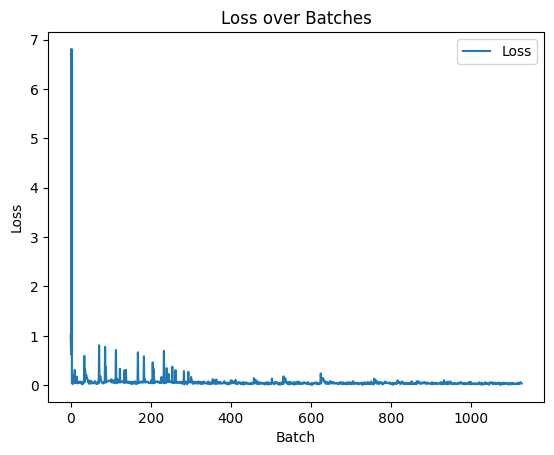

Maximum Loss: 6.811069965362549
Minimum Loss: 0.005274392664432526


In [23]:
# Load loss history from the JSON file
with open(LOSS_FILENAME, 'r') as f:
    loaded_losses = json.load(f)

# Plotting the graph
plt.plot(loaded_losses, label='Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss over Batches')
plt.legend()
plt.show()

# Finding max and min loss
max_loss = max(loaded_losses)
min_loss = min(loaded_losses)

print("Maximum Loss:", max_loss)
print("Minimum Loss:", min_loss)

In [24]:
MODEL_FILE = "model_checkpoint_3.pth"

In [25]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), MODEL_FILE)

#### IoU

In [32]:
print(batch_ious)
print("Epoch Mean IoU:", epoch_ious)

[tensor(0.3930, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0.0240, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0.1154, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), t

In [34]:
IOU_FILENAME = 'iou_history_focalloss_3.json'

In [39]:
# Save loss history to a local file
import json

# Converting tensors to floats and then to list
batch_iou_float = [float(tensor) for tensor in batch_ious]

with open(IOU_FILENAME, 'w') as f:
    json.dump(batch_iou_float, f)

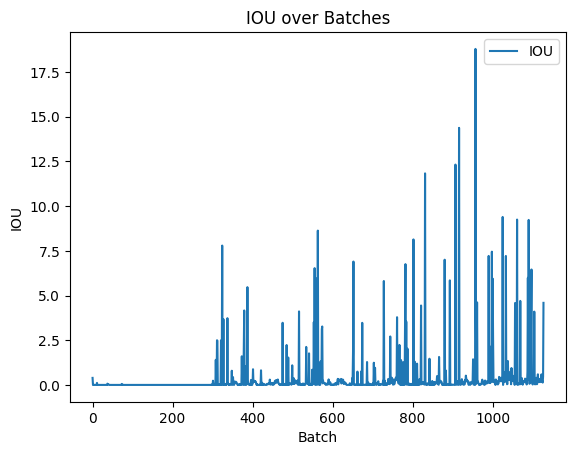

Maximum IOU: 18.79048728942871
Minimum IOU: 0.0


In [40]:
# Loading from JSON
with open(IOU_FILENAME, 'r') as f:
    loaded_iou = json.load(f)

# Plotting the graph
plt.plot(loaded_iou, label='IOU')
plt.xlabel('Batch')
plt.ylabel('IOU')
plt.title('IOU over Batches')
plt.legend()
plt.show()

# Finding max and min IOU
max_iou = max(loaded_iou)
min_iou = min(loaded_iou)

print("Maximum IOU:", max_iou)
print("Minimum IOU:", min_iou)

## Check performance on train set

In [23]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [24]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
model.load_state_dict(torch.load(MODEL_FILE))

# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

RANDOM IDX: 379


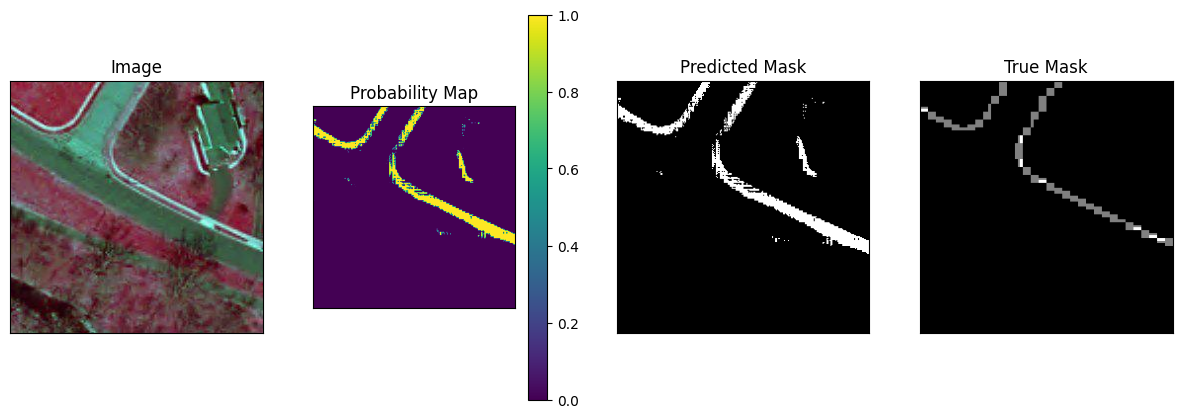

In [25]:
# let's take a random training example
idx = random.randint(0, data['imgarr'].shape[0]-1)
idx = 379
print("RANDOM IDX:", idx)
# load image
test_image = dataset[idx]["image"]
test_label = np.array(dataset[idx]["label"])

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

model.eval()

# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
PROBABILITY_THRES = 0.6
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > PROBABILITY_THRES).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right with probability map and color bar
im = axes[1].imshow(medsam_seg_prob, cmap='viridis')  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")
cbar = fig.colorbar(im, ax=axes[1])

# Plot the second image on the right
axes[2].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Predicted Mask")

# Plot the fourth image
axes[3].imshow(test_label, cmap='gray')
axes[3].set_title("True Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# Val - Unseen

In [26]:
from datasets import load_dataset
val = load_dataset("back2classroom/sidewalks", split='val', streaming=False)
print(next(iter(val)))
print(val)

{'filename': '1016_10_1', 'tfw': b'1.0000000000\r\n0.0000000000\r\n0.0000000000\r\n1.0000000000\r\n0.0000000000\r\n2304.0000000000\r\n', 'tif': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\

In [28]:
val_image_arr = []
val_label_arr = []
val_tif_obj = []
val_lbl_obj = []
fname = []

def byte_string_to_binary(label, normalize=False):
    """
    Convert a byte string to a binary black and white numpy array.

    Args:
    - label: A byte string representing an image.
    - normalize: Boolean indicating whether to normalize the image array (default is False).

    Returns:
    - image_object: PIL Image object.
    - binary_img_arr: A binary black and white numpy array.
    """
    # Convert byte string to PIL Image object
    image_object = io.BytesIO(label)
    image_array = np.array(Image.open(image_object))

    # Thresholding to convert to binary black and white
    if normalize:
        binary_img_arr = (image_array).astype(np.uint8) / 255.0
    else:
        binary_img_arr = (image_array).astype(np.uint8)

    return image_object, binary_img_arr

TOTAL_ITER = 1000
progress_bar = tqdm(total=TOTAL_ITER, desc='Processing')

for idx, item in enumerate(val):
    image_object, image_array = byte_string_to_binary(item['tif'], normalize=False)
    label_object, label_array = byte_string_to_binary(item['label_tif'])
    # Check if the mask is not full black to filter out no-sidewalks img
    if not np.all(label_array[0] == 0):
        fname.append(item['filename'])
        val_tif_obj.append(image_object)
        val_lbl_obj.append(label_object)
        val_image_arr.append(image_array)
        val_label_arr.append(label_array)
    
    # Update the progress bar
    progress_bar.update(1)

    if idx == TOTAL_ITER:
        break

Processing: 1001it [00:09, 110.62it/s] 


In [29]:
# Create a DataFrame
val_df = pd.DataFrame({
    'image': val_tif_obj,
    'label': val_lbl_obj,
    'imgarr': val_image_arr,
    'lblarr': val_label_arr
})

# Export the DataFrame to a CSV file
val_df.to_pickle('dataset_val.pkl')

# Print the dimensions of the DataFrame
print("DataFrame Dimensions:", val_df.shape)

DataFrame Dimensions: (341, 4)


In [30]:
valpkl = pd.read_pickle('dataset_val.pkl')
print(valpkl.head())

                                        image  \
0  <_io.BytesIO object at 0x0000024F566724D0>   
1  <_io.BytesIO object at 0x0000024F56672520>   
2  <_io.BytesIO object at 0x0000024F56672570>   
3  <_io.BytesIO object at 0x0000024F566725C0>   
4  <_io.BytesIO object at 0x0000024F56672610>   

                                        label  \
0  <_io.BytesIO object at 0x0000024F4FC90FE0>   
1  <_io.BytesIO object at 0x0000024F4FC91030>   
2  <_io.BytesIO object at 0x0000024F4FC91080>   
3  <_io.BytesIO object at 0x0000024F4FC910D0>   
4  <_io.BytesIO object at 0x0000024F4FC91120>   

                                              imgarr  \
0  [[[57, 5, 27], [62, 8, 31], [70, 8, 33], [71, ...   
1  [[[63, 2, 35], [72, 13, 45], [81, 26, 55], [88...   
2  [[[75, 21, 44], [75, 21, 44], [74, 23, 42], [7...   
3  [[[87, 28, 48], [86, 29, 48], [83, 26, 43], [7...   
4  [[[84, 56, 78], [84, 59, 80], [85, 59, 84], [8...   

                                              lblarr  
0  [[0, 0, 0, 0, 0

In [31]:
from datasets import Dataset
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_val_dict = {
    "image": [Image.fromarray(img) for img in valpkl['imgarr']],
    "label": [Image.fromarray(mask) for mask in valpkl['lblarr']],
}

# Create the dataset using the datasets.Dataset class
dataset_val = Dataset.from_dict(dataset_val_dict)
dataset_val

Dataset({
    features: ['image', 'label'],
    num_rows: 341
})

In [68]:
MODEL_FILE = "model_checkpoint_3.pth"

In [69]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
new_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
new_model.load_state_dict(torch.load(MODEL_FILE))

<All keys matched successfully>

23


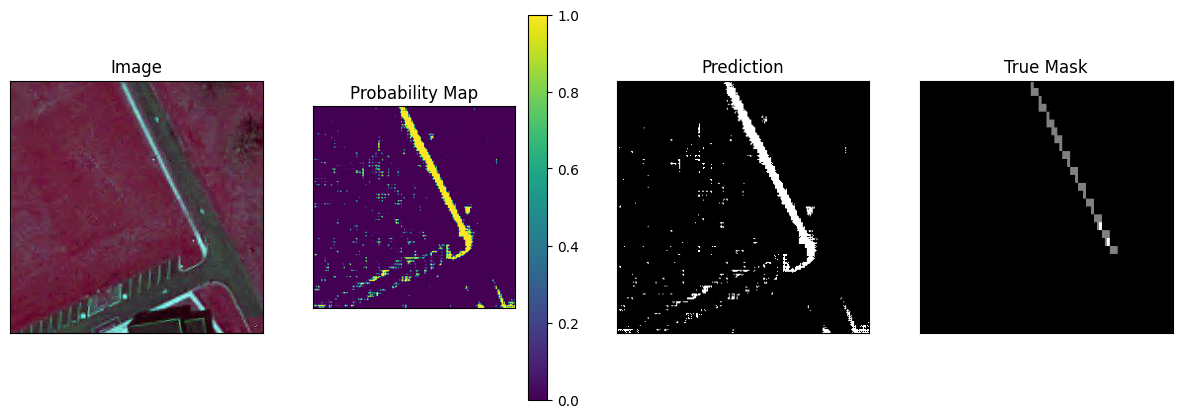

In [72]:
idx = 23 # random.randint(0, len(dataset_val)) #258
print(idx)
new_image = np.array(dataset_val[idx]["image"])
new_label = np.array(dataset_val[idx]["label"])

inputs = processor(new_image, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
new_model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

# apply sigmoid
pred_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
PROBABILITY_THRES = 0.96
pred_prob = pred_prob.cpu().numpy().squeeze()
pred_prediction = (pred_prob > PROBABILITY_THRES).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(new_image, cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image
im = axes[1].imshow(pred_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")
cbar = fig.colorbar(im, ax=axes[1])

# Plot the third image
axes[2].imshow(pred_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Plot the fourth image
axes[3].imshow(new_label, cmap='gray')
axes[3].set_title("True Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()